# Part 1, Re-track IBB Index

If you have read the paper, you may notice that the first part of application in the paper is to select a subset of stocks from IBB Index to re-track the Index.


OK, let's start.

In [2]:
# Run some setup code for this notebook.
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict

** Load data **

- `index_col = 0`: since first column is date (useless for training), let's keep it as index
- `dropna(axis=1, how='any')`: drop any stock with any n/a (missing) data
- `astype('float32')`: datatype

Finally we only have **83** stocks to use.

In [3]:
# Load data

# stock componenet data
stock = defaultdict(defaultdict)

stock_lp = pd.read_csv('data/last_price.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['lp'] = stock_lp.iloc[0:104, :]
stock['validate']['lp'] = stock_lp.iloc[104:, :]

stock_net = pd.read_csv('data/net_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['net'] = stock_net.iloc[0:104, :]
stock['validate']['net'] = stock_net.iloc[104:, :]

stock_percentage = pd.read_csv('data/percentage_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['percentage'] = stock_percentage.iloc[0:104, :]
stock['validate']['percentage'] = stock_percentage.iloc[104:, :]


# ibb data
ibb = defaultdict(defaultdict)
ibb_full = pd.read_csv('data/ibb.csv', index_col=0).astype('float32')

ibb_lp = ibb_full.iloc[:,0] # Series
ibb['calibrate']['lp'] = ibb_lp[0:104]
ibb['validate']['lp'] = ibb_lp[104:]

ibb_net = ibb_full.iloc[:,1] # Series
ibb['calibrate']['net'] = ibb_net[0:104]
ibb['validate']['net'] = ibb_net[104:]

ibb_percentage = ibb_full.iloc[:,2] # Series
ibb['calibrate']['percentage'] = ibb_percentage[0:104]
ibb['validate']['percentage'] = ibb_percentage[104:]

In [4]:
stock_lp

CELG    US Equity  GILD    US Equity  BIIB    US Equity  \
1/6/2012           67.220001          42.779999         115.500000   
1/13/2012          72.629997          44.889999         116.029999   
1/20/2012          73.839996          47.439999         118.139999   
1/27/2012          73.370003          48.720001         118.559998   
2/3/2012           73.209999          54.695000         121.879997   
...                      ...                ...                ...   
4/1/2016          101.190002          94.120003         260.540009   
4/8/2016          106.260002          96.089996         270.829987   
4/15/2016         107.339996          98.290001         268.500000   
4/22/2016         110.519997         101.930000         282.700012   
4/29/2016         103.410004          88.209999         274.989990   

           AMGN    US Equity  REGN    US Equity  INCY    US Equity  \
1/6/2012           64.760002          65.790001          16.299999   
1/13/2012          67.599998          78.919998          16.870001   
1/20/2012          69.570000          78.330002          17.280001   
1/27/2012          68.339996          85.540001          17.920000   
2/3/2012           69.279999          96.860001          17.660000   
...                      ...                ...                ...   
4/1/2016          154.160004         405.250000          73.300003   
4/8/2016          156.460007         404.940002          77.470001   
4/15/2016         160.130005         406.730011          77.779999   
4/22/2016         163.190002         404.380005          76.769997   
4/29/2016         158.300003         376.709991          72.269997   

           ILMN    US Equity  MYL     US Equity  VRTX    US Equity  \
1/6/2012           31.770000          21.469999          34.049999   
1/13/2012          35.709999          21.709999          36.810001   
1/20/2012          36.299999          21.559999          36.310001   
1/27/2012          51.685001          21.040001          35.980000   
2/3/2012           51.840000          22.440001          36.779999   
...                      ...                ...                ...   
4/1/2016          166.860001          47.500000          79.150002   
4/8/2016          168.360001          47.000000          85.250000   
4/15/2016         173.639999          46.889999          81.750000   
4/22/2016         143.589996          48.290001          86.800003   
4/29/2016         134.990005          41.709999          84.339996   

           ALXN    US Equity  ...  AVDL    US Equity  ARNA    US Equity  \
1/6/2012           74.449997  ...               5.70               1.62   
1/13/2012          74.620003  ...               5.76               1.65   
1/20/2012          73.580002  ...               5.52               1.62   
1/27/2012          75.400002  ...               6.08               1.59   
2/3/2012           78.875000  ...               6.57               1.87   
...                      ...  ...                ...                ...   
4/1/2016          142.940002  ...              10.97               1.98   
4/8/2016          148.889999  ...              11.85               1.90   
4/15/2016         153.089996  ...              11.29               1.85   
4/22/2016         159.100006  ...              11.60               1.85   
4/29/2016         139.279999  ...              11.46               1.72   

           GERN    US Equity  NVAX    US Equity  PDLI    US Equity  \
1/6/2012               1.670               1.37               6.13   
1/13/2012              1.690               1.31               6.11   
1/20/2012              1.730               1.31               6.33   
1/27/2012              1.960               1.45               6.40   
2/3/2012               2.075               1.49               6.48   
...                      ...                ...                ...   
4/1/2016               3.000               5.49               3.31   
4/8/2016               3.15

# Phase 1. Auto-encoding

1. Train an auto-encoder model compressing market information.
2. Rank stocks by 2-norm difference then select subset of them as our portfolio.
3. Page 7 of the paper: ReLU + linear as activation functions
4. Weights $W = (W_1, W_2)$, L2 regularization


Some problems I did not figure out (or the paper did not mention about the details):
1. which weekly return/what data to be used? (what can represent best market information?)
2. How to do the data preprocessing?
3. How to perform 4-fold validation in Deep Learning?

In [6]:
reconstruct.shape

(104, 83)

In [5]:
encoding_dim = 5 # 5 neurons
num_stock = len(stock_lp.columns) # Use 83 stocks as features

# connect all layers
input_img = Input(shape=(num_stock, ))
encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
decoded = Dense(num_stock, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded) # see 'Stacked Auto-Encoders' in paper

# construct and compile AE model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

# train autoencoder
data = stock['calibrate']['net']
autoencoder.fit(data, data, shuffle=False, epochs=500, batch_size = 10)
autoencoder.save('model/retrack_autoencoder.h5')

# test/reconstruct market information matrix
reconstruct = autoencoder.predict(data)







Epoch 1/500
104/104 [==============================] - 0s 3ms/step - loss: 5.6770
Epoch 2/500
104/104 [==============================] - 0s 142us/step - loss: 5.4863
Epoch 3/500
104/104 [==============================] - 0s 135us/step - loss: 5.3815
Epoch 4/500
104/104 [==============================] - 0s 110us/step - loss: 5.3016
Epoch 5/500
104/104 [==============================] - 0s 103us/step - loss: 5.2232
Epoch 6/500
104/104 [==============================] - 0s 101us/step - loss: 5.1414
Epoch 7/500
104/104 [==============================] - 0s 101us/step - loss: 5.0540
Epoch 8/500
104/104 [==============================] - 0s 104us/step - loss: 4.9595
Epoch 9/500
104/104 [==============================] - 0s 103us/step - loss: 4.8550
Epoch 10/500
104/104 [==============================] - 0s 104us/step - loss: 4.7399
Epoch 11/500
104/104 [==============================] - 0s 107us/step - loss: 4.6179
Epoch 12/500
104/104 [==============================] - 0s 106us/step 

104/104 [==============================] - 0s 99us/step - loss: 2.2784
Epoch 180/500
104/104 [==============================] - 0s 98us/step - loss: 2.2772
Epoch 181/500
104/104 [==============================] - 0s 96us/step - loss: 2.2759
Epoch 182/500
104/104 [==============================] - 0s 96us/step - loss: 2.2747
Epoch 183/500
104/104 [==============================] - 0s 97us/step - loss: 2.2734
Epoch 184/500
104/104 [==============================] - 0s 96us/step - loss: 2.2722
Epoch 185/500
104/104 [==============================] - 0s 99us/step - loss: 2.2710
Epoch 186/500
104/104 [==============================] - 0s 98us/step - loss: 2.2699
Epoch 187/500
104/104 [==============================] - 0s 98us/step - loss: 2.2687
Epoch 188/500
104/104 [==============================] - 0s 99us/step - loss: 2.2676
Epoch 189/500
104/104 [==============================] - 0s 97us/step - loss: 2.2665
Epoch 190/500
104/104 [==============================] - 0s 97us/step - loss: 2

104/104 [==============================] - 0s 101us/step - loss: 2.1801
Epoch 372/500
104/104 [==============================] - 0s 102us/step - loss: 2.1799
Epoch 373/500
104/104 [==============================] - 0s 104us/step - loss: 2.1798
Epoch 374/500
104/104 [==============================] - 0s 104us/step - loss: 2.1796
Epoch 375/500
104/104 [==============================] - 0s 99us/step - loss: 2.1794
Epoch 376/500
104/104 [==============================] - 0s 101us/step - loss: 2.1792
Epoch 377/500
104/104 [==============================] - 0s 103us/step - loss: 2.1791
Epoch 378/500
104/104 [==============================] - 0s 110us/step - loss: 2.1789
Epoch 379/500
104/104 [==============================] - 0s 108us/step - loss: 2.1788
Epoch 380/500
104/104 [==============================] - 0s 105us/step - loss: 2.1786
Epoch 381/500
104/104 [==============================] - 0s 105us/step - loss: 2.1785
Epoch 382/500
104/104 [==============================] - 0s 105us/ste

** Communal Information **

- Compute $||X - \hat{X}||$ as 2 norm difference
- The least 2 norm difference a stock has, the more important role it plays in the compressed market auto-encoder
- The paper says that, AMGN should be the best, and BCRX should be the worst. (But I didn't achieve this result.)

In [7]:
communal_information = []

for i in range(0,83):
    diff = np.linalg.norm((data.iloc[:,i] - reconstruct[:,i])) # 2 norm difference
    communal_information.append(float(diff))
 
print("stock #, 2-norm, stock name")
ranking = np.array(communal_information).argsort()
for stock_index in ranking:
    print(stock_index, communal_information[stock_index], stock['calibrate']['net'].iloc[:,stock_index].name) # print stock name from lowest different to highest

stock #, 2-norm, stock name
68 1.303792119026184 TLGT    US Equity
65 1.3843013048171997 INO     US Equity
38 1.601317048072815 LXRX    US Equity
76 1.8217182159423828 NVAX    US Equity
66 2.114776134490967 CERS    US Equity
79 2.175746440887451 ZGNX    US Equity
81 2.391012191772461 MNOV    US Equity
77 2.417902708053589 PDLI    US Equity
71 2.5106804370880127 CRIS    US Equity
52 2.8036720752716064 IMMU    US Equity
17 2.855459690093994 EXEL    US Equity
49 3.0396652221679688 DEPO    US Equity
75 3.1160309314727783 GERN    US Equity
37 3.4576103687286377 ARRY    US Equity
73 3.580310821533203 AVDL    US Equity
67 3.675309896469116 PACB    US Equity
48 3.9295570850372314 SGYP    US Equity
19 3.992969274520874 OPK     US Equity
42 4.157529354095459 RGEN    US Equity
72 4.191117286682129 PRTK    US Equity
55 4.253262996673584 BCRX    US Equity
31 4.258405685424805 HZNP    US Equity
82 4.3587775230407715 ARWR    US Equity
80 4.612107753753662 CGEN    US Equity
44 4.865374565124512 FOLD  

Let's have a look on how well this auto-encoder works on a certain stock.

/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


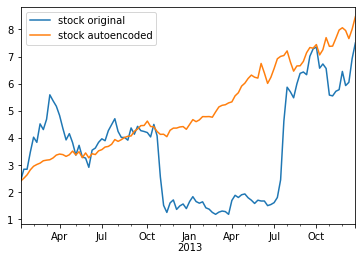

In [21]:
which_stock = 55

# now decoded last price plot
stock_autoencoder = copy.deepcopy(reconstruct[:, which_stock])
stock_autoencoder[0] = 0
stock_autoencoder = stock_autoencoder.cumsum()
stock_autoencoder += (stock['calibrate']['lp'].iloc[0, which_stock])

## plot for comparison
pd.Series(stock['calibrate']['lp'].iloc[:, which_stock].as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='stock original', legend=True)
pd.Series(stock_autoencoder, index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='stock autoencoded', legend=True)

# Phase 2: Calibrating

In [15]:
np.concatenate((ranking[0:10], ranking[-25:])) 

array([68, 65, 38, 76, 66, 79, 81, 77, 71, 52, 29, 70, 43, 12,  4, 35, 33,
       39, 22,  5,  8, 20, 30, 10,  2,  3,  6, 14, 11, 16,  0, 36,  9, 27,
        1])

In [17]:
ibb['calibrate']['percentage']

Date
6/1/2012      0.000000
13/1/2012     4.794329
20/1/2012     0.578549
27/1/2012     2.884956
3/2/2012      3.767418
                ...   
29/11/2013    1.599964
6/12/2013    -0.959136
13/12/2013   -2.936805
20/12/2013    3.809922
27/12/2013    0.992401
Name: % Change, Length: 104, dtype: float32

In [9]:
ibb_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    
    # connect all layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = stock['calibrate']['percentage'].iloc[:, stock_index]
    y = ibb['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    deep_learner.fit(x, y, shuffle=False, epochs=500, batch_size = 10)    # fit the model
    deep_learner.save('model/retrack_s' + str(s) + '.h5') # for validation phase use
    
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['calibrate'][s] = ibb['calibrate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['calibrate'][s] = np.linalg.norm((ibb_predict['calibrate'][s] - ibb['calibrate']['lp']))

Epoch 1/500
104/104 [==============================] - 0s 4ms/step - loss: 4.4957
Epoch 2/500
104/104 [==============================] - 0s 135us/step - loss: 2.5571
Epoch 3/500
104/104 [==============================] - 0s 108us/step - loss: 1.9356
Epoch 4/500
104/104 [==============================] - 0s 103us/step - loss: 1.5793
Epoch 5/500
104/104 [==============================] - 0s 103us/step - loss: 1.3418
Epoch 6/500
104/104 [==============================] - 0s 95us/step - loss: 1.1671
Epoch 7/500
104/104 [==============================] - 0s 98us/step - loss: 1.0384
Epoch 8/500
104/104 [==============================] - 0s 101us/step - loss: 0.9431
Epoch 9/500
104/104 [==============================] - 0s 95us/step - loss: 0.8720
Epoch 10/500
104/104 [==============================] - 0s 98us/step - loss: 0.8168
Epoch 11/500
104/104 [==============================] - 0s 96us/step - loss: 0.7725
Epoch 12/500
104/104 [==============================] - 0s 96us/step - loss: 0.73

104/104 [==============================] - 0s 95us/step - loss: 0.2889
Epoch 195/500
104/104 [==============================] - 0s 97us/step - loss: 0.2880
Epoch 196/500
104/104 [==============================] - 0s 98us/step - loss: 0.2875
Epoch 197/500
104/104 [==============================] - 0s 98us/step - loss: 0.2869
Epoch 198/500
104/104 [==============================] - 0s 94us/step - loss: 0.2871
Epoch 199/500
104/104 [==============================] - 0s 98us/step - loss: 0.2862
Epoch 200/500
104/104 [==============================] - 0s 93us/step - loss: 0.2861
Epoch 201/500
104/104 [==============================] - 0s 91us/step - loss: 0.2859
Epoch 202/500
104/104 [==============================] - 0s 92us/step - loss: 0.2853
Epoch 203/500
104/104 [==============================] - 0s 96us/step - loss: 0.2847
Epoch 204/500
104/104 [==============================] - 0s 92us/step - loss: 0.2847
Epoch 205/500
104/104 [==============================] - 0s 93us/step - loss: 0

104/104 [==============================] - 0s 93us/step - loss: 0.2395
Epoch 387/500
104/104 [==============================] - 0s 93us/step - loss: 0.2390
Epoch 388/500
104/104 [==============================] - 0s 89us/step - loss: 0.2394
Epoch 389/500
104/104 [==============================] - 0s 90us/step - loss: 0.2382
Epoch 390/500
104/104 [==============================] - 0s 94us/step - loss: 0.2384
Epoch 391/500
104/104 [==============================] - 0s 92us/step - loss: 0.2381
Epoch 392/500
104/104 [==============================] - 0s 90us/step - loss: 0.2371
Epoch 393/500
104/104 [==============================] - 0s 92us/step - loss: 0.2376
Epoch 394/500
104/104 [==============================] - 0s 91us/step - loss: 0.2368
Epoch 395/500
104/104 [==============================] - 0s 91us/step - loss: 0.2367
Epoch 396/500
104/104 [==============================] - 0s 90us/step - loss: 0.2368
Epoch 397/500
104/104 [==============================] - 0s 90us/step - loss: 0

104/104 [==============================] - 0s 97us/step - loss: 0.1906
Epoch 80/500
104/104 [==============================] - 0s 101us/step - loss: 0.1894
Epoch 81/500
104/104 [==============================] - 0s 95us/step - loss: 0.1884
Epoch 82/500
104/104 [==============================] - 0s 94us/step - loss: 0.1874
Epoch 83/500
104/104 [==============================] - 0s 97us/step - loss: 0.1863
Epoch 84/500
104/104 [==============================] - 0s 98us/step - loss: 0.1844
Epoch 85/500
104/104 [==============================] - 0s 93us/step - loss: 0.1849
Epoch 86/500
104/104 [==============================] - 0s 97us/step - loss: 0.1839
Epoch 87/500
104/104 [==============================] - 0s 95us/step - loss: 0.1829
Epoch 88/500
104/104 [==============================] - 0s 97us/step - loss: 0.1820
Epoch 89/500
104/104 [==============================] - 0s 96us/step - loss: 0.1812
Epoch 90/500
104/104 [==============================] - 0s 93us/step - loss: 0.1792
Epoc

104/104 [==============================] - 0s 100us/step - loss: 0.1011
Epoch 272/500
104/104 [==============================] - 0s 99us/step - loss: 0.1009
Epoch 273/500
104/104 [==============================] - 0s 99us/step - loss: 0.1007
Epoch 274/500
104/104 [==============================] - 0s 100us/step - loss: 0.1006
Epoch 275/500
104/104 [==============================] - 0s 100us/step - loss: 0.1003
Epoch 276/500
104/104 [==============================] - 0s 101us/step - loss: 0.1001
Epoch 277/500
104/104 [==============================] - 0s 102us/step - loss: 0.0998
Epoch 278/500
104/104 [==============================] - 0s 101us/step - loss: 0.0997
Epoch 279/500
104/104 [==============================] - 0s 99us/step - loss: 0.0995
Epoch 280/500
104/104 [==============================] - 0s 96us/step - loss: 0.0993
Epoch 281/500
104/104 [==============================] - 0s 94us/step - loss: 0.0991
Epoch 282/500
104/104 [==============================] - 0s 93us/step - l

104/104 [==============================] - 0s 101us/step - loss: 0.0844
Epoch 464/500
104/104 [==============================] - 0s 101us/step - loss: 0.0844
Epoch 465/500
104/104 [==============================] - 0s 102us/step - loss: 0.0844
Epoch 466/500
104/104 [==============================] - 0s 106us/step - loss: 0.0843
Epoch 467/500
104/104 [==============================] - 0s 104us/step - loss: 0.0843
Epoch 468/500
104/104 [==============================] - 0s 104us/step - loss: 0.0844
Epoch 469/500
104/104 [==============================] - 0s 103us/step - loss: 0.0842
Epoch 470/500
104/104 [==============================] - 0s 103us/step - loss: 0.0842
Epoch 471/500
104/104 [==============================] - 0s 100us/step - loss: 0.0843
Epoch 472/500
104/104 [==============================] - 0s 102us/step - loss: 0.0841
Epoch 473/500
104/104 [==============================] - 0s 103us/step - loss: 0.0841
Epoch 474/500
104/104 [==============================] - 0s 100us/st

104/104 [==============================] - 0s 96us/step - loss: 0.1391
Epoch 61/500
104/104 [==============================] - 0s 98us/step - loss: 0.1379
Epoch 62/500
104/104 [==============================] - 0s 95us/step - loss: 0.1367
Epoch 63/500
104/104 [==============================] - 0s 95us/step - loss: 0.1357
Epoch 64/500
104/104 [==============================] - 0s 97us/step - loss: 0.1345
Epoch 65/500
104/104 [==============================] - 0s 97us/step - loss: 0.1335
Epoch 66/500
104/104 [==============================] - 0s 97us/step - loss: 0.1326
Epoch 67/500
104/104 [==============================] - 0s 96us/step - loss: 0.1315
Epoch 68/500
104/104 [==============================] - 0s 98us/step - loss: 0.1305
Epoch 69/500
104/104 [==============================] - 0s 98us/step - loss: 0.1298
Epoch 70/500
104/104 [==============================] - 0s 94us/step - loss: 0.1286
Epoch 71/500
104/104 [==============================] - 0s 94us/step - loss: 0.1279
Epoch

Epoch 157/500
104/104 [==============================] - 0s 97us/step - loss: 0.0982
Epoch 158/500
104/104 [==============================] - 0s 98us/step - loss: 0.0982
Epoch 159/500
104/104 [==============================] - 0s 99us/step - loss: 0.0979
Epoch 160/500
104/104 [==============================] - 0s 97us/step - loss: 0.0978
Epoch 161/500
104/104 [==============================] - 0s 99us/step - loss: 0.0975
Epoch 162/500
104/104 [==============================] - 0s 100us/step - loss: 0.0974
Epoch 163/500
104/104 [==============================] - 0s 96us/step - loss: 0.0972
Epoch 164/500
104/104 [==============================] - 0s 96us/step - loss: 0.0970
Epoch 165/500
104/104 [==============================] - 0s 95us/step - loss: 0.0968
Epoch 166/500
104/104 [==============================] - 0s 93us/step - loss: 0.0967
Epoch 167/500
104/104 [==============================] - 0s 95us/step - loss: 0.0964
Epoch 168/500
104/104 [==============================] - 0s 98us

104/104 [==============================] - 0s 100us/step - loss: 0.0773
Epoch 350/500
104/104 [==============================] - 0s 102us/step - loss: 0.0773
Epoch 351/500
104/104 [==============================] - 0s 100us/step - loss: 0.0772
Epoch 352/500
104/104 [==============================] - 0s 94us/step - loss: 0.0770
Epoch 353/500
104/104 [==============================] - 0s 100us/step - loss: 0.0771
Epoch 354/500
104/104 [==============================] - 0s 98us/step - loss: 0.0770
Epoch 355/500
104/104 [==============================] - 0s 95us/step - loss: 0.0771
Epoch 356/500
104/104 [==============================] - 0s 96us/step - loss: 0.0769
Epoch 357/500
104/104 [==============================] - 0s 97us/step - loss: 0.0768
Epoch 358/500
104/104 [==============================] - 0s 98us/step - loss: 0.0767
Epoch 359/500
104/104 [==============================] - 0s 97us/step - loss: 0.0766
Epoch 360/500
104/104 [==============================] - 0s 99us/step - los

104/104 [==============================] - 0s 111us/step - loss: 0.0721
Epoch 446/500
104/104 [==============================] - 0s 104us/step - loss: 0.0720
Epoch 447/500
104/104 [==============================] - 0s 99us/step - loss: 0.0721
Epoch 448/500
104/104 [==============================] - 0s 96us/step - loss: 0.0720
Epoch 449/500
104/104 [==============================] - 0s 99us/step - loss: 0.0720
Epoch 450/500
104/104 [==============================] - 0s 95us/step - loss: 0.0719
Epoch 451/500
104/104 [==============================] - 0s 97us/step - loss: 0.0719
Epoch 452/500
104/104 [==============================] - 0s 97us/step - loss: 0.0718
Epoch 453/500
104/104 [==============================] - 0s 97us/step - loss: 0.0719
Epoch 454/500
104/104 [==============================] - 0s 99us/step - loss: 0.0717
Epoch 455/500
104/104 [==============================] - 0s 99us/step - loss: 0.0717
Epoch 456/500
104/104 [==============================] - 0s 101us/step - loss

Now we would like to see how similar these 3 portfolios perform as the original IBB Index does on training dates.

S25 2-norm difference:  13.322672
S45 2-norm difference:  14.25769
S65 2-norm difference:  1.4467665


/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


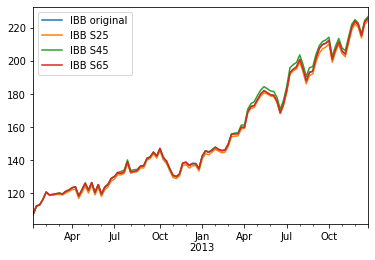

In [9]:
# plot results and 2-norm differences 
pd.Series(ibb['calibrate']['lp'].as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='IBB original', legend=True)

for s in [25, 45, 65]:
    pd.Series(ibb_predict['calibrate'][s], index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='IBB S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['calibrate'][s])    
    


# Phase 3: Validating

In [10]:
for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('model/retrack_s' + str(s) + '.h5')
    
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['validate'][s] = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['validate'][s] = np.linalg.norm((ibb_predict['validate'][s] - ibb['validate']['lp']))

Again, we would like to see how similar these 3 portfolios perform as the original IBB Index does, but on test dates.

/Users/lijinyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


S25 2-norm difference:  354.84158
S45 2-norm difference:  546.2681
S65 2-norm difference:  282.7063


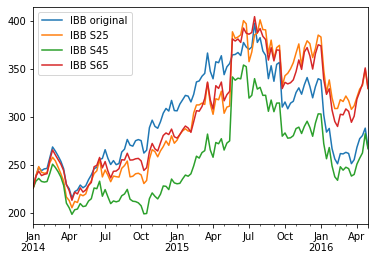

In [11]:
# plot results and 2-norm differences
pd.Series(ibb['validate']['lp'].as_matrix(), index=pd.date_range(start='01/03/2014', periods=122, freq='W')).plot(label='IBB original', legend=True) 

for s in [25, 45, 65]:
    pd.Series(ibb_predict['validate'][s], index=pd.date_range(start='01/03/2014', periods = 122,freq='W')).plot(label='IBB S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['validate'][s])  

# Phase 4: Verifying

- x-axis: 2-norm error  
- y-axis: # of stocks in the portfolios: 10, 11, 12, ..., 

From my perspective, Efficient Deep Frontier has nothing to do with the one in Modern Portfolio Theory. It just reflects the trade-off between more stocks in the portfolios and higher MSE.

In [12]:
error = []
for non_communal in range(5, 79, 1):  
    
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index


    # training
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x_train = stock['calibrate']['percentage'].iloc[:, stock_index]
    y_train = ibb['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x_train)
    x_train = dl_scaler[s].transform(x_train)  
    
    deep_learner.fit(x_train, y_train, shuffle=False, epochs=500, batch_size = 10)    # fit the model


    # testing
    x_test = stock['validate']['percentage'].iloc[:, stock_index]
    y_test = ibb['validate']['percentage']

    x_test = dl_scaler[s].transform(x_test)  
    
    relative_percentage = copy.deepcopy(deep_learner.predict(x_test))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    error.append(np.linalg.norm((predict_curve - ibb['validate']['lp'])))    

Epoch 1/500
104/104 [==============================] - 1s 5ms/step - loss: 4.8297
Epoch 2/500
104/104 [==============================] - 0s 100us/step - loss: 3.7927
Epoch 3/500
104/104 [==============================] - 0s 94us/step - loss: 3.1699
Epoch 4/500
104/104 [==============================] - 0s 97us/step - loss: 2.7247
Epoch 5/500
104/104 [==============================] - 0s 96us/step - loss: 2.4304
Epoch 6/500
104/104 [==============================] - 0s 94us/step - loss: 2.2416
Epoch 7/500
104/104 [==============================] - 0s 95us/step - loss: 2.1033
Epoch 8/500
104/104 [==============================] - 0s 93us/step - loss: 1.9926
Epoch 9/500
104/104 [==============================] - 0s 95us/step - loss: 1.8973
Epoch 10/500
104/104 [==============================] - 0s 102us/step - loss: 1.8157
Epoch 11/500
104/104 [==============================] - 0s 95us/step - loss: 1.7418
Epoch 12/500
104/104 [==============================] - 0s 99us/step - loss: 1.6743


104/104 [==============================] - 0s 101us/step - loss: 0.6659
Epoch 195/500
104/104 [==============================] - 0s 97us/step - loss: 0.6653
Epoch 196/500
104/104 [==============================] - 0s 98us/step - loss: 0.6628
Epoch 197/500
104/104 [==============================] - 0s 98us/step - loss: 0.6642
Epoch 198/500
104/104 [==============================] - 0s 97us/step - loss: 0.6636
Epoch 199/500
104/104 [==============================] - 0s 101us/step - loss: 0.6609
Epoch 200/500
104/104 [==============================] - 0s 99us/step - loss: 0.6627
Epoch 201/500
104/104 [==============================] - 0s 97us/step - loss: 0.6612
Epoch 202/500
104/104 [==============================] - 0s 99us/step - loss: 0.6596
Epoch 203/500
104/104 [==============================] - 0s 99us/step - loss: 0.6609
Epoch 204/500
104/104 [==============================] - 0s 97us/step - loss: 0.6598
Epoch 205/500
104/104 [==============================] - 0s 99us/step - loss:

104/104 [==============================] - 0s 100us/step - loss: 0.6128
Epoch 387/500
104/104 [==============================] - 0s 96us/step - loss: 0.6147
Epoch 388/500
104/104 [==============================] - 0s 100us/step - loss: 0.6140
Epoch 389/500
104/104 [==============================] - 0s 97us/step - loss: 0.6155
Epoch 390/500
104/104 [==============================] - 0s 94us/step - loss: 0.6130
Epoch 391/500
104/104 [==============================] - 0s 97us/step - loss: 0.6135
Epoch 392/500
104/104 [==============================] - 0s 96us/step - loss: 0.6142
Epoch 393/500
104/104 [==============================] - 0s 94us/step - loss: 0.6150
Epoch 394/500
104/104 [==============================] - 0s 97us/step - loss: 0.6131
Epoch 395/500
104/104 [==============================] - 0s 95us/step - loss: 0.6127
Epoch 396/500
104/104 [==============================] - 0s 98us/step - loss: 0.6132
Epoch 397/500
104/104 [==============================] - 0s 97us/step - loss:

104/104 [==============================] - 0s 100us/step - loss: 0.6103
Epoch 483/500
104/104 [==============================] - 0s 103us/step - loss: 0.6100
Epoch 484/500
104/104 [==============================] - 0s 97us/step - loss: 0.6110
Epoch 485/500
104/104 [==============================] - 0s 99us/step - loss: 0.6085
Epoch 486/500
104/104 [==============================] - 0s 103us/step - loss: 0.6100
Epoch 487/500
104/104 [==============================] - 0s 97us/step - loss: 0.6116
Epoch 488/500
104/104 [==============================] - 0s 101us/step - loss: 0.6096
Epoch 489/500
104/104 [==============================] - 0s 107us/step - loss: 0.6103
Epoch 490/500
104/104 [==============================] - 0s 100us/step - loss: 0.6095
Epoch 491/500
104/104 [==============================] - 0s 101us/step - loss: 0.6100
Epoch 492/500
104/104 [==============================] - 0s 96us/step - loss: 0.6103
Epoch 493/500
104/104 [==============================] - 0s 96us/step - 

104/104 [==============================] - 0s 102us/step - loss: 0.7158
Epoch 176/500
104/104 [==============================] - 0s 104us/step - loss: 0.7133
Epoch 177/500
104/104 [==============================] - 0s 95us/step - loss: 0.7125
Epoch 178/500
104/104 [==============================] - 0s 92us/step - loss: 0.7107
Epoch 179/500
104/104 [==============================] - 0s 96us/step - loss: 0.7109
Epoch 180/500
104/104 [==============================] - 0s 94us/step - loss: 0.7092
Epoch 181/500
104/104 [==============================] - 0s 92us/step - loss: 0.7067
Epoch 182/500
104/104 [==============================] - 0s 95us/step - loss: 0.7080
Epoch 183/500
104/104 [==============================] - 0s 93us/step - loss: 0.7060
Epoch 184/500
104/104 [==============================] - 0s 95us/step - loss: 0.7041
Epoch 185/500
104/104 [==============================] - 0s 101us/step - loss: 0.7050
Epoch 186/500
104/104 [==============================] - 0s 95us/step - loss

104/104 [==============================] - 0s 112us/step - loss: 0.6229
Epoch 366/500
104/104 [==============================] - 0s 108us/step - loss: 0.6252
Epoch 367/500
104/104 [==============================] - 0s 105us/step - loss: 0.6235
Epoch 368/500
104/104 [==============================] - 0s 102us/step - loss: 0.6261
Epoch 369/500
104/104 [==============================] - 0s 109us/step - loss: 0.6234
Epoch 370/500
104/104 [==============================] - 0s 117us/step - loss: 0.6232
Epoch 371/500
104/104 [==============================] - 0s 109us/step - loss: 0.6228
Epoch 372/500
104/104 [==============================] - 0s 102us/step - loss: 0.6232
Epoch 373/500
104/104 [==============================] - 0s 110us/step - loss: 0.6235
Epoch 374/500
104/104 [==============================] - 0s 108us/step - loss: 0.6220
Epoch 375/500
104/104 [==============================] - 0s 103us/step - loss: 0.6227
Epoch 376/500
104/104 [==============================] - 0s 103us/st

104/104 [==============================] - 0s 107us/step - loss: 0.8877
Epoch 57/500
104/104 [==============================] - 0s 103us/step - loss: 0.8792
Epoch 58/500
104/104 [==============================] - 0s 102us/step - loss: 0.8739
Epoch 59/500
104/104 [==============================] - 0s 99us/step - loss: 0.8689
Epoch 60/500
104/104 [==============================] - 0s 105us/step - loss: 0.8650
Epoch 61/500
104/104 [==============================] - 0s 108us/step - loss: 0.8581
Epoch 62/500
104/104 [==============================] - 0s 100us/step - loss: 0.8541
Epoch 63/500
104/104 [==============================] - 0s 103us/step - loss: 0.8490
Epoch 64/500
104/104 [==============================] - 0s 100us/step - loss: 0.8453
Epoch 65/500
104/104 [==============================] - 0s 101us/step - loss: 0.8413
Epoch 66/500
104/104 [==============================] - 0s 101us/step - loss: 0.8365
Epoch 67/500
104/104 [==============================] - 0s 106us/step - loss: 0

104/104 [==============================] - 0s 105us/step - loss: 0.6529
Epoch 153/500
104/104 [==============================] - 0s 108us/step - loss: 0.6500
Epoch 154/500
104/104 [==============================] - 0s 99us/step - loss: 0.6515
Epoch 155/500
104/104 [==============================] - 0s 97us/step - loss: 0.6499
Epoch 156/500
104/104 [==============================] - 0s 97us/step - loss: 0.6486
Epoch 157/500
104/104 [==============================] - 0s 108us/step - loss: 0.6480
Epoch 158/500
104/104 [==============================] - 0s 107us/step - loss: 0.6472
Epoch 159/500
104/104 [==============================] - 0s 97us/step - loss: 0.6473
Epoch 160/500
104/104 [==============================] - 0s 102us/step - loss: 0.6454
Epoch 161/500
104/104 [==============================] - 0s 100us/step - loss: 0.6460
Epoch 162/500
104/104 [==============================] - 0s 100us/step - loss: 0.6438
Epoch 163/500
104/104 [==============================] - 0s 100us/step -

104/104 [==============================] - 0s 116us/step - loss: 0.5806
Epoch 343/500
104/104 [==============================] - 0s 105us/step - loss: 0.5788
Epoch 344/500
104/104 [==============================] - 0s 104us/step - loss: 0.5769
Epoch 345/500
104/104 [==============================] - 0s 105us/step - loss: 0.5780
Epoch 346/500
104/104 [==============================] - 0s 100us/step - loss: 0.5771
Epoch 347/500
104/104 [==============================] - 0s 102us/step - loss: 0.5779
Epoch 348/500
104/104 [==============================] - 0s 104us/step - loss: 0.5771
Epoch 349/500
104/104 [==============================] - 0s 100us/step - loss: 0.5768
Epoch 350/500
104/104 [==============================] - 0s 111us/step - loss: 0.5757
Epoch 351/500
104/104 [==============================] - 0s 114us/step - loss: 0.5773
Epoch 352/500
104/104 [==============================] - 0s 107us/step - loss: 0.5768
Epoch 353/500
104/104 [==============================] - 0s 103us/st

Epoch 33/500
104/104 [==============================] - 0s 104us/step - loss: 0.8783
Epoch 34/500
104/104 [==============================] - 0s 102us/step - loss: 0.8729
Epoch 35/500
104/104 [==============================] - 0s 105us/step - loss: 0.8650
Epoch 36/500
104/104 [==============================] - 0s 105us/step - loss: 0.8606
Epoch 37/500
104/104 [==============================] - 0s 110us/step - loss: 0.8549
Epoch 38/500
104/104 [==============================] - 0s 111us/step - loss: 0.8481
Epoch 39/500
104/104 [==============================] - 0s 104us/step - loss: 0.8439
Epoch 40/500
104/104 [==============================] - 0s 108us/step - loss: 0.8369
Epoch 41/500
104/104 [==============================] - 0s 112us/step - loss: 0.8342
Epoch 42/500
104/104 [==============================] - 0s 111us/step - loss: 0.8291
Epoch 43/500
104/104 [==============================] - 0s 104us/step - loss: 0.8239
Epoch 44/500
104/104 [==============================] - 0s 109us/

104/104 [==============================] - 0s 103us/step - loss: 0.6220
Epoch 130/500
104/104 [==============================] - 0s 104us/step - loss: 0.6214
Epoch 131/500
104/104 [==============================] - 0s 104us/step - loss: 0.6213
Epoch 132/500
104/104 [==============================] - 0s 106us/step - loss: 0.6184
Epoch 133/500
104/104 [==============================] - 0s 109us/step - loss: 0.6169
Epoch 134/500
104/104 [==============================] - 0s 108us/step - loss: 0.6145
Epoch 135/500
104/104 [==============================] - 0s 106us/step - loss: 0.6137
Epoch 136/500
104/104 [==============================] - 0s 99us/step - loss: 0.6137
Epoch 137/500
104/104 [==============================] - 0s 101us/step - loss: 0.6112
Epoch 138/500
104/104 [==============================] - 0s 103us/step - loss: 0.6105
Epoch 139/500
104/104 [==============================] - 0s 102us/step - loss: 0.6098
Epoch 140/500
104/104 [==============================] - 0s 107us/ste

104/104 [==============================] - 0s 110us/step - loss: 0.4313
Epoch 320/500
104/104 [==============================] - 0s 110us/step - loss: 0.4302
Epoch 321/500
104/104 [==============================] - 0s 106us/step - loss: 0.4282
Epoch 322/500
104/104 [==============================] - 0s 109us/step - loss: 0.4321
Epoch 323/500
104/104 [==============================] - 0s 116us/step - loss: 0.4286
Epoch 324/500
104/104 [==============================] - 0s 114us/step - loss: 0.4296
Epoch 325/500
104/104 [==============================] - 0s 113us/step - loss: 0.4295
Epoch 326/500
104/104 [==============================] - 0s 113us/step - loss: 0.4304
Epoch 327/500
104/104 [==============================] - 0s 112us/step - loss: 0.4282
Epoch 328/500
104/104 [==============================] - 0s 112us/step - loss: 0.4301
Epoch 329/500
104/104 [==============================] - 0s 99us/step - loss: 0.4299
Epoch 330/500
104/104 [==============================] - 0s 103us/ste

104/104 [==============================] - 0s 118us/step - loss: 1.8196
Epoch 10/500
104/104 [==============================] - 0s 116us/step - loss: 1.6836
Epoch 11/500
104/104 [==============================] - 0s 109us/step - loss: 1.5695
Epoch 12/500
104/104 [==============================] - 0s 109us/step - loss: 1.4778
Epoch 13/500
104/104 [==============================] - 0s 120us/step - loss: 1.4011
Epoch 14/500
104/104 [==============================] - 0s 116us/step - loss: 1.3263
Epoch 15/500
104/104 [==============================] - 0s 107us/step - loss: 1.2635
Epoch 16/500
104/104 [==============================] - 0s 120us/step - loss: 1.2100
Epoch 17/500
104/104 [==============================] - 0s 119us/step - loss: 1.1683
Epoch 18/500
104/104 [==============================] - 0s 119us/step - loss: 1.1292
Epoch 19/500
104/104 [==============================] - 0s 116us/step - loss: 1.0942
Epoch 20/500
104/104 [==============================] - 0s 118us/step - loss: 

104/104 [==============================] - 0s 109us/step - loss: 0.3815
Epoch 201/500
104/104 [==============================] - 0s 123us/step - loss: 0.3803
Epoch 202/500
104/104 [==============================] - 0s 114us/step - loss: 0.3792
Epoch 203/500
104/104 [==============================] - 0s 108us/step - loss: 0.3781
Epoch 204/500
104/104 [==============================] - 0s 102us/step - loss: 0.3773
Epoch 205/500
104/104 [==============================] - 0s 103us/step - loss: 0.3768
Epoch 206/500
104/104 [==============================] - 0s 109us/step - loss: 0.3765
Epoch 207/500
104/104 [==============================] - 0s 111us/step - loss: 0.3744
Epoch 208/500
104/104 [==============================] - 0s 112us/step - loss: 0.3745
Epoch 209/500
104/104 [==============================] - 0s 105us/step - loss: 0.3732
Epoch 210/500
104/104 [==============================] - 0s 114us/step - loss: 0.3720
Epoch 211/500
104/104 [==============================] - 0s 111us/st

104/104 [==============================] - 0s 126us/step - loss: 0.2984
Epoch 391/500
104/104 [==============================] - 0s 126us/step - loss: 0.2979
Epoch 392/500
104/104 [==============================] - 0s 128us/step - loss: 0.2981
Epoch 393/500
104/104 [==============================] - 0s 128us/step - loss: 0.2979
Epoch 394/500
104/104 [==============================] - 0s 129us/step - loss: 0.2975
Epoch 395/500
104/104 [==============================] - 0s 139us/step - loss: 0.2974
Epoch 396/500
104/104 [==============================] - 0s 135us/step - loss: 0.2978
Epoch 397/500
104/104 [==============================] - 0s 121us/step - loss: 0.2968
Epoch 398/500
104/104 [==============================] - 0s 130us/step - loss: 0.2983
Epoch 399/500
104/104 [==============================] - 0s 125us/step - loss: 0.2977
Epoch 400/500
104/104 [==============================] - 0s 117us/step - loss: 0.2977
Epoch 401/500
104/104 [==============================] - 0s 123us/st

104/104 [==============================] - 0s 117us/step - loss: 0.4229
Epoch 82/500
104/104 [==============================] - 0s 116us/step - loss: 0.4217
Epoch 83/500
104/104 [==============================] - 0s 113us/step - loss: 0.4197
Epoch 84/500
104/104 [==============================] - 0s 109us/step - loss: 0.4165
Epoch 85/500
104/104 [==============================] - 0s 112us/step - loss: 0.4164
Epoch 86/500
104/104 [==============================] - 0s 110us/step - loss: 0.4142
Epoch 87/500
104/104 [==============================] - 0s 114us/step - loss: 0.4119
Epoch 88/500
104/104 [==============================] - 0s 114us/step - loss: 0.4107
Epoch 89/500
104/104 [==============================] - 0s 121us/step - loss: 0.4100
Epoch 90/500
104/104 [==============================] - 0s 115us/step - loss: 0.4068
Epoch 91/500
104/104 [==============================] - 0s 118us/step - loss: 0.4068
Epoch 92/500
104/104 [==============================] - 0s 115us/step - loss: 

104/104 [==============================] - 0s 113us/step - loss: 0.2842
Epoch 272/500
104/104 [==============================] - 0s 116us/step - loss: 0.2854
Epoch 273/500
104/104 [==============================] - 0s 115us/step - loss: 0.2839
Epoch 274/500
104/104 [==============================] - 0s 121us/step - loss: 0.2845
Epoch 275/500
104/104 [==============================] - 0s 113us/step - loss: 0.2837
Epoch 276/500
104/104 [==============================] - 0s 116us/step - loss: 0.2833
Epoch 277/500
104/104 [==============================] - 0s 117us/step - loss: 0.2844
Epoch 278/500
104/104 [==============================] - 0s 114us/step - loss: 0.2834
Epoch 279/500
104/104 [==============================] - 0s 112us/step - loss: 0.2834
Epoch 280/500
104/104 [==============================] - 0s 113us/step - loss: 0.2838
Epoch 281/500
104/104 [==============================] - 0s 121us/step - loss: 0.2818
Epoch 282/500
104/104 [==============================] - 0s 117us/st

104/104 [==============================] - 0s 118us/step - loss: 0.2692
Epoch 462/500
104/104 [==============================] - 0s 120us/step - loss: 0.2693
Epoch 463/500
104/104 [==============================] - 0s 119us/step - loss: 0.2690
Epoch 464/500
104/104 [==============================] - 0s 118us/step - loss: 0.2684
Epoch 465/500
104/104 [==============================] - 0s 113us/step - loss: 0.2691
Epoch 466/500
104/104 [==============================] - 0s 118us/step - loss: 0.2682
Epoch 467/500
104/104 [==============================] - 0s 116us/step - loss: 0.2688
Epoch 468/500
104/104 [==============================] - 0s 117us/step - loss: 0.2686
Epoch 469/500
104/104 [==============================] - 0s 115us/step - loss: 0.2679
Epoch 470/500
104/104 [==============================] - 0s 123us/step - loss: 0.2681
Epoch 471/500
104/104 [==============================] - 0s 118us/step - loss: 0.2683
Epoch 472/500
104/104 [==============================] - 0s 114us/st

104/104 [==============================] - 0s 119us/step - loss: 0.3392
Epoch 153/500
104/104 [==============================] - 0s 119us/step - loss: 0.3382
Epoch 154/500
104/104 [==============================] - 0s 120us/step - loss: 0.3365
Epoch 155/500
104/104 [==============================] - 0s 114us/step - loss: 0.3362
Epoch 156/500
104/104 [==============================] - 0s 115us/step - loss: 0.3348
Epoch 157/500
104/104 [==============================] - 0s 117us/step - loss: 0.3342
Epoch 158/500
104/104 [==============================] - 0s 116us/step - loss: 0.3335
Epoch 159/500
104/104 [==============================] - 0s 116us/step - loss: 0.3320
Epoch 160/500
104/104 [==============================] - 0s 121us/step - loss: 0.3318
Epoch 161/500
104/104 [==============================] - 0s 119us/step - loss: 0.3305
Epoch 162/500
104/104 [==============================] - 0s 118us/step - loss: 0.3298
Epoch 163/500
104/104 [==============================] - 0s 116us/st

104/104 [==============================] - 0s 117us/step - loss: 0.2740
Epoch 343/500
104/104 [==============================] - 0s 112us/step - loss: 0.2737
Epoch 344/500
104/104 [==============================] - 0s 121us/step - loss: 0.2733
Epoch 345/500
104/104 [==============================] - 0s 124us/step - loss: 0.2741
Epoch 346/500
104/104 [==============================] - 0s 126us/step - loss: 0.2731
Epoch 347/500
104/104 [==============================] - 0s 127us/step - loss: 0.2730
Epoch 348/500
104/104 [==============================] - 0s 126us/step - loss: 0.2728
Epoch 349/500
104/104 [==============================] - 0s 128us/step - loss: 0.2725
Epoch 350/500
104/104 [==============================] - 0s 120us/step - loss: 0.2726
Epoch 351/500
104/104 [==============================] - 0s 124us/step - loss: 0.2724
Epoch 352/500
104/104 [==============================] - 0s 123us/step - loss: 0.2722
Epoch 353/500
104/104 [==============================] - 0s 129us/st

Epoch 33/500
104/104 [==============================] - 0s 110us/step - loss: 0.6363
Epoch 34/500
104/104 [==============================] - 0s 109us/step - loss: 0.6260
Epoch 35/500
104/104 [==============================] - 0s 112us/step - loss: 0.6179
Epoch 36/500
104/104 [==============================] - 0s 115us/step - loss: 0.6091
Epoch 37/500
104/104 [==============================] - 0s 114us/step - loss: 0.6013
Epoch 38/500
104/104 [==============================] - 0s 105us/step - loss: 0.5933
Epoch 39/500
104/104 [==============================] - 0s 109us/step - loss: 0.5854
Epoch 40/500
104/104 [==============================] - 0s 114us/step - loss: 0.5802
Epoch 41/500
104/104 [==============================] - 0s 110us/step - loss: 0.5744
Epoch 42/500
104/104 [==============================] - 0s 109us/step - loss: 0.5691
Epoch 43/500
104/104 [==============================] - 0s 106us/step - loss: 0.5636
Epoch 44/500
104/104 [==============================] - 0s 113us/

104/104 [==============================] - 0s 115us/step - loss: 0.3743
Epoch 130/500
104/104 [==============================] - 0s 115us/step - loss: 0.3693
Epoch 131/500
104/104 [==============================] - 0s 113us/step - loss: 0.3653
Epoch 132/500
104/104 [==============================] - 0s 115us/step - loss: 0.3609
Epoch 133/500
104/104 [==============================] - 0s 115us/step - loss: 0.3597
Epoch 134/500
104/104 [==============================] - 0s 112us/step - loss: 0.3562
Epoch 135/500
104/104 [==============================] - 0s 115us/step - loss: 0.3542
Epoch 136/500
104/104 [==============================] - 0s 119us/step - loss: 0.3523
Epoch 137/500
104/104 [==============================] - 0s 118us/step - loss: 0.3513
Epoch 138/500
104/104 [==============================] - 0s 119us/step - loss: 0.3499
Epoch 139/500
104/104 [==============================] - 0s 111us/step - loss: 0.3480
Epoch 140/500
104/104 [==============================] - 0s 119us/st

104/104 [==============================] - 0s 122us/step - loss: 0.3001
Epoch 320/500
104/104 [==============================] - 0s 116us/step - loss: 0.3006
Epoch 321/500
104/104 [==============================] - 0s 115us/step - loss: 0.3010
Epoch 322/500
104/104 [==============================] - 0s 113us/step - loss: 0.2998
Epoch 323/500
104/104 [==============================] - 0s 117us/step - loss: 0.2999
Epoch 324/500
104/104 [==============================] - 0s 118us/step - loss: 0.3001
Epoch 325/500
104/104 [==============================] - 0s 114us/step - loss: 0.2999
Epoch 326/500
104/104 [==============================] - 0s 112us/step - loss: 0.2992
Epoch 327/500
104/104 [==============================] - 0s 117us/step - loss: 0.3002
Epoch 328/500
104/104 [==============================] - 0s 119us/step - loss: 0.3000
Epoch 329/500
104/104 [==============================] - 0s 115us/step - loss: 0.2992
Epoch 330/500
104/104 [==============================] - 0s 112us/st

104/104 [==============================] - 0s 106us/step - loss: 1.3176
Epoch 10/500
104/104 [==============================] - 0s 108us/step - loss: 1.2435
Epoch 11/500
104/104 [==============================] - 0s 102us/step - loss: 1.1862
Epoch 12/500
104/104 [==============================] - 0s 101us/step - loss: 1.1400
Epoch 13/500
104/104 [==============================] - 0s 104us/step - loss: 1.1027
Epoch 14/500
104/104 [==============================] - 0s 109us/step - loss: 1.0597
Epoch 15/500
104/104 [==============================] - 0s 103us/step - loss: 1.0178
Epoch 16/500
104/104 [==============================] - 0s 104us/step - loss: 0.9797
Epoch 17/500
104/104 [==============================] - 0s 104us/step - loss: 0.9427
Epoch 18/500
104/104 [==============================] - 0s 101us/step - loss: 0.8953
Epoch 19/500
104/104 [==============================] - 0s 111us/step - loss: 0.8513
Epoch 20/500
104/104 [==============================] - 0s 110us/step - loss: 

104/104 [==============================] - 0s 121us/step - loss: 0.3095
Epoch 201/500
104/104 [==============================] - 0s 126us/step - loss: 0.3088
Epoch 202/500
104/104 [==============================] - 0s 119us/step - loss: 0.3091
Epoch 203/500
104/104 [==============================] - 0s 118us/step - loss: 0.3076
Epoch 204/500
104/104 [==============================] - 0s 124us/step - loss: 0.3074
Epoch 205/500
104/104 [==============================] - 0s 129us/step - loss: 0.3065
Epoch 206/500
104/104 [==============================] - 0s 126us/step - loss: 0.3062
Epoch 207/500
104/104 [==============================] - 0s 126us/step - loss: 0.3059
Epoch 208/500
104/104 [==============================] - 0s 124us/step - loss: 0.3046
Epoch 209/500
104/104 [==============================] - 0s 127us/step - loss: 0.3041
Epoch 210/500
104/104 [==============================] - 0s 126us/step - loss: 0.3038
Epoch 211/500
104/104 [==============================] - 0s 127us/st

104/104 [==============================] - 0s 121us/step - loss: 0.2367
Epoch 391/500
104/104 [==============================] - 0s 124us/step - loss: 0.2362
Epoch 392/500
104/104 [==============================] - 0s 117us/step - loss: 0.2359
Epoch 393/500
104/104 [==============================] - 0s 123us/step - loss: 0.2356
Epoch 394/500
104/104 [==============================] - 0s 124us/step - loss: 0.2360
Epoch 395/500
104/104 [==============================] - 0s 125us/step - loss: 0.2351
Epoch 396/500
104/104 [==============================] - 0s 120us/step - loss: 0.2355
Epoch 397/500
104/104 [==============================] - 0s 116us/step - loss: 0.2350
Epoch 398/500
104/104 [==============================] - 0s 123us/step - loss: 0.2347
Epoch 399/500
104/104 [==============================] - 0s 136us/step - loss: 0.2345
Epoch 400/500
104/104 [==============================] - 0s 133us/step - loss: 0.2345
Epoch 401/500
104/104 [==============================] - 0s 122us/st

104/104 [==============================] - 0s 120us/step - loss: 0.4551
Epoch 82/500
104/104 [==============================] - 0s 118us/step - loss: 0.4517
Epoch 83/500
104/104 [==============================] - 0s 113us/step - loss: 0.4500
Epoch 84/500
104/104 [==============================] - 0s 116us/step - loss: 0.4481
Epoch 85/500
104/104 [==============================] - 0s 115us/step - loss: 0.4457
Epoch 86/500
104/104 [==============================] - 0s 115us/step - loss: 0.4427
Epoch 87/500
104/104 [==============================] - 0s 110us/step - loss: 0.4410
Epoch 88/500
104/104 [==============================] - 0s 116us/step - loss: 0.4382
Epoch 89/500
104/104 [==============================] - 0s 116us/step - loss: 0.4358
Epoch 90/500
104/104 [==============================] - 0s 115us/step - loss: 0.4327
Epoch 91/500
104/104 [==============================] - 0s 110us/step - loss: 0.4314
Epoch 92/500
104/104 [==============================] - 0s 116us/step - loss: 

104/104 [==============================] - 0s 115us/step - loss: 0.2451
Epoch 272/500
104/104 [==============================] - 0s 120us/step - loss: 0.2445
Epoch 273/500
104/104 [==============================] - 0s 121us/step - loss: 0.2448
Epoch 274/500
104/104 [==============================] - 0s 119us/step - loss: 0.2436
Epoch 275/500
104/104 [==============================] - 0s 118us/step - loss: 0.2434
Epoch 276/500
104/104 [==============================] - 0s 121us/step - loss: 0.2433
Epoch 277/500
104/104 [==============================] - 0s 123us/step - loss: 0.2428
Epoch 278/500
104/104 [==============================] - 0s 121us/step - loss: 0.2419
Epoch 279/500
104/104 [==============================] - 0s 123us/step - loss: 0.2424
Epoch 280/500
104/104 [==============================] - 0s 117us/step - loss: 0.2418
Epoch 281/500
104/104 [==============================] - 0s 120us/step - loss: 0.2409
Epoch 282/500
104/104 [==============================] - 0s 119us/st

104/104 [==============================] - 0s 115us/step - loss: 0.2103
Epoch 462/500
104/104 [==============================] - 0s 116us/step - loss: 0.2110
Epoch 463/500
104/104 [==============================] - 0s 124us/step - loss: 0.2100
Epoch 464/500
104/104 [==============================] - 0s 119us/step - loss: 0.2103
Epoch 465/500
104/104 [==============================] - 0s 119us/step - loss: 0.2102
Epoch 466/500
104/104 [==============================] - 0s 116us/step - loss: 0.2103
Epoch 467/500
104/104 [==============================] - 0s 120us/step - loss: 0.2091
Epoch 468/500
104/104 [==============================] - 0s 118us/step - loss: 0.2101
Epoch 469/500
104/104 [==============================] - 0s 119us/step - loss: 0.2107
Epoch 470/500
104/104 [==============================] - 0s 116us/step - loss: 0.2101
Epoch 471/500
104/104 [==============================] - 0s 119us/step - loss: 0.2096
Epoch 472/500
104/104 [==============================] - 0s 120us/st

104/104 [==============================] - 0s 115us/step - loss: 0.2742
Epoch 153/500
104/104 [==============================] - 0s 113us/step - loss: 0.2732
Epoch 154/500
104/104 [==============================] - 0s 116us/step - loss: 0.2722
Epoch 155/500
104/104 [==============================] - 0s 118us/step - loss: 0.2717
Epoch 156/500
104/104 [==============================] - 0s 117us/step - loss: 0.2708
Epoch 157/500
104/104 [==============================] - 0s 113us/step - loss: 0.2695
Epoch 158/500
104/104 [==============================] - 0s 114us/step - loss: 0.2679
Epoch 159/500
104/104 [==============================] - 0s 119us/step - loss: 0.2666
Epoch 160/500
104/104 [==============================] - 0s 115us/step - loss: 0.2656
Epoch 161/500
104/104 [==============================] - 0s 114us/step - loss: 0.2647
Epoch 162/500
104/104 [==============================] - 0s 113us/step - loss: 0.2635
Epoch 163/500
104/104 [==============================] - 0s 117us/st

104/104 [==============================] - 0s 120us/step - loss: 0.1885
Epoch 343/500
104/104 [==============================] - 0s 121us/step - loss: 0.1885
Epoch 344/500
104/104 [==============================] - 0s 118us/step - loss: 0.1881
Epoch 345/500
104/104 [==============================] - 0s 119us/step - loss: 0.1880
Epoch 346/500
104/104 [==============================] - 0s 117us/step - loss: 0.1881
Epoch 347/500
104/104 [==============================] - 0s 133us/step - loss: 0.1876
Epoch 348/500
104/104 [==============================] - 0s 135us/step - loss: 0.1876
Epoch 349/500
104/104 [==============================] - 0s 126us/step - loss: 0.1875
Epoch 350/500
104/104 [==============================] - 0s 124us/step - loss: 0.1874
Epoch 351/500
104/104 [==============================] - 0s 125us/step - loss: 0.1870
Epoch 352/500
104/104 [==============================] - 0s 117us/step - loss: 0.1872
Epoch 353/500
104/104 [==============================] - 0s 120us/st

Epoch 33/500
104/104 [==============================] - 0s 121us/step - loss: 0.5507
Epoch 34/500
104/104 [==============================] - 0s 119us/step - loss: 0.5428
Epoch 35/500
104/104 [==============================] - 0s 111us/step - loss: 0.5353
Epoch 36/500
104/104 [==============================] - 0s 113us/step - loss: 0.5279
Epoch 37/500
104/104 [==============================] - 0s 106us/step - loss: 0.5212
Epoch 38/500
104/104 [==============================] - 0s 107us/step - loss: 0.5144
Epoch 39/500
104/104 [==============================] - 0s 118us/step - loss: 0.5081
Epoch 40/500
104/104 [==============================] - 0s 117us/step - loss: 0.5023
Epoch 41/500
104/104 [==============================] - 0s 111us/step - loss: 0.4967
Epoch 42/500
104/104 [==============================] - 0s 108us/step - loss: 0.4913
Epoch 43/500
104/104 [==============================] - 0s 116us/step - loss: 0.4861
Epoch 44/500
104/104 [==============================] - 0s 113us/

104/104 [==============================] - 0s 116us/step - loss: 0.2911
Epoch 130/500
104/104 [==============================] - 0s 116us/step - loss: 0.2879
Epoch 131/500
104/104 [==============================] - 0s 119us/step - loss: 0.2871
Epoch 132/500
104/104 [==============================] - 0s 112us/step - loss: 0.2859
Epoch 133/500
104/104 [==============================] - 0s 116us/step - loss: 0.2840
Epoch 134/500
104/104 [==============================] - 0s 121us/step - loss: 0.2816
Epoch 135/500
104/104 [==============================] - 0s 116us/step - loss: 0.2821
Epoch 136/500
104/104 [==============================] - 0s 111us/step - loss: 0.2794
Epoch 137/500
104/104 [==============================] - 0s 116us/step - loss: 0.2780
Epoch 138/500
104/104 [==============================] - 0s 115us/step - loss: 0.2780
Epoch 139/500
104/104 [==============================] - 0s 116us/step - loss: 0.2758
Epoch 140/500
104/104 [==============================] - 0s 110us/st

104/104 [==============================] - 0s 115us/step - loss: 0.2131
Epoch 320/500
104/104 [==============================] - 0s 114us/step - loss: 0.2138
Epoch 321/500
104/104 [==============================] - 0s 116us/step - loss: 0.2126
Epoch 322/500
104/104 [==============================] - 0s 120us/step - loss: 0.2128
Epoch 323/500
104/104 [==============================] - 0s 118us/step - loss: 0.2125
Epoch 324/500
104/104 [==============================] - 0s 114us/step - loss: 0.2132
Epoch 325/500
104/104 [==============================] - 0s 114us/step - loss: 0.2124
Epoch 326/500
104/104 [==============================] - 0s 119us/step - loss: 0.2123
Epoch 327/500
104/104 [==============================] - 0s 118us/step - loss: 0.2121
Epoch 328/500
104/104 [==============================] - 0s 120us/step - loss: 0.2120
Epoch 329/500
104/104 [==============================] - 0s 115us/step - loss: 0.2128
Epoch 330/500
104/104 [==============================] - 0s 119us/st

104/104 [==============================] - 0s 107us/step - loss: 0.8180
Epoch 10/500
104/104 [==============================] - 0s 104us/step - loss: 0.7697
Epoch 11/500
104/104 [==============================] - 0s 100us/step - loss: 0.7190
Epoch 12/500
104/104 [==============================] - 0s 108us/step - loss: 0.6781
Epoch 13/500
104/104 [==============================] - 0s 104us/step - loss: 0.6440
Epoch 14/500
104/104 [==============================] - 0s 101us/step - loss: 0.6164
Epoch 15/500
104/104 [==============================] - 0s 104us/step - loss: 0.5926
Epoch 16/500
104/104 [==============================] - 0s 106us/step - loss: 0.5731
Epoch 17/500
104/104 [==============================] - 0s 109us/step - loss: 0.5557
Epoch 18/500
104/104 [==============================] - 0s 108us/step - loss: 0.5411
Epoch 19/500
104/104 [==============================] - 0s 107us/step - loss: 0.5266
Epoch 20/500
104/104 [==============================] - 0s 104us/step - loss: 

104/104 [==============================] - 0s 124us/step - loss: 0.2238
Epoch 201/500
104/104 [==============================] - 0s 117us/step - loss: 0.2239
Epoch 202/500
104/104 [==============================] - 0s 113us/step - loss: 0.2232
Epoch 203/500
104/104 [==============================] - 0s 117us/step - loss: 0.2220
Epoch 204/500
104/104 [==============================] - 0s 118us/step - loss: 0.2229
Epoch 205/500
104/104 [==============================] - 0s 116us/step - loss: 0.2222
Epoch 206/500
104/104 [==============================] - 0s 113us/step - loss: 0.2220
Epoch 207/500
104/104 [==============================] - 0s 115us/step - loss: 0.2213
Epoch 208/500
104/104 [==============================] - 0s 120us/step - loss: 0.2204
Epoch 209/500
104/104 [==============================] - 0s 124us/step - loss: 0.2211
Epoch 210/500
104/104 [==============================] - 0s 116us/step - loss: 0.2203
Epoch 211/500
104/104 [==============================] - 0s 123us/st

104/104 [==============================] - 0s 117us/step - loss: 0.1943
Epoch 391/500
104/104 [==============================] - 0s 119us/step - loss: 0.1934
Epoch 392/500
104/104 [==============================] - 0s 120us/step - loss: 0.1940
Epoch 393/500
104/104 [==============================] - 0s 119us/step - loss: 0.1943
Epoch 394/500
104/104 [==============================] - 0s 116us/step - loss: 0.1928
Epoch 395/500
104/104 [==============================] - 0s 117us/step - loss: 0.1947
Epoch 396/500
104/104 [==============================] - 0s 121us/step - loss: 0.1939
Epoch 397/500
104/104 [==============================] - 0s 121us/step - loss: 0.1931
Epoch 398/500
104/104 [==============================] - 0s 117us/step - loss: 0.1940
Epoch 399/500
104/104 [==============================] - 0s 114us/step - loss: 0.1939
Epoch 400/500
104/104 [==============================] - 0s 125us/step - loss: 0.1926
Epoch 401/500
104/104 [==============================] - 0s 120us/st

104/104 [==============================] - 0s 111us/step - loss: 0.3698
Epoch 82/500
104/104 [==============================] - 0s 109us/step - loss: 0.3676
Epoch 83/500
104/104 [==============================] - 0s 109us/step - loss: 0.3669
Epoch 84/500
104/104 [==============================] - 0s 124us/step - loss: 0.3654
Epoch 85/500
104/104 [==============================] - 0s 122us/step - loss: 0.3639
Epoch 86/500
104/104 [==============================] - 0s 113us/step - loss: 0.3619
Epoch 87/500
104/104 [==============================] - 0s 109us/step - loss: 0.3612
Epoch 88/500
104/104 [==============================] - 0s 112us/step - loss: 0.3605
Epoch 89/500
104/104 [==============================] - 0s 115us/step - loss: 0.3590
Epoch 90/500
104/104 [==============================] - 0s 108us/step - loss: 0.3567
Epoch 91/500
104/104 [==============================] - 0s 107us/step - loss: 0.3561
Epoch 92/500
104/104 [==============================] - 0s 116us/step - loss: 

104/104 [==============================] - 0s 418us/step - loss: 0.2374
Epoch 272/500
104/104 [==============================] - 0s 273us/step - loss: 0.2372
Epoch 273/500
104/104 [==============================] - 0s 219us/step - loss: 0.2369
Epoch 274/500
104/104 [==============================] - 0s 259us/step - loss: 0.2371
Epoch 275/500
104/104 [==============================] - 0s 247us/step - loss: 0.2367
Epoch 276/500
104/104 [==============================] - 0s 218us/step - loss: 0.2359
Epoch 277/500
104/104 [==============================] - 0s 214us/step - loss: 0.2360
Epoch 278/500
104/104 [==============================] - 0s 209us/step - loss: 0.2369
Epoch 279/500
104/104 [==============================] - 0s 197us/step - loss: 0.2354
Epoch 280/500
104/104 [==============================] - 0s 216us/step - loss: 0.2354
Epoch 281/500
104/104 [==============================] - 0s 224us/step - loss: 0.2362
Epoch 282/500
104/104 [==============================] - 0s 222us/st

104/104 [==============================] - 0s 122us/step - loss: 0.1979
Epoch 462/500
104/104 [==============================] - 0s 125us/step - loss: 0.1984
Epoch 463/500
104/104 [==============================] - 0s 131us/step - loss: 0.1977
Epoch 464/500
104/104 [==============================] - 0s 120us/step - loss: 0.1973
Epoch 465/500
104/104 [==============================] - 0s 118us/step - loss: 0.1971
Epoch 466/500
104/104 [==============================] - 0s 127us/step - loss: 0.1974
Epoch 467/500
104/104 [==============================] - 0s 126us/step - loss: 0.1966
Epoch 468/500
104/104 [==============================] - 0s 124us/step - loss: 0.1973
Epoch 469/500
104/104 [==============================] - 0s 128us/step - loss: 0.1957
Epoch 470/500
104/104 [==============================] - 0s 124us/step - loss: 0.1970
Epoch 471/500
104/104 [==============================] - 0s 117us/step - loss: 0.1961
Epoch 472/500
104/104 [==============================] - 0s 120us/st

104/104 [==============================] - 0s 131us/step - loss: 0.2087
Epoch 153/500
104/104 [==============================] - 0s 126us/step - loss: 0.2084
Epoch 154/500
104/104 [==============================] - 0s 125us/step - loss: 0.2076
Epoch 155/500
104/104 [==============================] - 0s 121us/step - loss: 0.2073
Epoch 156/500
104/104 [==============================] - 0s 119us/step - loss: 0.2069
Epoch 157/500
104/104 [==============================] - 0s 123us/step - loss: 0.2061
Epoch 158/500
104/104 [==============================] - 0s 122us/step - loss: 0.2058
Epoch 159/500
104/104 [==============================] - 0s 127us/step - loss: 0.2053
Epoch 160/500
104/104 [==============================] - 0s 123us/step - loss: 0.2050
Epoch 161/500
104/104 [==============================] - 0s 121us/step - loss: 0.2043
Epoch 162/500
104/104 [==============================] - 0s 124us/step - loss: 0.2040
Epoch 163/500
104/104 [==============================] - 0s 130us/st

104/104 [==============================] - 0s 118us/step - loss: 0.1663
Epoch 343/500
104/104 [==============================] - 0s 120us/step - loss: 0.1662
Epoch 344/500
104/104 [==============================] - 0s 125us/step - loss: 0.1661
Epoch 345/500
104/104 [==============================] - 0s 129us/step - loss: 0.1660
Epoch 346/500
104/104 [==============================] - 0s 121us/step - loss: 0.1658
Epoch 347/500
104/104 [==============================] - 0s 119us/step - loss: 0.1660
Epoch 348/500
104/104 [==============================] - 0s 126us/step - loss: 0.1657
Epoch 349/500
104/104 [==============================] - 0s 119us/step - loss: 0.1657
Epoch 350/500
104/104 [==============================] - 0s 119us/step - loss: 0.1655
Epoch 351/500
104/104 [==============================] - 0s 120us/step - loss: 0.1656
Epoch 352/500
104/104 [==============================] - 0s 117us/step - loss: 0.1652
Epoch 353/500
104/104 [==============================] - 0s 118us/st

Epoch 33/500
104/104 [==============================] - 0s 110us/step - loss: 0.5363
Epoch 34/500
104/104 [==============================] - 0s 111us/step - loss: 0.5224
Epoch 35/500
104/104 [==============================] - 0s 109us/step - loss: 0.5098
Epoch 36/500
104/104 [==============================] - 0s 104us/step - loss: 0.5006
Epoch 37/500
104/104 [==============================] - 0s 110us/step - loss: 0.4904
Epoch 38/500
104/104 [==============================] - 0s 111us/step - loss: 0.4815
Epoch 39/500
104/104 [==============================] - 0s 103us/step - loss: 0.4734
Epoch 40/500
104/104 [==============================] - 0s 105us/step - loss: 0.4655
Epoch 41/500
104/104 [==============================] - 0s 107us/step - loss: 0.4591
Epoch 42/500
104/104 [==============================] - 0s 106us/step - loss: 0.4518
Epoch 43/500
104/104 [==============================] - 0s 103us/step - loss: 0.4467
Epoch 44/500
104/104 [==============================] - 0s 112us/

104/104 [==============================] - 0s 115us/step - loss: 0.2780
Epoch 130/500
104/104 [==============================] - 0s 112us/step - loss: 0.2769
Epoch 131/500
104/104 [==============================] - 0s 109us/step - loss: 0.2761
Epoch 132/500
104/104 [==============================] - 0s 113us/step - loss: 0.2756
Epoch 133/500
104/104 [==============================] - 0s 110us/step - loss: 0.2745
Epoch 134/500
104/104 [==============================] - 0s 112us/step - loss: 0.2740
Epoch 135/500
104/104 [==============================] - 0s 111us/step - loss: 0.2728
Epoch 136/500
104/104 [==============================] - 0s 112us/step - loss: 0.2732
Epoch 137/500
104/104 [==============================] - 0s 113us/step - loss: 0.2715
Epoch 138/500
104/104 [==============================] - 0s 109us/step - loss: 0.2714
Epoch 139/500
104/104 [==============================] - 0s 113us/step - loss: 0.2700
Epoch 140/500
104/104 [==============================] - 0s 112us/st

104/104 [==============================] - 0s 116us/step - loss: 0.1743
Epoch 320/500
104/104 [==============================] - 0s 116us/step - loss: 0.1746
Epoch 321/500
104/104 [==============================] - 0s 111us/step - loss: 0.1740
Epoch 322/500
104/104 [==============================] - 0s 115us/step - loss: 0.1740
Epoch 323/500
104/104 [==============================] - 0s 114us/step - loss: 0.1733
Epoch 324/500
104/104 [==============================] - 0s 116us/step - loss: 0.1734
Epoch 325/500
104/104 [==============================] - 0s 115us/step - loss: 0.1732
Epoch 326/500
104/104 [==============================] - 0s 115us/step - loss: 0.1727
Epoch 327/500
104/104 [==============================] - 0s 118us/step - loss: 0.1723
Epoch 328/500
104/104 [==============================] - 0s 115us/step - loss: 0.1721
Epoch 329/500
104/104 [==============================] - 0s 114us/step - loss: 0.1722
Epoch 330/500
104/104 [==============================] - 0s 117us/st

104/104 [==============================] - 0s 102us/step - loss: 2.3699
Epoch 10/500
104/104 [==============================] - 0s 108us/step - loss: 2.2703
Epoch 11/500
104/104 [==============================] - 0s 105us/step - loss: 2.1848
Epoch 12/500
104/104 [==============================] - 0s 103us/step - loss: 2.1037
Epoch 13/500
104/104 [==============================] - 0s 106us/step - loss: 2.0248
Epoch 14/500
104/104 [==============================] - 0s 110us/step - loss: 1.9512
Epoch 15/500
104/104 [==============================] - 0s 104us/step - loss: 1.8827
Epoch 16/500
104/104 [==============================] - 0s 110us/step - loss: 1.8172
Epoch 17/500
104/104 [==============================] - 0s 105us/step - loss: 1.7566
Epoch 18/500
104/104 [==============================] - 0s 106us/step - loss: 1.7010
Epoch 19/500
104/104 [==============================] - 0s 105us/step - loss: 1.6461
Epoch 20/500
104/104 [==============================] - 0s 108us/step - loss: 

104/104 [==============================] - 0s 119us/step - loss: 0.3506
Epoch 201/500
104/104 [==============================] - 0s 114us/step - loss: 0.3496
Epoch 202/500
104/104 [==============================] - 0s 117us/step - loss: 0.3493
Epoch 203/500
104/104 [==============================] - 0s 117us/step - loss: 0.3475
Epoch 204/500
104/104 [==============================] - 0s 117us/step - loss: 0.3477
Epoch 205/500
104/104 [==============================] - 0s 119us/step - loss: 0.3478
Epoch 206/500
104/104 [==============================] - 0s 114us/step - loss: 0.3453
Epoch 207/500
104/104 [==============================] - 0s 118us/step - loss: 0.3456
Epoch 208/500
104/104 [==============================] - 0s 118us/step - loss: 0.3462
Epoch 209/500
104/104 [==============================] - 0s 117us/step - loss: 0.3428
Epoch 210/500
104/104 [==============================] - 0s 116us/step - loss: 0.3449
Epoch 211/500
104/104 [==============================] - 0s 119us/st

104/104 [==============================] - 0s 124us/step - loss: 0.2567
Epoch 391/500
104/104 [==============================] - 0s 119us/step - loss: 0.2549
Epoch 392/500
104/104 [==============================] - 0s 120us/step - loss: 0.2552
Epoch 393/500
104/104 [==============================] - 0s 131us/step - loss: 0.2548
Epoch 394/500
104/104 [==============================] - 0s 128us/step - loss: 0.2520
Epoch 395/500
104/104 [==============================] - 0s 128us/step - loss: 0.2521
Epoch 396/500
104/104 [==============================] - 0s 118us/step - loss: 0.2522
Epoch 397/500
104/104 [==============================] - 0s 125us/step - loss: 0.2518
Epoch 398/500
104/104 [==============================] - 0s 126us/step - loss: 0.2496
Epoch 399/500
104/104 [==============================] - 0s 126us/step - loss: 0.2499
Epoch 400/500
104/104 [==============================] - 0s 126us/step - loss: 0.2481
Epoch 401/500
104/104 [==============================] - 0s 125us/st

104/104 [==============================] - 0s 151us/step - loss: 0.2741
Epoch 82/500
104/104 [==============================] - 0s 170us/step - loss: 0.2736
Epoch 83/500
104/104 [==============================] - 0s 148us/step - loss: 0.2721
Epoch 84/500
104/104 [==============================] - 0s 165us/step - loss: 0.2715
Epoch 85/500
104/104 [==============================] - 0s 140us/step - loss: 0.2692
Epoch 86/500
104/104 [==============================] - 0s 126us/step - loss: 0.2668
Epoch 87/500
104/104 [==============================] - 0s 119us/step - loss: 0.2676
Epoch 88/500
104/104 [==============================] - 0s 106us/step - loss: 0.2643
Epoch 89/500
104/104 [==============================] - 0s 108us/step - loss: 0.2637
Epoch 90/500
104/104 [==============================] - 0s 107us/step - loss: 0.2614
Epoch 91/500
104/104 [==============================] - 0s 114us/step - loss: 0.2612
Epoch 92/500
104/104 [==============================] - 0s 106us/step - loss: 

104/104 [==============================] - 0s 113us/step - loss: 0.1762
Epoch 272/500
104/104 [==============================] - 0s 119us/step - loss: 0.1758
Epoch 273/500
104/104 [==============================] - 0s 118us/step - loss: 0.1752
Epoch 274/500
104/104 [==============================] - 0s 118us/step - loss: 0.1753
Epoch 275/500
104/104 [==============================] - 0s 114us/step - loss: 0.1759
Epoch 276/500
104/104 [==============================] - 0s 120us/step - loss: 0.1749
Epoch 277/500
104/104 [==============================] - 0s 120us/step - loss: 0.1756
Epoch 278/500
104/104 [==============================] - 0s 117us/step - loss: 0.1745
Epoch 279/500
104/104 [==============================] - 0s 118us/step - loss: 0.1743
Epoch 280/500
104/104 [==============================] - 0s 115us/step - loss: 0.1751
Epoch 281/500
104/104 [==============================] - 0s 120us/step - loss: 0.1739
Epoch 282/500
104/104 [==============================] - 0s 118us/st

104/104 [==============================] - 0s 116us/step - loss: 0.1475
Epoch 462/500
104/104 [==============================] - 0s 119us/step - loss: 0.1476
Epoch 463/500
104/104 [==============================] - 0s 123us/step - loss: 0.1479
Epoch 464/500
104/104 [==============================] - 0s 122us/step - loss: 0.1477
Epoch 465/500
104/104 [==============================] - 0s 117us/step - loss: 0.1475
Epoch 466/500
104/104 [==============================] - 0s 113us/step - loss: 0.1476
Epoch 467/500
104/104 [==============================] - 0s 118us/step - loss: 0.1475
Epoch 468/500
104/104 [==============================] - 0s 120us/step - loss: 0.1472
Epoch 469/500
104/104 [==============================] - 0s 118us/step - loss: 0.1472
Epoch 470/500
104/104 [==============================] - 0s 115us/step - loss: 0.1471
Epoch 471/500
104/104 [==============================] - 0s 118us/step - loss: 0.1472
Epoch 472/500
104/104 [==============================] - 0s 116us/st

104/104 [==============================] - 0s 114us/step - loss: 0.2116
Epoch 153/500
104/104 [==============================] - 0s 116us/step - loss: 0.2111
Epoch 154/500
104/104 [==============================] - 0s 114us/step - loss: 0.2107
Epoch 155/500
104/104 [==============================] - 0s 109us/step - loss: 0.2102
Epoch 156/500
104/104 [==============================] - 0s 113us/step - loss: 0.2093
Epoch 157/500
104/104 [==============================] - 0s 115us/step - loss: 0.2095
Epoch 158/500
104/104 [==============================] - 0s 114us/step - loss: 0.2090
Epoch 159/500
104/104 [==============================] - 0s 116us/step - loss: 0.2086
Epoch 160/500
104/104 [==============================] - 0s 114us/step - loss: 0.2081
Epoch 161/500
104/104 [==============================] - 0s 115us/step - loss: 0.2077
Epoch 162/500
104/104 [==============================] - 0s 116us/step - loss: 0.2068
Epoch 163/500
104/104 [==============================] - 0s 112us/st

104/104 [==============================] - 0s 113us/step - loss: 0.1638
Epoch 343/500
104/104 [==============================] - 0s 119us/step - loss: 0.1636
Epoch 344/500
104/104 [==============================] - 0s 116us/step - loss: 0.1628
Epoch 345/500
104/104 [==============================] - 0s 119us/step - loss: 0.1634
Epoch 346/500
104/104 [==============================] - 0s 115us/step - loss: 0.1632
Epoch 347/500
104/104 [==============================] - 0s 114us/step - loss: 0.1631
Epoch 348/500
104/104 [==============================] - 0s 116us/step - loss: 0.1628
Epoch 349/500
104/104 [==============================] - 0s 116us/step - loss: 0.1622
Epoch 350/500
104/104 [==============================] - 0s 114us/step - loss: 0.1627
Epoch 351/500
104/104 [==============================] - 0s 112us/step - loss: 0.1625
Epoch 352/500
104/104 [==============================] - 0s 116us/step - loss: 0.1624
Epoch 353/500
104/104 [==============================] - 0s 115us/st

104/104 [==============================] - 0s 120us/step - loss: 0.4431
Epoch 33/500
104/104 [==============================] - 0s 106us/step - loss: 0.4379
Epoch 34/500
104/104 [==============================] - 0s 107us/step - loss: 0.4319
Epoch 35/500
104/104 [==============================] - 0s 108us/step - loss: 0.4279
Epoch 36/500
104/104 [==============================] - 0s 108us/step - loss: 0.4232
Epoch 37/500
104/104 [==============================] - 0s 105us/step - loss: 0.4186
Epoch 38/500
104/104 [==============================] - 0s 107us/step - loss: 0.4144
Epoch 39/500
104/104 [==============================] - 0s 110us/step - loss: 0.4108
Epoch 40/500
104/104 [==============================] - 0s 104us/step - loss: 0.4067
Epoch 41/500
104/104 [==============================] - 0s 106us/step - loss: 0.4031
Epoch 42/500
104/104 [==============================] - 0s 111us/step - loss: 0.3999
Epoch 43/500
104/104 [==============================] - 0s 103us/step - loss: 

104/104 [==============================] - 0s 118us/step - loss: 0.2655
Epoch 224/500
104/104 [==============================] - 0s 121us/step - loss: 0.2653
Epoch 225/500
104/104 [==============================] - 0s 116us/step - loss: 0.2652
Epoch 226/500
104/104 [==============================] - 0s 114us/step - loss: 0.2650
Epoch 227/500
104/104 [==============================] - 0s 116us/step - loss: 0.2648
Epoch 228/500
104/104 [==============================] - 0s 117us/step - loss: 0.2645
Epoch 229/500
104/104 [==============================] - 0s 118us/step - loss: 0.2643
Epoch 230/500
104/104 [==============================] - 0s 115us/step - loss: 0.2641
Epoch 231/500
104/104 [==============================] - 0s 115us/step - loss: 0.2639
Epoch 232/500
104/104 [==============================] - 0s 118us/step - loss: 0.2637
Epoch 233/500
104/104 [==============================] - 0s 118us/step - loss: 0.2636
Epoch 234/500
104/104 [==============================] - 0s 116us/st

104/104 [==============================] - 0s 116us/step - loss: 0.2449
Epoch 414/500
104/104 [==============================] - 0s 114us/step - loss: 0.2447
Epoch 415/500
104/104 [==============================] - 0s 121us/step - loss: 0.2447
Epoch 416/500
104/104 [==============================] - 0s 117us/step - loss: 0.2447
Epoch 417/500
104/104 [==============================] - 0s 117us/step - loss: 0.2447
Epoch 418/500
104/104 [==============================] - 0s 114us/step - loss: 0.2446
Epoch 419/500
104/104 [==============================] - 0s 118us/step - loss: 0.2446
Epoch 420/500
104/104 [==============================] - 0s 119us/step - loss: 0.2445
Epoch 421/500
104/104 [==============================] - 0s 118us/step - loss: 0.2445
Epoch 422/500
104/104 [==============================] - 0s 116us/step - loss: 0.2443
Epoch 423/500
104/104 [==============================] - 0s 118us/step - loss: 0.2444
Epoch 424/500
104/104 [==============================] - 0s 119us/st

104/104 [==============================] - 0s 111us/step - loss: 0.2098
Epoch 105/500
104/104 [==============================] - 0s 115us/step - loss: 0.2091
Epoch 106/500
104/104 [==============================] - 0s 109us/step - loss: 0.2084
Epoch 107/500
104/104 [==============================] - 0s 106us/step - loss: 0.2071
Epoch 108/500
104/104 [==============================] - 0s 113us/step - loss: 0.2067
Epoch 109/500
104/104 [==============================] - 0s 109us/step - loss: 0.2059
Epoch 110/500
104/104 [==============================] - 0s 108us/step - loss: 0.2053
Epoch 111/500
104/104 [==============================] - 0s 111us/step - loss: 0.2046
Epoch 112/500
104/104 [==============================] - 0s 109us/step - loss: 0.2035
Epoch 113/500
104/104 [==============================] - 0s 113us/step - loss: 0.2034
Epoch 114/500
104/104 [==============================] - 0s 111us/step - loss: 0.2022
Epoch 115/500
104/104 [==============================] - 0s 116us/st

104/104 [==============================] - 0s 119us/step - loss: 0.1313
Epoch 295/500
104/104 [==============================] - 0s 118us/step - loss: 0.1310
Epoch 296/500
104/104 [==============================] - 0s 117us/step - loss: 0.1308
Epoch 297/500
104/104 [==============================] - 0s 122us/step - loss: 0.1302
Epoch 298/500
104/104 [==============================] - 0s 121us/step - loss: 0.1304
Epoch 299/500
104/104 [==============================] - 0s 119us/step - loss: 0.1302
Epoch 300/500
104/104 [==============================] - 0s 117us/step - loss: 0.1299
Epoch 301/500
104/104 [==============================] - 0s 117us/step - loss: 0.1294
Epoch 302/500
104/104 [==============================] - 0s 121us/step - loss: 0.1298
Epoch 303/500
104/104 [==============================] - 0s 119us/step - loss: 0.1300
Epoch 304/500
104/104 [==============================] - 0s 123us/step - loss: 0.1296
Epoch 305/500
104/104 [==============================] - 0s 118us/st

104/104 [==============================] - 0s 120us/step - loss: 0.1164
Epoch 485/500
104/104 [==============================] - 0s 125us/step - loss: 0.1163
Epoch 486/500
104/104 [==============================] - 0s 122us/step - loss: 0.1165
Epoch 487/500
104/104 [==============================] - 0s 118us/step - loss: 0.1164
Epoch 488/500
104/104 [==============================] - 0s 116us/step - loss: 0.1163
Epoch 489/500
104/104 [==============================] - 0s 119us/step - loss: 0.1165
Epoch 490/500
104/104 [==============================] - 0s 123us/step - loss: 0.1162
Epoch 491/500
104/104 [==============================] - 0s 119us/step - loss: 0.1164
Epoch 492/500
104/104 [==============================] - 0s 118us/step - loss: 0.1163
Epoch 493/500
104/104 [==============================] - 0s 116us/step - loss: 0.1162
Epoch 494/500
104/104 [==============================] - 0s 118us/step - loss: 0.1159
Epoch 495/500
104/104 [==============================] - 0s 117us/st

104/104 [==============================] - 0s 117us/step - loss: 0.1531
Epoch 176/500
104/104 [==============================] - 0s 115us/step - loss: 0.1530
Epoch 177/500
104/104 [==============================] - 0s 120us/step - loss: 0.1525
Epoch 178/500
104/104 [==============================] - 0s 114us/step - loss: 0.1523
Epoch 179/500
104/104 [==============================] - 0s 118us/step - loss: 0.1521
Epoch 180/500
104/104 [==============================] - 0s 116us/step - loss: 0.1517
Epoch 181/500
104/104 [==============================] - 0s 110us/step - loss: 0.1513
Epoch 182/500
104/104 [==============================] - 0s 114us/step - loss: 0.1512
Epoch 183/500
104/104 [==============================] - 0s 114us/step - loss: 0.1509
Epoch 184/500
104/104 [==============================] - 0s 116us/step - loss: 0.1506
Epoch 185/500
104/104 [==============================] - 0s 115us/step - loss: 0.1502
Epoch 186/500
104/104 [==============================] - 0s 115us/st

104/104 [==============================] - 0s 122us/step - loss: 0.1170
Epoch 366/500
104/104 [==============================] - 0s 118us/step - loss: 0.1169
Epoch 367/500
104/104 [==============================] - 0s 116us/step - loss: 0.1167
Epoch 368/500
104/104 [==============================] - 0s 118us/step - loss: 0.1167
Epoch 369/500
104/104 [==============================] - 0s 118us/step - loss: 0.1166
Epoch 370/500
104/104 [==============================] - 0s 116us/step - loss: 0.1165
Epoch 371/500
104/104 [==============================] - 0s 114us/step - loss: 0.1163
Epoch 372/500
104/104 [==============================] - 0s 120us/step - loss: 0.1163
Epoch 373/500
104/104 [==============================] - 0s 119us/step - loss: 0.1162
Epoch 374/500
104/104 [==============================] - 0s 119us/step - loss: 0.1161
Epoch 375/500
104/104 [==============================] - 0s 120us/step - loss: 0.1160
Epoch 376/500
104/104 [==============================] - 0s 117us/st

104/104 [==============================] - 0s 119us/step - loss: 0.2721
Epoch 57/500
104/104 [==============================] - 0s 116us/step - loss: 0.2711
Epoch 58/500
104/104 [==============================] - 0s 117us/step - loss: 0.2692
Epoch 59/500
104/104 [==============================] - 0s 118us/step - loss: 0.2666
Epoch 60/500
104/104 [==============================] - 0s 111us/step - loss: 0.2656
Epoch 61/500
104/104 [==============================] - 0s 109us/step - loss: 0.2630
Epoch 62/500
104/104 [==============================] - 0s 112us/step - loss: 0.2622
Epoch 63/500
104/104 [==============================] - 0s 113us/step - loss: 0.2606
Epoch 64/500
104/104 [==============================] - 0s 112us/step - loss: 0.2584
Epoch 65/500
104/104 [==============================] - 0s 110us/step - loss: 0.2573
Epoch 66/500
104/104 [==============================] - 0s 116us/step - loss: 0.2551
Epoch 67/500
104/104 [==============================] - 0s 116us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 126us/step - loss: 0.1760
Epoch 153/500
104/104 [==============================] - 0s 115us/step - loss: 0.1747
Epoch 154/500
104/104 [==============================] - 0s 111us/step - loss: 0.1736
Epoch 155/500
104/104 [==============================] - 0s 116us/step - loss: 0.1735
Epoch 156/500
104/104 [==============================] - 0s 116us/step - loss: 0.1723
Epoch 157/500
104/104 [==============================] - 0s 117us/step - loss: 0.1723
Epoch 158/500
104/104 [==============================] - 0s 113us/step - loss: 0.1707
Epoch 159/500
104/104 [==============================] - 0s 116us/step - loss: 0.1712
Epoch 160/500
104/104 [==============================] - 0s 115us/step - loss: 0.1702
Epoch 161/500
104/104 [==============================] - 0s 115us/step - loss: 0.1691
Epoch 162/500
104/104 [==============================] - 0s 112us/step - loss: 0.1692
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 122us/step - loss: 0.1234
Epoch 343/500
104/104 [==============================] - 0s 125us/step - loss: 0.1238
Epoch 344/500
104/104 [==============================] - 0s 122us/step - loss: 0.1239
Epoch 345/500
104/104 [==============================] - 0s 120us/step - loss: 0.1231
Epoch 346/500
104/104 [==============================] - 0s 119us/step - loss: 0.1235
Epoch 347/500
104/104 [==============================] - 0s 120us/step - loss: 0.1237
Epoch 348/500
104/104 [==============================] - 0s 122us/step - loss: 0.1228
Epoch 349/500
104/104 [==============================] - 0s 125us/step - loss: 0.1237
Epoch 350/500
104/104 [==============================] - 0s 121us/step - loss: 0.1231
Epoch 351/500
104/104 [==============================] - 0s 118us/step - loss: 0.1230
Epoch 352/500
104/104 [==============================] - 0s 119us/step - loss: 0.1231
Epoch 353/500
104/104 [==============================] - 0s 133us/st

104/104 [==============================] - 0s 112us/step - loss: 0.3476
Epoch 33/500
104/104 [==============================] - 0s 111us/step - loss: 0.3426
Epoch 34/500
104/104 [==============================] - 0s 114us/step - loss: 0.3377
Epoch 35/500
104/104 [==============================] - 0s 110us/step - loss: 0.3331
Epoch 36/500
104/104 [==============================] - 0s 106us/step - loss: 0.3288
Epoch 37/500
104/104 [==============================] - 0s 110us/step - loss: 0.3245
Epoch 38/500
104/104 [==============================] - 0s 113us/step - loss: 0.3206
Epoch 39/500
104/104 [==============================] - 0s 109us/step - loss: 0.3168
Epoch 40/500
104/104 [==============================] - 0s 111us/step - loss: 0.3130
Epoch 41/500
104/104 [==============================] - 0s 120us/step - loss: 0.3093
Epoch 42/500
104/104 [==============================] - 0s 118us/step - loss: 0.3059
Epoch 43/500
104/104 [==============================] - 0s 112us/step - loss: 

104/104 [==============================] - 0s 117us/step - loss: 0.1264
Epoch 224/500
104/104 [==============================] - 0s 122us/step - loss: 0.1261
Epoch 225/500
104/104 [==============================] - 0s 121us/step - loss: 0.1259
Epoch 226/500
104/104 [==============================] - 0s 120us/step - loss: 0.1257
Epoch 227/500
104/104 [==============================] - 0s 118us/step - loss: 0.1254
Epoch 228/500
104/104 [==============================] - 0s 120us/step - loss: 0.1253
Epoch 229/500
104/104 [==============================] - 0s 124us/step - loss: 0.1251
Epoch 230/500
104/104 [==============================] - 0s 121us/step - loss: 0.1249
Epoch 231/500
104/104 [==============================] - 0s 119us/step - loss: 0.1247
Epoch 232/500
104/104 [==============================] - 0s 118us/step - loss: 0.1245
Epoch 233/500
104/104 [==============================] - 0s 125us/step - loss: 0.1243
Epoch 234/500
104/104 [==============================] - 0s 126us/st

104/104 [==============================] - 0s 122us/step - loss: 0.1044
Epoch 414/500
104/104 [==============================] - 0s 119us/step - loss: 0.1044
Epoch 415/500
104/104 [==============================] - 0s 117us/step - loss: 0.1043
Epoch 416/500
104/104 [==============================] - 0s 120us/step - loss: 0.1043
Epoch 417/500
104/104 [==============================] - 0s 121us/step - loss: 0.1043
Epoch 418/500
104/104 [==============================] - 0s 122us/step - loss: 0.1042
Epoch 419/500
104/104 [==============================] - 0s 119us/step - loss: 0.1042
Epoch 420/500
104/104 [==============================] - 0s 122us/step - loss: 0.1041
Epoch 421/500
104/104 [==============================] - 0s 126us/step - loss: 0.1041
Epoch 422/500
104/104 [==============================] - 0s 131us/step - loss: 0.1040
Epoch 423/500
104/104 [==============================] - 0s 126us/step - loss: 0.1040
Epoch 424/500
104/104 [==============================] - 0s 124us/st

104/104 [==============================] - 0s 109us/step - loss: 0.1758
Epoch 105/500
104/104 [==============================] - 0s 113us/step - loss: 0.1755
Epoch 106/500
104/104 [==============================] - 0s 115us/step - loss: 0.1742
Epoch 107/500
104/104 [==============================] - 0s 125us/step - loss: 0.1740
Epoch 108/500
104/104 [==============================] - 0s 207us/step - loss: 0.1726
Epoch 109/500
104/104 [==============================] - 0s 151us/step - loss: 0.1724
Epoch 110/500
104/104 [==============================] - 0s 152us/step - loss: 0.1710
Epoch 111/500
104/104 [==============================] - 0s 131us/step - loss: 0.1710
Epoch 112/500
104/104 [==============================] - 0s 119us/step - loss: 0.1697
Epoch 113/500
104/104 [==============================] - 0s 118us/step - loss: 0.1693
Epoch 114/500
104/104 [==============================] - 0s 121us/step - loss: 0.1685
Epoch 115/500
104/104 [==============================] - 0s 121us/st

104/104 [==============================] - 0s 214us/step - loss: 0.1143
Epoch 295/500
104/104 [==============================] - 0s 148us/step - loss: 0.1147
Epoch 296/500
104/104 [==============================] - 0s 191us/step - loss: 0.1140
Epoch 297/500
104/104 [==============================] - 0s 185us/step - loss: 0.1146
Epoch 298/500
104/104 [==============================] - 0s 146us/step - loss: 0.1141
Epoch 299/500
104/104 [==============================] - 0s 231us/step - loss: 0.1143
Epoch 300/500
104/104 [==============================] - 0s 154us/step - loss: 0.1138
Epoch 301/500
104/104 [==============================] - 0s 186us/step - loss: 0.1142
Epoch 302/500
104/104 [==============================] - 0s 178us/step - loss: 0.1137
Epoch 303/500
104/104 [==============================] - 0s 146us/step - loss: 0.1140
Epoch 304/500
104/104 [==============================] - 0s 210us/step - loss: 0.1133
Epoch 305/500
104/104 [==============================] - 0s 153us/st

104/104 [==============================] - 0s 127us/step - loss: 0.1049
Epoch 485/500
104/104 [==============================] - 0s 123us/step - loss: 0.1050
Epoch 486/500
104/104 [==============================] - 0s 125us/step - loss: 0.1052
Epoch 487/500
104/104 [==============================] - 0s 126us/step - loss: 0.1049
Epoch 488/500
104/104 [==============================] - 0s 123us/step - loss: 0.1052
Epoch 489/500
104/104 [==============================] - 0s 124us/step - loss: 0.1047
Epoch 490/500
104/104 [==============================] - 0s 125us/step - loss: 0.1051
Epoch 491/500
104/104 [==============================] - 0s 121us/step - loss: 0.1047
Epoch 492/500
104/104 [==============================] - 0s 147us/step - loss: 0.1047
Epoch 493/500
104/104 [==============================] - 0s 136us/step - loss: 0.1051
Epoch 494/500
104/104 [==============================] - 0s 152us/step - loss: 0.1045
Epoch 495/500
104/104 [==============================] - 0s 133us/st

104/104 [==============================] - 0s 132us/step - loss: 0.1266
Epoch 176/500
104/104 [==============================] - 0s 128us/step - loss: 0.1263
Epoch 177/500
104/104 [==============================] - 0s 128us/step - loss: 0.1261
Epoch 178/500
104/104 [==============================] - 0s 123us/step - loss: 0.1257
Epoch 179/500
104/104 [==============================] - 0s 127us/step - loss: 0.1256
Epoch 180/500
104/104 [==============================] - 0s 130us/step - loss: 0.1253
Epoch 181/500
104/104 [==============================] - 0s 130us/step - loss: 0.1252
Epoch 182/500
104/104 [==============================] - 0s 127us/step - loss: 0.1249
Epoch 183/500
104/104 [==============================] - 0s 128us/step - loss: 0.1245
Epoch 184/500
104/104 [==============================] - 0s 162us/step - loss: 0.1244
Epoch 185/500
104/104 [==============================] - 0s 128us/step - loss: 0.1240
Epoch 186/500
104/104 [==============================] - 0s 125us/st

104/104 [==============================] - 0s 128us/step - loss: 0.1036
Epoch 366/500
104/104 [==============================] - 0s 132us/step - loss: 0.1036
Epoch 367/500
104/104 [==============================] - 0s 127us/step - loss: 0.1036
Epoch 368/500
104/104 [==============================] - 0s 131us/step - loss: 0.1035
Epoch 369/500
104/104 [==============================] - 0s 135us/step - loss: 0.1035
Epoch 370/500
104/104 [==============================] - 0s 125us/step - loss: 0.1034
Epoch 371/500
104/104 [==============================] - 0s 128us/step - loss: 0.1034
Epoch 372/500
104/104 [==============================] - 0s 122us/step - loss: 0.1034
Epoch 373/500
104/104 [==============================] - 0s 122us/step - loss: 0.1032
Epoch 374/500
104/104 [==============================] - 0s 124us/step - loss: 0.1033
Epoch 375/500
104/104 [==============================] - 0s 122us/step - loss: 0.1031
Epoch 376/500
104/104 [==============================] - 0s 125us/st

104/104 [==============================] - 0s 110us/step - loss: 0.2123
Epoch 57/500
104/104 [==============================] - 0s 115us/step - loss: 0.2102
Epoch 58/500
104/104 [==============================] - 0s 117us/step - loss: 0.2066
Epoch 59/500
104/104 [==============================] - 0s 113us/step - loss: 0.2076
Epoch 60/500
104/104 [==============================] - 0s 112us/step - loss: 0.2056
Epoch 61/500
104/104 [==============================] - 0s 125us/step - loss: 0.2039
Epoch 62/500
104/104 [==============================] - 0s 125us/step - loss: 0.2010
Epoch 63/500
104/104 [==============================] - 0s 110us/step - loss: 0.2012
Epoch 64/500
104/104 [==============================] - 0s 108us/step - loss: 0.1998
Epoch 65/500
104/104 [==============================] - 0s 118us/step - loss: 0.1968
Epoch 66/500
104/104 [==============================] - 0s 121us/step - loss: 0.1973
Epoch 67/500
104/104 [==============================] - 0s 119us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 133us/step - loss: 0.1423
Epoch 153/500
104/104 [==============================] - 0s 148us/step - loss: 0.1419
Epoch 154/500
104/104 [==============================] - 0s 133us/step - loss: 0.1417
Epoch 155/500
104/104 [==============================] - 0s 131us/step - loss: 0.1412
Epoch 156/500
104/104 [==============================] - 0s 130us/step - loss: 0.1410
Epoch 157/500
104/104 [==============================] - 0s 136us/step - loss: 0.1398
Epoch 158/500
104/104 [==============================] - 0s 139us/step - loss: 0.1405
Epoch 159/500
104/104 [==============================] - 0s 145us/step - loss: 0.1400
Epoch 160/500
104/104 [==============================] - 0s 151us/step - loss: 0.1398
Epoch 161/500
104/104 [==============================] - 0s 135us/step - loss: 0.1396
Epoch 162/500
104/104 [==============================] - 0s 143us/step - loss: 0.1383
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 162us/step - loss: 0.1131
Epoch 343/500
104/104 [==============================] - 0s 139us/step - loss: 0.1130
Epoch 344/500
104/104 [==============================] - 0s 133us/step - loss: 0.1123
Epoch 345/500
104/104 [==============================] - 0s 126us/step - loss: 0.1130
Epoch 346/500
104/104 [==============================] - 0s 137us/step - loss: 0.1129
Epoch 347/500
104/104 [==============================] - 0s 127us/step - loss: 0.1128
Epoch 348/500
104/104 [==============================] - 0s 128us/step - loss: 0.1126
Epoch 349/500
104/104 [==============================] - 0s 139us/step - loss: 0.1120
Epoch 350/500
104/104 [==============================] - 0s 137us/step - loss: 0.1126
Epoch 351/500
104/104 [==============================] - 0s 126us/step - loss: 0.1126
Epoch 352/500
104/104 [==============================] - 0s 133us/step - loss: 0.1124
Epoch 353/500
104/104 [==============================] - 0s 140us/st

104/104 [==============================] - 0s 130us/step - loss: 0.2931
Epoch 33/500
104/104 [==============================] - 0s 138us/step - loss: 0.2898
Epoch 34/500
104/104 [==============================] - 0s 128us/step - loss: 0.2873
Epoch 35/500
104/104 [==============================] - 0s 121us/step - loss: 0.2847
Epoch 36/500
104/104 [==============================] - 0s 124us/step - loss: 0.2819
Epoch 37/500
104/104 [==============================] - 0s 121us/step - loss: 0.2789
Epoch 38/500
104/104 [==============================] - 0s 118us/step - loss: 0.2768
Epoch 39/500
104/104 [==============================] - 0s 126us/step - loss: 0.2743
Epoch 40/500
104/104 [==============================] - 0s 126us/step - loss: 0.2718
Epoch 41/500
104/104 [==============================] - 0s 118us/step - loss: 0.2699
Epoch 42/500
104/104 [==============================] - 0s 118us/step - loss: 0.2677
Epoch 43/500
104/104 [==============================] - 0s 122us/step - loss: 

104/104 [==============================] - 0s 137us/step - loss: 0.1470
Epoch 224/500
104/104 [==============================] - 0s 135us/step - loss: 0.1466
Epoch 225/500
104/104 [==============================] - 0s 136us/step - loss: 0.1460
Epoch 226/500
104/104 [==============================] - 0s 131us/step - loss: 0.1458
Epoch 227/500
104/104 [==============================] - 0s 132us/step - loss: 0.1453
Epoch 228/500
104/104 [==============================] - 0s 124us/step - loss: 0.1439
Epoch 229/500
104/104 [==============================] - 0s 124us/step - loss: 0.1448
Epoch 230/500
104/104 [==============================] - 0s 147us/step - loss: 0.1443
Epoch 231/500
104/104 [==============================] - 0s 129us/step - loss: 0.1438
Epoch 232/500
104/104 [==============================] - 0s 125us/step - loss: 0.1435
Epoch 233/500
104/104 [==============================] - 0s 125us/step - loss: 0.1430
Epoch 234/500
104/104 [==============================] - 0s 131us/st

104/104 [==============================] - 0s 122us/step - loss: 0.1089
Epoch 414/500
104/104 [==============================] - 0s 126us/step - loss: 0.1087
Epoch 415/500
104/104 [==============================] - 0s 121us/step - loss: 0.1088
Epoch 416/500
104/104 [==============================] - 0s 121us/step - loss: 0.1086
Epoch 417/500
104/104 [==============================] - 0s 127us/step - loss: 0.1086
Epoch 418/500
104/104 [==============================] - 0s 126us/step - loss: 0.1084
Epoch 419/500
104/104 [==============================] - 0s 124us/step - loss: 0.1085
Epoch 420/500
104/104 [==============================] - 0s 125us/step - loss: 0.1082
Epoch 421/500
104/104 [==============================] - 0s 122us/step - loss: 0.1083
Epoch 422/500
104/104 [==============================] - 0s 125us/step - loss: 0.1081
Epoch 423/500
104/104 [==============================] - 0s 122us/step - loss: 0.1082
Epoch 424/500
104/104 [==============================] - 0s 124us/st

104/104 [==============================] - 0s 122us/step - loss: 0.2219
Epoch 105/500
104/104 [==============================] - 0s 119us/step - loss: 0.2214
Epoch 106/500
104/104 [==============================] - 0s 114us/step - loss: 0.2205
Epoch 107/500
104/104 [==============================] - 0s 123us/step - loss: 0.2195
Epoch 108/500
104/104 [==============================] - 0s 129us/step - loss: 0.2190
Epoch 109/500
104/104 [==============================] - 0s 124us/step - loss: 0.2182
Epoch 110/500
104/104 [==============================] - 0s 122us/step - loss: 0.2173
Epoch 111/500
104/104 [==============================] - 0s 121us/step - loss: 0.2166
Epoch 112/500
104/104 [==============================] - 0s 123us/step - loss: 0.2159
Epoch 113/500
104/104 [==============================] - 0s 128us/step - loss: 0.2151
Epoch 114/500
104/104 [==============================] - 0s 132us/step - loss: 0.2142
Epoch 115/500
104/104 [==============================] - 0s 130us/st

104/104 [==============================] - 0s 126us/step - loss: 0.1216
Epoch 295/500
104/104 [==============================] - 0s 126us/step - loss: 0.1214
Epoch 296/500
104/104 [==============================] - 0s 120us/step - loss: 0.1210
Epoch 297/500
104/104 [==============================] - 0s 119us/step - loss: 0.1209
Epoch 298/500
104/104 [==============================] - 0s 123us/step - loss: 0.1205
Epoch 299/500
104/104 [==============================] - 0s 128us/step - loss: 0.1204
Epoch 300/500
104/104 [==============================] - 0s 125us/step - loss: 0.1200
Epoch 301/500
104/104 [==============================] - 0s 126us/step - loss: 0.1199
Epoch 302/500
104/104 [==============================] - 0s 123us/step - loss: 0.1195
Epoch 303/500
104/104 [==============================] - 0s 126us/step - loss: 0.1193
Epoch 304/500
104/104 [==============================] - 0s 124us/step - loss: 0.1192
Epoch 305/500
104/104 [==============================] - 0s 123us/st

104/104 [==============================] - 0s 135us/step - loss: 0.0968
Epoch 485/500
104/104 [==============================] - 0s 124us/step - loss: 0.0967
Epoch 486/500
104/104 [==============================] - 0s 127us/step - loss: 0.0967
Epoch 487/500
104/104 [==============================] - 0s 125us/step - loss: 0.0966
Epoch 488/500
104/104 [==============================] - 0s 125us/step - loss: 0.0966
Epoch 489/500
104/104 [==============================] - 0s 121us/step - loss: 0.0965
Epoch 490/500
104/104 [==============================] - 0s 121us/step - loss: 0.0965
Epoch 491/500
104/104 [==============================] - 0s 137us/step - loss: 0.0964
Epoch 492/500
104/104 [==============================] - 0s 135us/step - loss: 0.0963
Epoch 493/500
104/104 [==============================] - 0s 137us/step - loss: 0.0963
Epoch 494/500
104/104 [==============================] - 0s 129us/step - loss: 0.0962
Epoch 495/500
104/104 [==============================] - 0s 127us/st

104/104 [==============================] - 0s 131us/step - loss: 0.1419
Epoch 176/500
104/104 [==============================] - 0s 135us/step - loss: 0.1413
Epoch 177/500
104/104 [==============================] - 0s 130us/step - loss: 0.1407
Epoch 178/500
104/104 [==============================] - 0s 138us/step - loss: 0.1403
Epoch 179/500
104/104 [==============================] - 0s 129us/step - loss: 0.1396
Epoch 180/500
104/104 [==============================] - 0s 129us/step - loss: 0.1402
Epoch 181/500
104/104 [==============================] - 0s 127us/step - loss: 0.1392
Epoch 182/500
104/104 [==============================] - 0s 133us/step - loss: 0.1389
Epoch 183/500
104/104 [==============================] - 0s 131us/step - loss: 0.1385
Epoch 184/500
104/104 [==============================] - 0s 130us/step - loss: 0.1378
Epoch 185/500
104/104 [==============================] - 0s 128us/step - loss: 0.1384
Epoch 186/500
104/104 [==============================] - 0s 135us/st

104/104 [==============================] - 0s 125us/step - loss: 0.1043
Epoch 366/500
104/104 [==============================] - 0s 127us/step - loss: 0.1044
Epoch 367/500
104/104 [==============================] - 0s 128us/step - loss: 0.1043
Epoch 368/500
104/104 [==============================] - 0s 126us/step - loss: 0.1041
Epoch 369/500
104/104 [==============================] - 0s 127us/step - loss: 0.1039
Epoch 370/500
104/104 [==============================] - 0s 124us/step - loss: 0.1040
Epoch 371/500
104/104 [==============================] - 0s 123us/step - loss: 0.1039
Epoch 372/500
104/104 [==============================] - 0s 135us/step - loss: 0.1036
Epoch 373/500
104/104 [==============================] - 0s 123us/step - loss: 0.1042
Epoch 374/500
104/104 [==============================] - 0s 132us/step - loss: 0.1041
Epoch 375/500
104/104 [==============================] - 0s 125us/step - loss: 0.1039
Epoch 376/500
104/104 [==============================] - 0s 126us/st

104/104 [==============================] - 0s 117us/step - loss: 0.2258
Epoch 57/500
104/104 [==============================] - 0s 117us/step - loss: 0.2242
Epoch 58/500
104/104 [==============================] - 0s 116us/step - loss: 0.2225
Epoch 59/500
104/104 [==============================] - 0s 117us/step - loss: 0.2220
Epoch 60/500
104/104 [==============================] - 0s 119us/step - loss: 0.2204
Epoch 61/500
104/104 [==============================] - 0s 119us/step - loss: 0.2190
Epoch 62/500
104/104 [==============================] - 0s 117us/step - loss: 0.2177
Epoch 63/500
104/104 [==============================] - 0s 115us/step - loss: 0.2164
Epoch 64/500
104/104 [==============================] - 0s 119us/step - loss: 0.2150
Epoch 65/500
104/104 [==============================] - 0s 115us/step - loss: 0.2147
Epoch 66/500
104/104 [==============================] - 0s 116us/step - loss: 0.2134
Epoch 67/500
104/104 [==============================] - 0s 115us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 127us/step - loss: 0.1664
Epoch 153/500
104/104 [==============================] - 0s 122us/step - loss: 0.1660
Epoch 154/500
104/104 [==============================] - 0s 121us/step - loss: 0.1658
Epoch 155/500
104/104 [==============================] - 0s 120us/step - loss: 0.1653
Epoch 156/500
104/104 [==============================] - 0s 123us/step - loss: 0.1653
Epoch 157/500
104/104 [==============================] - 0s 125us/step - loss: 0.1653
Epoch 158/500
104/104 [==============================] - 0s 132us/step - loss: 0.1651
Epoch 159/500
104/104 [==============================] - 0s 124us/step - loss: 0.1647
Epoch 160/500
104/104 [==============================] - 0s 123us/step - loss: 0.1642
Epoch 161/500
104/104 [==============================] - 0s 134us/step - loss: 0.1639
Epoch 162/500
104/104 [==============================] - 0s 124us/step - loss: 0.1638
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 127us/step - loss: 0.1385
Epoch 343/500
104/104 [==============================] - 0s 126us/step - loss: 0.1383
Epoch 344/500
104/104 [==============================] - 0s 123us/step - loss: 0.1382
Epoch 345/500
104/104 [==============================] - 0s 128us/step - loss: 0.1381
Epoch 346/500
104/104 [==============================] - 0s 123us/step - loss: 0.1380
Epoch 347/500
104/104 [==============================] - 0s 125us/step - loss: 0.1380
Epoch 348/500
104/104 [==============================] - 0s 128us/step - loss: 0.1380
Epoch 349/500
104/104 [==============================] - 0s 130us/step - loss: 0.1378
Epoch 350/500
104/104 [==============================] - 0s 132us/step - loss: 0.1377
Epoch 351/500
104/104 [==============================] - 0s 132us/step - loss: 0.1376
Epoch 352/500
104/104 [==============================] - 0s 128us/step - loss: 0.1375
Epoch 353/500
104/104 [==============================] - 0s 128us/st

104/104 [==============================] - 0s 123us/step - loss: 0.2282
Epoch 33/500
104/104 [==============================] - 0s 129us/step - loss: 0.2242
Epoch 34/500
104/104 [==============================] - 0s 121us/step - loss: 0.2204
Epoch 35/500
104/104 [==============================] - 0s 121us/step - loss: 0.2170
Epoch 36/500
104/104 [==============================] - 0s 120us/step - loss: 0.2137
Epoch 37/500
104/104 [==============================] - 0s 123us/step - loss: 0.2103
Epoch 38/500
104/104 [==============================] - 0s 119us/step - loss: 0.2074
Epoch 39/500
104/104 [==============================] - 0s 122us/step - loss: 0.2044
Epoch 40/500
104/104 [==============================] - 0s 124us/step - loss: 0.2018
Epoch 41/500
104/104 [==============================] - 0s 130us/step - loss: 0.1990
Epoch 42/500
104/104 [==============================] - 0s 128us/step - loss: 0.1960
Epoch 43/500
104/104 [==============================] - 0s 130us/step - loss: 

104/104 [==============================] - 0s 120us/step - loss: 0.1080
Epoch 224/500
104/104 [==============================] - 0s 123us/step - loss: 0.1079
Epoch 225/500
104/104 [==============================] - 0s 123us/step - loss: 0.1079
Epoch 226/500
104/104 [==============================] - 0s 127us/step - loss: 0.1078
Epoch 227/500
104/104 [==============================] - 0s 125us/step - loss: 0.1077
Epoch 228/500
104/104 [==============================] - 0s 122us/step - loss: 0.1076
Epoch 229/500
104/104 [==============================] - 0s 130us/step - loss: 0.1073
Epoch 230/500
104/104 [==============================] - 0s 128us/step - loss: 0.1075
Epoch 231/500
104/104 [==============================] - 0s 122us/step - loss: 0.1072
Epoch 232/500
104/104 [==============================] - 0s 123us/step - loss: 0.1072
Epoch 233/500
104/104 [==============================] - 0s 121us/step - loss: 0.1070
Epoch 234/500
104/104 [==============================] - 0s 121us/st

104/104 [==============================] - 0s 123us/step - loss: 0.0966
Epoch 414/500
104/104 [==============================] - 0s 126us/step - loss: 0.0966
Epoch 415/500
104/104 [==============================] - 0s 129us/step - loss: 0.0965
Epoch 416/500
104/104 [==============================] - 0s 129us/step - loss: 0.0965
Epoch 417/500
104/104 [==============================] - 0s 130us/step - loss: 0.0963
Epoch 418/500
104/104 [==============================] - 0s 127us/step - loss: 0.0964
Epoch 419/500
104/104 [==============================] - 0s 124us/step - loss: 0.0963
Epoch 420/500
104/104 [==============================] - 0s 124us/step - loss: 0.0963
Epoch 421/500
104/104 [==============================] - 0s 125us/step - loss: 0.0962
Epoch 422/500
104/104 [==============================] - 0s 124us/step - loss: 0.0961
Epoch 423/500
104/104 [==============================] - 0s 125us/step - loss: 0.0962
Epoch 424/500
104/104 [==============================] - 0s 125us/st

104/104 [==============================] - 0s 121us/step - loss: 0.1317
Epoch 105/500
104/104 [==============================] - 0s 114us/step - loss: 0.1312
Epoch 106/500
104/104 [==============================] - 0s 113us/step - loss: 0.1307
Epoch 107/500
104/104 [==============================] - 0s 112us/step - loss: 0.1303
Epoch 108/500
104/104 [==============================] - 0s 122us/step - loss: 0.1298
Epoch 109/500
104/104 [==============================] - 0s 114us/step - loss: 0.1294
Epoch 110/500
104/104 [==============================] - 0s 119us/step - loss: 0.1290
Epoch 111/500
104/104 [==============================] - 0s 114us/step - loss: 0.1286
Epoch 112/500
104/104 [==============================] - 0s 117us/step - loss: 0.1281
Epoch 113/500
104/104 [==============================] - 0s 114us/step - loss: 0.1278
Epoch 114/500
104/104 [==============================] - 0s 116us/step - loss: 0.1273
Epoch 115/500
104/104 [==============================] - 0s 113us/st

104/104 [==============================] - 0s 125us/step - loss: 0.0942
Epoch 295/500
104/104 [==============================] - 0s 123us/step - loss: 0.0940
Epoch 296/500
104/104 [==============================] - 0s 125us/step - loss: 0.0940
Epoch 297/500
104/104 [==============================] - 0s 120us/step - loss: 0.0939
Epoch 298/500
104/104 [==============================] - 0s 121us/step - loss: 0.0939
Epoch 299/500
104/104 [==============================] - 0s 124us/step - loss: 0.0938
Epoch 300/500
104/104 [==============================] - 0s 122us/step - loss: 0.0937
Epoch 301/500
104/104 [==============================] - 0s 124us/step - loss: 0.0936
Epoch 302/500
104/104 [==============================] - 0s 124us/step - loss: 0.0935
Epoch 303/500
104/104 [==============================] - 0s 121us/step - loss: 0.0935
Epoch 304/500
104/104 [==============================] - 0s 124us/step - loss: 0.0934
Epoch 305/500
104/104 [==============================] - 0s 119us/st

104/104 [==============================] - 0s 120us/step - loss: 0.0854
Epoch 485/500
104/104 [==============================] - 0s 123us/step - loss: 0.0854
Epoch 486/500
104/104 [==============================] - 0s 123us/step - loss: 0.0854
Epoch 487/500
104/104 [==============================] - 0s 120us/step - loss: 0.0853
Epoch 488/500
104/104 [==============================] - 0s 122us/step - loss: 0.0854
Epoch 489/500
104/104 [==============================] - 0s 125us/step - loss: 0.0853
Epoch 490/500
104/104 [==============================] - 0s 126us/step - loss: 0.0853
Epoch 491/500
104/104 [==============================] - 0s 123us/step - loss: 0.0852
Epoch 492/500
104/104 [==============================] - 0s 128us/step - loss: 0.0852
Epoch 493/500
104/104 [==============================] - 0s 124us/step - loss: 0.0852
Epoch 494/500
104/104 [==============================] - 0s 122us/step - loss: 0.0851
Epoch 495/500
104/104 [==============================] - 0s 137us/st

104/104 [==============================] - 0s 118us/step - loss: 0.1194
Epoch 176/500
104/104 [==============================] - 0s 124us/step - loss: 0.1192
Epoch 177/500
104/104 [==============================] - 0s 128us/step - loss: 0.1191
Epoch 178/500
104/104 [==============================] - 0s 116us/step - loss: 0.1190
Epoch 179/500
104/104 [==============================] - 0s 116us/step - loss: 0.1187
Epoch 180/500
104/104 [==============================] - 0s 115us/step - loss: 0.1185
Epoch 181/500
104/104 [==============================] - 0s 119us/step - loss: 0.1186
Epoch 182/500
104/104 [==============================] - 0s 116us/step - loss: 0.1183
Epoch 183/500
104/104 [==============================] - 0s 117us/step - loss: 0.1181
Epoch 184/500
104/104 [==============================] - 0s 119us/step - loss: 0.1181
Epoch 185/500
104/104 [==============================] - 0s 117us/step - loss: 0.1179
Epoch 186/500
104/104 [==============================] - 0s 118us/st

104/104 [==============================] - 0s 132us/step - loss: 0.1039
Epoch 366/500
104/104 [==============================] - 0s 132us/step - loss: 0.1038
Epoch 367/500
104/104 [==============================] - 0s 128us/step - loss: 0.1037
Epoch 368/500
104/104 [==============================] - 0s 124us/step - loss: 0.1036
Epoch 369/500
104/104 [==============================] - 0s 129us/step - loss: 0.1038
Epoch 370/500
104/104 [==============================] - 0s 138us/step - loss: 0.1037
Epoch 371/500
104/104 [==============================] - 0s 132us/step - loss: 0.1036
Epoch 372/500
104/104 [==============================] - 0s 134us/step - loss: 0.1036
Epoch 373/500
104/104 [==============================] - 0s 130us/step - loss: 0.1035
Epoch 374/500
104/104 [==============================] - 0s 135us/step - loss: 0.1036
Epoch 375/500
104/104 [==============================] - 0s 130us/step - loss: 0.1036
Epoch 376/500
104/104 [==============================] - 0s 127us/st

104/104 [==============================] - 0s 121us/step - loss: 0.1601
Epoch 57/500
104/104 [==============================] - 0s 121us/step - loss: 0.1585
Epoch 58/500
104/104 [==============================] - 0s 117us/step - loss: 0.1567
Epoch 59/500
104/104 [==============================] - 0s 120us/step - loss: 0.1548
Epoch 60/500
104/104 [==============================] - 0s 116us/step - loss: 0.1530
Epoch 61/500
104/104 [==============================] - 0s 116us/step - loss: 0.1512
Epoch 62/500
104/104 [==============================] - 0s 115us/step - loss: 0.1495
Epoch 63/500
104/104 [==============================] - 0s 115us/step - loss: 0.1479
Epoch 64/500
104/104 [==============================] - 0s 118us/step - loss: 0.1464
Epoch 65/500
104/104 [==============================] - 0s 115us/step - loss: 0.1449
Epoch 66/500
104/104 [==============================] - 0s 115us/step - loss: 0.1434
Epoch 67/500
104/104 [==============================] - 0s 116us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 128us/step - loss: 0.0995
Epoch 153/500
104/104 [==============================] - 0s 137us/step - loss: 0.0994
Epoch 154/500
104/104 [==============================] - 0s 136us/step - loss: 0.0992
Epoch 155/500
104/104 [==============================] - 0s 131us/step - loss: 0.0990
Epoch 156/500
104/104 [==============================] - 0s 135us/step - loss: 0.0988
Epoch 157/500
104/104 [==============================] - 0s 132us/step - loss: 0.0986
Epoch 158/500
104/104 [==============================] - 0s 128us/step - loss: 0.0984
Epoch 159/500
104/104 [==============================] - 0s 127us/step - loss: 0.0982
Epoch 160/500
104/104 [==============================] - 0s 125us/step - loss: 0.0980
Epoch 161/500
104/104 [==============================] - 0s 128us/step - loss: 0.0978
Epoch 162/500
104/104 [==============================] - 0s 128us/step - loss: 0.0976
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 131us/step - loss: 0.0812
Epoch 343/500
104/104 [==============================] - 0s 140us/step - loss: 0.0811
Epoch 344/500
104/104 [==============================] - 0s 130us/step - loss: 0.0811
Epoch 345/500
104/104 [==============================] - 0s 127us/step - loss: 0.0810
Epoch 346/500
104/104 [==============================] - 0s 135us/step - loss: 0.0810
Epoch 347/500
104/104 [==============================] - 0s 129us/step - loss: 0.0810
Epoch 348/500
104/104 [==============================] - 0s 133us/step - loss: 0.0809
Epoch 349/500
104/104 [==============================] - 0s 131us/step - loss: 0.0809
Epoch 350/500
104/104 [==============================] - 0s 130us/step - loss: 0.0808
Epoch 351/500
104/104 [==============================] - 0s 127us/step - loss: 0.0808
Epoch 352/500
104/104 [==============================] - 0s 130us/step - loss: 0.0807
Epoch 353/500
104/104 [==============================] - 0s 134us/st

104/104 [==============================] - 0s 116us/step - loss: 0.2280
Epoch 33/500
104/104 [==============================] - 0s 115us/step - loss: 0.2251
Epoch 34/500
104/104 [==============================] - 0s 112us/step - loss: 0.2217
Epoch 35/500
104/104 [==============================] - 0s 114us/step - loss: 0.2191
Epoch 36/500
104/104 [==============================] - 0s 115us/step - loss: 0.2160
Epoch 37/500
104/104 [==============================] - 0s 114us/step - loss: 0.2138
Epoch 38/500
104/104 [==============================] - 0s 115us/step - loss: 0.2111
Epoch 39/500
104/104 [==============================] - 0s 114us/step - loss: 0.2090
Epoch 40/500
104/104 [==============================] - 0s 119us/step - loss: 0.2066
Epoch 41/500
104/104 [==============================] - 0s 121us/step - loss: 0.2045
Epoch 42/500
104/104 [==============================] - 0s 121us/step - loss: 0.2028
Epoch 43/500
104/104 [==============================] - 0s 114us/step - loss: 

104/104 [==============================] - 0s 130us/step - loss: 0.1212
Epoch 224/500
104/104 [==============================] - 0s 139us/step - loss: 0.1216
Epoch 225/500
104/104 [==============================] - 0s 138us/step - loss: 0.1211
Epoch 226/500
104/104 [==============================] - 0s 137us/step - loss: 0.1209
Epoch 227/500
104/104 [==============================] - 0s 127us/step - loss: 0.1211
Epoch 228/500
104/104 [==============================] - 0s 130us/step - loss: 0.1208
Epoch 229/500
104/104 [==============================] - 0s 151us/step - loss: 0.1205
Epoch 230/500
104/104 [==============================] - 0s 134us/step - loss: 0.1203
Epoch 231/500
104/104 [==============================] - 0s 140us/step - loss: 0.1207
Epoch 232/500
104/104 [==============================] - 0s 134us/step - loss: 0.1202
Epoch 233/500
104/104 [==============================] - 0s 133us/step - loss: 0.1200
Epoch 234/500
104/104 [==============================] - 0s 130us/st

104/104 [==============================] - 0s 125us/step - loss: 0.1067
Epoch 414/500
104/104 [==============================] - 0s 129us/step - loss: 0.1065
Epoch 415/500
104/104 [==============================] - 0s 125us/step - loss: 0.1064
Epoch 416/500
104/104 [==============================] - 0s 124us/step - loss: 0.1069
Epoch 417/500
104/104 [==============================] - 0s 128us/step - loss: 0.1065
Epoch 418/500
104/104 [==============================] - 0s 125us/step - loss: 0.1064
Epoch 419/500
104/104 [==============================] - 0s 128us/step - loss: 0.1062
Epoch 420/500
104/104 [==============================] - 0s 130us/step - loss: 0.1067
Epoch 421/500
104/104 [==============================] - 0s 128us/step - loss: 0.1064
Epoch 422/500
104/104 [==============================] - 0s 140us/step - loss: 0.1062
Epoch 423/500
104/104 [==============================] - 0s 127us/step - loss: 0.1061
Epoch 424/500
104/104 [==============================] - 0s 125us/st

104/104 [==============================] - 0s 123us/step - loss: 0.1161
Epoch 105/500
104/104 [==============================] - 0s 128us/step - loss: 0.1157
Epoch 106/500
104/104 [==============================] - 0s 117us/step - loss: 0.1153
Epoch 107/500
104/104 [==============================] - 0s 120us/step - loss: 0.1149
Epoch 108/500
104/104 [==============================] - 0s 122us/step - loss: 0.1145
Epoch 109/500
104/104 [==============================] - 0s 118us/step - loss: 0.1141
Epoch 110/500
104/104 [==============================] - 0s 117us/step - loss: 0.1137
Epoch 111/500
104/104 [==============================] - 0s 126us/step - loss: 0.1134
Epoch 112/500
104/104 [==============================] - 0s 119us/step - loss: 0.1130
Epoch 113/500
104/104 [==============================] - 0s 117us/step - loss: 0.1126
Epoch 114/500
104/104 [==============================] - 0s 116us/step - loss: 0.1123
Epoch 115/500
104/104 [==============================] - 0s 114us/st

104/104 [==============================] - 0s 128us/step - loss: 0.0824
Epoch 295/500
104/104 [==============================] - 0s 123us/step - loss: 0.0823
Epoch 296/500
104/104 [==============================] - 0s 123us/step - loss: 0.0822
Epoch 297/500
104/104 [==============================] - 0s 126us/step - loss: 0.0822
Epoch 298/500
104/104 [==============================] - 0s 128us/step - loss: 0.0821
Epoch 299/500
104/104 [==============================] - 0s 128us/step - loss: 0.0820
Epoch 300/500
104/104 [==============================] - 0s 123us/step - loss: 0.0819
Epoch 301/500
104/104 [==============================] - 0s 126us/step - loss: 0.0818
Epoch 302/500
104/104 [==============================] - 0s 125us/step - loss: 0.0817
Epoch 303/500
104/104 [==============================] - 0s 122us/step - loss: 0.0816
Epoch 304/500
104/104 [==============================] - 0s 124us/step - loss: 0.0816
Epoch 305/500
104/104 [==============================] - 0s 123us/st

104/104 [==============================] - 0s 124us/step - loss: 0.0719
Epoch 485/500
104/104 [==============================] - 0s 132us/step - loss: 0.0719
Epoch 486/500
104/104 [==============================] - 0s 125us/step - loss: 0.0718
Epoch 487/500
104/104 [==============================] - 0s 126us/step - loss: 0.0718
Epoch 488/500
104/104 [==============================] - 0s 127us/step - loss: 0.0718
Epoch 489/500
104/104 [==============================] - 0s 127us/step - loss: 0.0717
Epoch 490/500
104/104 [==============================] - 0s 126us/step - loss: 0.0717
Epoch 491/500
104/104 [==============================] - 0s 123us/step - loss: 0.0716
Epoch 492/500
104/104 [==============================] - 0s 121us/step - loss: 0.0716
Epoch 493/500
104/104 [==============================] - 0s 125us/step - loss: 0.0716
Epoch 494/500
104/104 [==============================] - 0s 125us/step - loss: 0.0715
Epoch 495/500
104/104 [==============================] - 0s 124us/st

104/104 [==============================] - 0s 122us/step - loss: 0.2237
Epoch 176/500
104/104 [==============================] - 0s 125us/step - loss: 0.2228
Epoch 177/500
104/104 [==============================] - 0s 130us/step - loss: 0.2233
Epoch 178/500
104/104 [==============================] - 0s 124us/step - loss: 0.2220
Epoch 179/500
104/104 [==============================] - 0s 129us/step - loss: 0.2215
Epoch 180/500
104/104 [==============================] - 0s 129us/step - loss: 0.2206
Epoch 181/500
104/104 [==============================] - 0s 124us/step - loss: 0.2199
Epoch 182/500
104/104 [==============================] - 0s 121us/step - loss: 0.2199
Epoch 183/500
104/104 [==============================] - 0s 121us/step - loss: 0.2195
Epoch 184/500
104/104 [==============================] - 0s 122us/step - loss: 0.2179
Epoch 185/500
104/104 [==============================] - 0s 122us/step - loss: 0.2177
Epoch 186/500
104/104 [==============================] - 0s 122us/st

104/104 [==============================] - 0s 129us/step - loss: 0.1803
Epoch 366/500
104/104 [==============================] - 0s 131us/step - loss: 0.1800
Epoch 367/500
104/104 [==============================] - 0s 135us/step - loss: 0.1801
Epoch 368/500
104/104 [==============================] - 0s 124us/step - loss: 0.1801
Epoch 369/500
104/104 [==============================] - 0s 126us/step - loss: 0.1798
Epoch 370/500
104/104 [==============================] - 0s 127us/step - loss: 0.1798
Epoch 371/500
104/104 [==============================] - 0s 129us/step - loss: 0.1797
Epoch 372/500
104/104 [==============================] - 0s 124us/step - loss: 0.1795
Epoch 373/500
104/104 [==============================] - 0s 132us/step - loss: 0.1775
Epoch 374/500
104/104 [==============================] - 0s 132us/step - loss: 0.1751
Epoch 375/500
104/104 [==============================] - 0s 132us/step - loss: 0.1739
Epoch 376/500
104/104 [==============================] - 0s 128us/st

104/104 [==============================] - 0s 187us/step - loss: 0.1680
Epoch 57/500
104/104 [==============================] - 0s 178us/step - loss: 0.1659
Epoch 58/500
104/104 [==============================] - 0s 170us/step - loss: 0.1648
Epoch 59/500
104/104 [==============================] - 0s 158us/step - loss: 0.1633
Epoch 60/500
104/104 [==============================] - 0s 139us/step - loss: 0.1617
Epoch 61/500
104/104 [==============================] - 0s 129us/step - loss: 0.1595
Epoch 62/500
104/104 [==============================] - 0s 125us/step - loss: 0.1588
Epoch 63/500
104/104 [==============================] - 0s 123us/step - loss: 0.1571
Epoch 64/500
104/104 [==============================] - 0s 117us/step - loss: 0.1557
Epoch 65/500
104/104 [==============================] - 0s 118us/step - loss: 0.1542
Epoch 66/500
104/104 [==============================] - 0s 118us/step - loss: 0.1534
Epoch 67/500
104/104 [==============================] - 0s 117us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 127us/step - loss: 0.1099
Epoch 153/500
104/104 [==============================] - 0s 128us/step - loss: 0.1098
Epoch 154/500
104/104 [==============================] - 0s 128us/step - loss: 0.1095
Epoch 155/500
104/104 [==============================] - 0s 120us/step - loss: 0.1093
Epoch 156/500
104/104 [==============================] - 0s 123us/step - loss: 0.1091
Epoch 157/500
104/104 [==============================] - 0s 119us/step - loss: 0.1089
Epoch 158/500
104/104 [==============================] - 0s 117us/step - loss: 0.1087
Epoch 159/500
104/104 [==============================] - 0s 119us/step - loss: 0.1085
Epoch 160/500
104/104 [==============================] - 0s 126us/step - loss: 0.1082
Epoch 161/500
104/104 [==============================] - 0s 120us/step - loss: 0.1081
Epoch 162/500
104/104 [==============================] - 0s 116us/step - loss: 0.1079
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 130us/step - loss: 0.0876
Epoch 343/500
104/104 [==============================] - 0s 126us/step - loss: 0.0874
Epoch 344/500
104/104 [==============================] - 0s 129us/step - loss: 0.0875
Epoch 345/500
104/104 [==============================] - 0s 127us/step - loss: 0.0874
Epoch 346/500
104/104 [==============================] - 0s 126us/step - loss: 0.0873
Epoch 347/500
104/104 [==============================] - 0s 128us/step - loss: 0.0872
Epoch 348/500
104/104 [==============================] - 0s 127us/step - loss: 0.0872
Epoch 349/500
104/104 [==============================] - 0s 132us/step - loss: 0.0871
Epoch 350/500
104/104 [==============================] - 0s 129us/step - loss: 0.0871
Epoch 351/500
104/104 [==============================] - 0s 129us/step - loss: 0.0870
Epoch 352/500
104/104 [==============================] - 0s 129us/step - loss: 0.0868
Epoch 353/500
104/104 [==============================] - 0s 130us/st

104/104 [==============================] - 0s 121us/step - loss: 0.1689
Epoch 33/500
104/104 [==============================] - 0s 128us/step - loss: 0.1664
Epoch 34/500
104/104 [==============================] - 0s 123us/step - loss: 0.1640
Epoch 35/500
104/104 [==============================] - 0s 119us/step - loss: 0.1617
Epoch 36/500
104/104 [==============================] - 0s 119us/step - loss: 0.1595
Epoch 37/500
104/104 [==============================] - 0s 116us/step - loss: 0.1574
Epoch 38/500
104/104 [==============================] - 0s 121us/step - loss: 0.1555
Epoch 39/500
104/104 [==============================] - 0s 118us/step - loss: 0.1536
Epoch 40/500
104/104 [==============================] - 0s 120us/step - loss: 0.1519
Epoch 41/500
104/104 [==============================] - 0s 117us/step - loss: 0.1502
Epoch 42/500
104/104 [==============================] - 0s 118us/step - loss: 0.1487
Epoch 43/500
104/104 [==============================] - 0s 121us/step - loss: 

104/104 [==============================] - 0s 124us/step - loss: 0.0861
Epoch 224/500
104/104 [==============================] - 0s 131us/step - loss: 0.0860
Epoch 225/500
104/104 [==============================] - 0s 125us/step - loss: 0.0859
Epoch 226/500
104/104 [==============================] - 0s 125us/step - loss: 0.0858
Epoch 227/500
104/104 [==============================] - 0s 125us/step - loss: 0.0857
Epoch 228/500
104/104 [==============================] - 0s 122us/step - loss: 0.0856
Epoch 229/500
104/104 [==============================] - 0s 126us/step - loss: 0.0854
Epoch 230/500
104/104 [==============================] - 0s 128us/step - loss: 0.0854
Epoch 231/500
104/104 [==============================] - 0s 129us/step - loss: 0.0852
Epoch 232/500
104/104 [==============================] - 0s 124us/step - loss: 0.0851
Epoch 233/500
104/104 [==============================] - 0s 121us/step - loss: 0.0850
Epoch 234/500
104/104 [==============================] - 0s 121us/st

104/104 [==============================] - 0s 134us/step - loss: 0.0728
Epoch 414/500
104/104 [==============================] - 0s 133us/step - loss: 0.0728
Epoch 415/500
104/104 [==============================] - 0s 130us/step - loss: 0.0728
Epoch 416/500
104/104 [==============================] - 0s 131us/step - loss: 0.0727
Epoch 417/500
104/104 [==============================] - 0s 140us/step - loss: 0.0727
Epoch 418/500
104/104 [==============================] - 0s 133us/step - loss: 0.0726
Epoch 419/500
104/104 [==============================] - 0s 132us/step - loss: 0.0726
Epoch 420/500
104/104 [==============================] - 0s 142us/step - loss: 0.0725
Epoch 421/500
104/104 [==============================] - 0s 136us/step - loss: 0.0725
Epoch 422/500
104/104 [==============================] - 0s 128us/step - loss: 0.0725
Epoch 423/500
104/104 [==============================] - 0s 133us/step - loss: 0.0724
Epoch 424/500
104/104 [==============================] - 0s 133us/st

104/104 [==============================] - 0s 120us/step - loss: 0.3778
Epoch 105/500
104/104 [==============================] - 0s 120us/step - loss: 0.3759
Epoch 106/500
104/104 [==============================] - 0s 121us/step - loss: 0.3756
Epoch 107/500
104/104 [==============================] - 0s 119us/step - loss: 0.3724
Epoch 108/500
104/104 [==============================] - 0s 127us/step - loss: 0.3678
Epoch 109/500
104/104 [==============================] - 0s 121us/step - loss: 0.3666
Epoch 110/500
104/104 [==============================] - 0s 129us/step - loss: 0.3641
Epoch 111/500
104/104 [==============================] - 0s 134us/step - loss: 0.3625
Epoch 112/500
104/104 [==============================] - 0s 127us/step - loss: 0.3559
Epoch 113/500
104/104 [==============================] - 0s 120us/step - loss: 0.3543
Epoch 114/500
104/104 [==============================] - 0s 121us/step - loss: 0.3533
Epoch 115/500
104/104 [==============================] - 0s 121us/st

104/104 [==============================] - 0s 132us/step - loss: 0.1510
Epoch 295/500
104/104 [==============================] - 0s 130us/step - loss: 0.1514
Epoch 296/500
104/104 [==============================] - 0s 140us/step - loss: 0.1505
Epoch 297/500
104/104 [==============================] - 0s 133us/step - loss: 0.1500
Epoch 298/500
104/104 [==============================] - 0s 132us/step - loss: 0.1498
Epoch 299/500
104/104 [==============================] - 0s 129us/step - loss: 0.1497
Epoch 300/500
104/104 [==============================] - 0s 131us/step - loss: 0.1493
Epoch 301/500
104/104 [==============================] - 0s 130us/step - loss: 0.1493
Epoch 302/500
104/104 [==============================] - 0s 135us/step - loss: 0.1492
Epoch 303/500
104/104 [==============================] - 0s 132us/step - loss: 0.1487
Epoch 304/500
104/104 [==============================] - 0s 128us/step - loss: 0.1485
Epoch 305/500
104/104 [==============================] - 0s 132us/st

104/104 [==============================] - 0s 132us/step - loss: 0.1255
Epoch 485/500
104/104 [==============================] - 0s 136us/step - loss: 0.1254
Epoch 486/500
104/104 [==============================] - 0s 138us/step - loss: 0.1254
Epoch 487/500
104/104 [==============================] - 0s 131us/step - loss: 0.1255
Epoch 488/500
104/104 [==============================] - 0s 132us/step - loss: 0.1261
Epoch 489/500
104/104 [==============================] - 0s 135us/step - loss: 0.1252
Epoch 490/500
104/104 [==============================] - 0s 132us/step - loss: 0.1251
Epoch 491/500
104/104 [==============================] - 0s 136us/step - loss: 0.1250
Epoch 492/500
104/104 [==============================] - 0s 132us/step - loss: 0.1251
Epoch 493/500
104/104 [==============================] - 0s 132us/step - loss: 0.1248
Epoch 494/500
104/104 [==============================] - 0s 132us/step - loss: 0.1247
Epoch 495/500
104/104 [==============================] - 0s 132us/st

104/104 [==============================] - 0s 123us/step - loss: 0.0948
Epoch 176/500
104/104 [==============================] - 0s 121us/step - loss: 0.0948
Epoch 177/500
104/104 [==============================] - 0s 126us/step - loss: 0.0946
Epoch 178/500
104/104 [==============================] - 0s 122us/step - loss: 0.0943
Epoch 179/500
104/104 [==============================] - 0s 131us/step - loss: 0.0942
Epoch 180/500
104/104 [==============================] - 0s 124us/step - loss: 0.0940
Epoch 181/500
104/104 [==============================] - 0s 122us/step - loss: 0.0938
Epoch 182/500
104/104 [==============================] - 0s 120us/step - loss: 0.0936
Epoch 183/500
104/104 [==============================] - 0s 124us/step - loss: 0.0934
Epoch 184/500
104/104 [==============================] - 0s 125us/step - loss: 0.0932
Epoch 185/500
104/104 [==============================] - 0s 128us/step - loss: 0.0930
Epoch 186/500
104/104 [==============================] - 0s 126us/st

104/104 [==============================] - 0s 131us/step - loss: 0.0753
Epoch 366/500
104/104 [==============================] - 0s 130us/step - loss: 0.0753
Epoch 367/500
104/104 [==============================] - 0s 135us/step - loss: 0.0752
Epoch 368/500
104/104 [==============================] - 0s 130us/step - loss: 0.0752
Epoch 369/500
104/104 [==============================] - 0s 137us/step - loss: 0.0751
Epoch 370/500
104/104 [==============================] - 0s 141us/step - loss: 0.0751
Epoch 371/500
104/104 [==============================] - 0s 131us/step - loss: 0.0750
Epoch 372/500
104/104 [==============================] - 0s 136us/step - loss: 0.0750
Epoch 373/500
104/104 [==============================] - 0s 132us/step - loss: 0.0749
Epoch 374/500
104/104 [==============================] - 0s 128us/step - loss: 0.0749
Epoch 375/500
104/104 [==============================] - 0s 129us/step - loss: 0.0748
Epoch 376/500
104/104 [==============================] - 0s 130us/st

104/104 [==============================] - 0s 123us/step - loss: 0.6542
Epoch 57/500
104/104 [==============================] - 0s 121us/step - loss: 0.6457
Epoch 58/500
104/104 [==============================] - 0s 131us/step - loss: 0.6390
Epoch 59/500
104/104 [==============================] - 0s 122us/step - loss: 0.6314
Epoch 60/500
104/104 [==============================] - 0s 120us/step - loss: 0.6244
Epoch 61/500
104/104 [==============================] - 0s 121us/step - loss: 0.6170
Epoch 62/500
104/104 [==============================] - 0s 127us/step - loss: 0.6102
Epoch 63/500
104/104 [==============================] - 0s 123us/step - loss: 0.6035
Epoch 64/500
104/104 [==============================] - 0s 118us/step - loss: 0.6008
Epoch 65/500
104/104 [==============================] - 0s 122us/step - loss: 0.5960
Epoch 66/500
104/104 [==============================] - 0s 123us/step - loss: 0.5886
Epoch 67/500
104/104 [==============================] - 0s 120us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 124us/step - loss: 0.2527
Epoch 153/500
104/104 [==============================] - 0s 129us/step - loss: 0.2509
Epoch 154/500
104/104 [==============================] - 0s 124us/step - loss: 0.2495
Epoch 155/500
104/104 [==============================] - 0s 127us/step - loss: 0.2481
Epoch 156/500
104/104 [==============================] - 0s 126us/step - loss: 0.2468
Epoch 157/500
104/104 [==============================] - 0s 125us/step - loss: 0.2484
Epoch 158/500
104/104 [==============================] - 0s 129us/step - loss: 0.2453
Epoch 159/500
104/104 [==============================] - 0s 127us/step - loss: 0.2437
Epoch 160/500
104/104 [==============================] - 0s 125us/step - loss: 0.2424
Epoch 161/500
104/104 [==============================] - 0s 125us/step - loss: 0.2412
Epoch 162/500
104/104 [==============================] - 0s 127us/step - loss: 0.2401
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 129us/step - loss: 0.1450
Epoch 343/500
104/104 [==============================] - 0s 129us/step - loss: 0.1449
Epoch 344/500
104/104 [==============================] - 0s 132us/step - loss: 0.1445
Epoch 345/500
104/104 [==============================] - 0s 135us/step - loss: 0.1447
Epoch 346/500
104/104 [==============================] - 0s 135us/step - loss: 0.1445
Epoch 347/500
104/104 [==============================] - 0s 138us/step - loss: 0.1442
Epoch 348/500
104/104 [==============================] - 0s 134us/step - loss: 0.1438
Epoch 349/500
104/104 [==============================] - 0s 136us/step - loss: 0.1435
Epoch 350/500
104/104 [==============================] - 0s 134us/step - loss: 0.1434
Epoch 351/500
104/104 [==============================] - 0s 134us/step - loss: 0.1433
Epoch 352/500
104/104 [==============================] - 0s 132us/step - loss: 0.1431
Epoch 353/500
104/104 [==============================] - 0s 131us/st

104/104 [==============================] - 0s 121us/step - loss: 0.2147
Epoch 33/500
104/104 [==============================] - 0s 120us/step - loss: 0.2106
Epoch 34/500
104/104 [==============================] - 0s 121us/step - loss: 0.2069
Epoch 35/500
104/104 [==============================] - 0s 123us/step - loss: 0.2034
Epoch 36/500
104/104 [==============================] - 0s 123us/step - loss: 0.2000
Epoch 37/500
104/104 [==============================] - 0s 120us/step - loss: 0.1968
Epoch 38/500
104/104 [==============================] - 0s 128us/step - loss: 0.1934
Epoch 39/500
104/104 [==============================] - 0s 120us/step - loss: 0.1903
Epoch 40/500
104/104 [==============================] - 0s 119us/step - loss: 0.1873
Epoch 41/500
104/104 [==============================] - 0s 126us/step - loss: 0.1845
Epoch 42/500
104/104 [==============================] - 0s 123us/step - loss: 0.1814
Epoch 43/500
104/104 [==============================] - 0s 128us/step - loss: 

104/104 [==============================] - 0s 130us/step - loss: 0.0855
Epoch 224/500
104/104 [==============================] - 0s 130us/step - loss: 0.0853
Epoch 225/500
104/104 [==============================] - 0s 128us/step - loss: 0.0852
Epoch 226/500
104/104 [==============================] - 0s 133us/step - loss: 0.0850
Epoch 227/500
104/104 [==============================] - 0s 131us/step - loss: 0.0850
Epoch 228/500
104/104 [==============================] - 0s 125us/step - loss: 0.0847
Epoch 229/500
104/104 [==============================] - 0s 126us/step - loss: 0.0847
Epoch 230/500
104/104 [==============================] - 0s 127us/step - loss: 0.0845
Epoch 231/500
104/104 [==============================] - 0s 130us/step - loss: 0.0843
Epoch 232/500
104/104 [==============================] - 0s 134us/step - loss: 0.0842
Epoch 233/500
104/104 [==============================] - 0s 127us/step - loss: 0.0840
Epoch 234/500
104/104 [==============================] - 0s 127us/st

104/104 [==============================] - 0s 139us/step - loss: 0.0686
Epoch 414/500
104/104 [==============================] - 0s 137us/step - loss: 0.0685
Epoch 415/500
104/104 [==============================] - 0s 137us/step - loss: 0.0685
Epoch 416/500
104/104 [==============================] - 0s 132us/step - loss: 0.0685
Epoch 417/500
104/104 [==============================] - 0s 131us/step - loss: 0.0684
Epoch 418/500
104/104 [==============================] - 0s 133us/step - loss: 0.0683
Epoch 419/500
104/104 [==============================] - 0s 136us/step - loss: 0.0683
Epoch 420/500
104/104 [==============================] - 0s 132us/step - loss: 0.0683
Epoch 421/500
104/104 [==============================] - 0s 133us/step - loss: 0.0682
Epoch 422/500
104/104 [==============================] - 0s 133us/step - loss: 0.0681
Epoch 423/500
104/104 [==============================] - 0s 132us/step - loss: 0.0681
Epoch 424/500
104/104 [==============================] - 0s 131us/st

104/104 [==============================] - 0s 138us/step - loss: 0.2860
Epoch 105/500
104/104 [==============================] - 0s 134us/step - loss: 0.2843
Epoch 106/500
104/104 [==============================] - 0s 135us/step - loss: 0.2820
Epoch 107/500
104/104 [==============================] - 0s 128us/step - loss: 0.2826
Epoch 108/500
104/104 [==============================] - 0s 132us/step - loss: 0.2782
Epoch 109/500
104/104 [==============================] - 0s 129us/step - loss: 0.2788
Epoch 110/500
104/104 [==============================] - 0s 125us/step - loss: 0.2760
Epoch 111/500
104/104 [==============================] - 0s 126us/step - loss: 0.2728
Epoch 112/500
104/104 [==============================] - 0s 124us/step - loss: 0.2706
Epoch 113/500
104/104 [==============================] - 0s 130us/step - loss: 0.2687
Epoch 114/500
104/104 [==============================] - 0s 138us/step - loss: 0.2684
Epoch 115/500
104/104 [==============================] - 0s 133us/st

104/104 [==============================] - 0s 128us/step - loss: 0.1761
Epoch 295/500
104/104 [==============================] - 0s 129us/step - loss: 0.1760
Epoch 296/500
104/104 [==============================] - 0s 127us/step - loss: 0.1770
Epoch 297/500
104/104 [==============================] - 0s 137us/step - loss: 0.1754
Epoch 298/500
104/104 [==============================] - 0s 139us/step - loss: 0.1747
Epoch 299/500
104/104 [==============================] - 0s 124us/step - loss: 0.1750
Epoch 300/500
104/104 [==============================] - 0s 124us/step - loss: 0.1745
Epoch 301/500
104/104 [==============================] - 0s 127us/step - loss: 0.1741
Epoch 302/500
104/104 [==============================] - 0s 127us/step - loss: 0.1738
Epoch 303/500
104/104 [==============================] - 0s 128us/step - loss: 0.1735
Epoch 304/500
104/104 [==============================] - 0s 125us/step - loss: 0.1733
Epoch 305/500
104/104 [==============================] - 0s 133us/st

104/104 [==============================] - 0s 138us/step - loss: 0.1514
Epoch 485/500
104/104 [==============================] - 0s 139us/step - loss: 0.1524
Epoch 486/500
104/104 [==============================] - 0s 134us/step - loss: 0.1509
Epoch 487/500
104/104 [==============================] - 0s 133us/step - loss: 0.1506
Epoch 488/500
104/104 [==============================] - 0s 133us/step - loss: 0.1503
Epoch 489/500
104/104 [==============================] - 0s 134us/step - loss: 0.1503
Epoch 490/500
104/104 [==============================] - 0s 132us/step - loss: 0.1508
Epoch 491/500
104/104 [==============================] - 0s 135us/step - loss: 0.1511
Epoch 492/500
104/104 [==============================] - 0s 134us/step - loss: 0.1503
Epoch 493/500
104/104 [==============================] - 0s 133us/step - loss: 0.1500
Epoch 494/500
104/104 [==============================] - 0s 140us/step - loss: 0.1498
Epoch 495/500
104/104 [==============================] - 0s 134us/st

104/104 [==============================] - 0s 137us/step - loss: 0.0903
Epoch 176/500
104/104 [==============================] - 0s 134us/step - loss: 0.0901
Epoch 177/500
104/104 [==============================] - 0s 132us/step - loss: 0.0899
Epoch 178/500
104/104 [==============================] - 0s 134us/step - loss: 0.0897
Epoch 179/500
104/104 [==============================] - 0s 139us/step - loss: 0.0895
Epoch 180/500
104/104 [==============================] - 0s 129us/step - loss: 0.0893
Epoch 181/500
104/104 [==============================] - 0s 130us/step - loss: 0.0891
Epoch 182/500
104/104 [==============================] - 0s 131us/step - loss: 0.0889
Epoch 183/500
104/104 [==============================] - 0s 126us/step - loss: 0.0888
Epoch 184/500
104/104 [==============================] - 0s 133us/step - loss: 0.0886
Epoch 185/500
104/104 [==============================] - 0s 139us/step - loss: 0.0884
Epoch 186/500
104/104 [==============================] - 0s 141us/st

104/104 [==============================] - 0s 129us/step - loss: 0.0700
Epoch 366/500
104/104 [==============================] - 0s 128us/step - loss: 0.0700
Epoch 367/500
104/104 [==============================] - 0s 133us/step - loss: 0.0699
Epoch 368/500
104/104 [==============================] - 0s 134us/step - loss: 0.0699
Epoch 369/500
104/104 [==============================] - 0s 131us/step - loss: 0.0698
Epoch 370/500
104/104 [==============================] - 0s 130us/step - loss: 0.0698
Epoch 371/500
104/104 [==============================] - 0s 138us/step - loss: 0.0697
Epoch 372/500
104/104 [==============================] - 0s 137us/step - loss: 0.0696
Epoch 373/500
104/104 [==============================] - 0s 131us/step - loss: 0.0696
Epoch 374/500
104/104 [==============================] - 0s 131us/step - loss: 0.0695
Epoch 375/500
104/104 [==============================] - 0s 137us/step - loss: 0.0695
Epoch 376/500
104/104 [==============================] - 0s 132us/st

104/104 [==============================] - 0s 123us/step - loss: 0.1277
Epoch 57/500
104/104 [==============================] - 0s 127us/step - loss: 0.1268
Epoch 58/500
104/104 [==============================] - 0s 122us/step - loss: 0.1258
Epoch 59/500
104/104 [==============================] - 0s 124us/step - loss: 0.1250
Epoch 60/500
104/104 [==============================] - 0s 124us/step - loss: 0.1241
Epoch 61/500
104/104 [==============================] - 0s 126us/step - loss: 0.1233
Epoch 62/500
104/104 [==============================] - 0s 126us/step - loss: 0.1224
Epoch 63/500
104/104 [==============================] - 0s 126us/step - loss: 0.1217
Epoch 64/500
104/104 [==============================] - 0s 125us/step - loss: 0.1209
Epoch 65/500
104/104 [==============================] - 0s 125us/step - loss: 0.1202
Epoch 66/500
104/104 [==============================] - 0s 129us/step - loss: 0.1195
Epoch 67/500
104/104 [==============================] - 0s 123us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 123us/step - loss: 0.0916
Epoch 153/500
104/104 [==============================] - 0s 123us/step - loss: 0.0915
Epoch 154/500
104/104 [==============================] - 0s 124us/step - loss: 0.0913
Epoch 155/500
104/104 [==============================] - 0s 124us/step - loss: 0.0912
Epoch 156/500
104/104 [==============================] - 0s 122us/step - loss: 0.0910
Epoch 157/500
104/104 [==============================] - 0s 124us/step - loss: 0.0908
Epoch 158/500
104/104 [==============================] - 0s 127us/step - loss: 0.0906
Epoch 159/500
104/104 [==============================] - 0s 126us/step - loss: 0.0905
Epoch 160/500
104/104 [==============================] - 0s 124us/step - loss: 0.0903
Epoch 161/500
104/104 [==============================] - 0s 123us/step - loss: 0.0901
Epoch 162/500
104/104 [==============================] - 0s 124us/step - loss: 0.0900
Epoch 163/500
104/104 [==============================]

Epoch 247/500
104/104 [==============================] - 0s 135us/step - loss: 0.0793
Epoch 248/500
104/104 [==============================] - 0s 135us/step - loss: 0.0792
Epoch 249/500
104/104 [==============================] - 0s 128us/step - loss: 0.0791
Epoch 250/500
104/104 [==============================] - 0s 125us/step - loss: 0.0790
Epoch 251/500
104/104 [==============================] - 0s 123us/step - loss: 0.0789
Epoch 252/500
104/104 [==============================] - 0s 123us/step - loss: 0.0788
Epoch 253/500
104/104 [==============================] - 0s 134us/step - loss: 0.0787
Epoch 254/500
104/104 [==============================] - 0s 124us/step - loss: 0.0786
Epoch 255/500
104/104 [==============================] - 0s 124us/step - loss: 0.0785
Epoch 256/500
104/104 [==============================] - 0s 126us/step - loss: 0.0784
Epoch 257/500
104/104 [==============================] - 0s 127us/step - loss: 0.0783
Epoch 258/500
104/104 [==============================]

104/104 [==============================] - 0s 132us/step - loss: 0.0670
Epoch 438/500
104/104 [==============================] - 0s 131us/step - loss: 0.0670
Epoch 439/500
104/104 [==============================] - 0s 131us/step - loss: 0.0669
Epoch 440/500
104/104 [==============================] - 0s 143us/step - loss: 0.0669
Epoch 441/500
104/104 [==============================] - 0s 132us/step - loss: 0.0669
Epoch 442/500
104/104 [==============================] - 0s 135us/step - loss: 0.0668
Epoch 443/500
104/104 [==============================] - 0s 130us/step - loss: 0.0668
Epoch 444/500
104/104 [==============================] - 0s 133us/step - loss: 0.0667
Epoch 445/500
104/104 [==============================] - 0s 133us/step - loss: 0.0667
Epoch 446/500
104/104 [==============================] - 0s 132us/step - loss: 0.0667
Epoch 447/500
104/104 [==============================] - 0s 133us/step - loss: 0.0666
Epoch 448/500
104/104 [==============================] - 0s 133us/st

104/104 [==============================] - 0s 125us/step - loss: 0.1108
Epoch 129/500
104/104 [==============================] - 0s 136us/step - loss: 0.1103
Epoch 130/500
104/104 [==============================] - 0s 128us/step - loss: 0.1103
Epoch 131/500
104/104 [==============================] - 0s 124us/step - loss: 0.1100
Epoch 132/500
104/104 [==============================] - 0s 126us/step - loss: 0.1097
Epoch 133/500
104/104 [==============================] - 0s 124us/step - loss: 0.1093
Epoch 134/500
104/104 [==============================] - 0s 126us/step - loss: 0.1091
Epoch 135/500
104/104 [==============================] - 0s 126us/step - loss: 0.1090
Epoch 136/500
104/104 [==============================] - 0s 124us/step - loss: 0.1086
Epoch 137/500
104/104 [==============================] - 0s 127us/step - loss: 0.1085
Epoch 138/500
104/104 [==============================] - 0s 125us/step - loss: 0.1081
Epoch 139/500
104/104 [==============================] - 0s 124us/st

104/104 [==============================] - 0s 127us/step - loss: 0.0805
Epoch 319/500
104/104 [==============================] - 0s 122us/step - loss: 0.0806
Epoch 320/500
104/104 [==============================] - 0s 127us/step - loss: 0.0804
Epoch 321/500
104/104 [==============================] - 0s 123us/step - loss: 0.0803
Epoch 322/500
104/104 [==============================] - 0s 126us/step - loss: 0.0803
Epoch 323/500
104/104 [==============================] - 0s 126us/step - loss: 0.0802
Epoch 324/500
104/104 [==============================] - 0s 124us/step - loss: 0.0800
Epoch 325/500
104/104 [==============================] - 0s 128us/step - loss: 0.0801
Epoch 326/500
104/104 [==============================] - 0s 126us/step - loss: 0.0799
Epoch 327/500
104/104 [==============================] - 0s 126us/step - loss: 0.0798
Epoch 328/500
104/104 [==============================] - 0s 127us/step - loss: 0.0798
Epoch 329/500
104/104 [==============================] - 0s 126us/st

104/104 [==============================] - 0s 282us/step - loss: 0.0747
Epoch 414/500
104/104 [==============================] - 0s 310us/step - loss: 0.0748
Epoch 415/500
104/104 [==============================] - 0s 288us/step - loss: 0.0746
Epoch 416/500
104/104 [==============================] - 0s 283us/step - loss: 0.0746
Epoch 417/500
104/104 [==============================] - 0s 163us/step - loss: 0.0747
Epoch 418/500
104/104 [==============================] - 0s 232us/step - loss: 0.0745
Epoch 419/500
104/104 [==============================] - 0s 162us/step - loss: 0.0745
Epoch 420/500
104/104 [==============================] - 0s 145us/step - loss: 0.0745
Epoch 421/500
104/104 [==============================] - 0s 245us/step - loss: 0.0743
Epoch 422/500
104/104 [==============================] - 0s 152us/step - loss: 0.0744
Epoch 423/500
104/104 [==============================] - 0s 225us/step - loss: 0.0743
Epoch 424/500
104/104 [==============================] - 0s 180us/st

104/104 [==============================] - 0s 131us/step - loss: 0.1079
Epoch 105/500
104/104 [==============================] - 0s 135us/step - loss: 0.1075
Epoch 106/500
104/104 [==============================] - 0s 132us/step - loss: 0.1072
Epoch 107/500
104/104 [==============================] - 0s 135us/step - loss: 0.1069
Epoch 108/500
104/104 [==============================] - 0s 143us/step - loss: 0.1066
Epoch 109/500
104/104 [==============================] - 0s 130us/step - loss: 0.1062
Epoch 110/500
104/104 [==============================] - 0s 129us/step - loss: 0.1059
Epoch 111/500
104/104 [==============================] - 0s 133us/step - loss: 0.1056
Epoch 112/500
104/104 [==============================] - 0s 123us/step - loss: 0.1053
Epoch 113/500
104/104 [==============================] - 0s 124us/step - loss: 0.1051
Epoch 114/500
104/104 [==============================] - 0s 122us/step - loss: 0.1047
Epoch 115/500
104/104 [==============================] - 0s 145us/st

104/104 [==============================] - 0s 137us/step - loss: 0.0774
Epoch 295/500
104/104 [==============================] - 0s 139us/step - loss: 0.0773
Epoch 296/500
104/104 [==============================] - 0s 135us/step - loss: 0.0772
Epoch 297/500
104/104 [==============================] - 0s 135us/step - loss: 0.0771
Epoch 298/500
104/104 [==============================] - 0s 136us/step - loss: 0.0770
Epoch 299/500
104/104 [==============================] - 0s 133us/step - loss: 0.0769
Epoch 300/500
104/104 [==============================] - 0s 133us/step - loss: 0.0769
Epoch 301/500
104/104 [==============================] - 0s 134us/step - loss: 0.0768
Epoch 302/500
104/104 [==============================] - 0s 133us/step - loss: 0.0767
Epoch 303/500
104/104 [==============================] - 0s 129us/step - loss: 0.0766
Epoch 304/500
104/104 [==============================] - 0s 130us/step - loss: 0.0766
Epoch 305/500
104/104 [==============================] - 0s 131us/st

104/104 [==============================] - 0s 134us/step - loss: 0.0644
Epoch 485/500
104/104 [==============================] - 0s 140us/step - loss: 0.0643
Epoch 486/500
104/104 [==============================] - 0s 142us/step - loss: 0.0643
Epoch 487/500
104/104 [==============================] - 0s 132us/step - loss: 0.0642
Epoch 488/500
104/104 [==============================] - 0s 132us/step - loss: 0.0642
Epoch 489/500
104/104 [==============================] - 0s 131us/step - loss: 0.0642
Epoch 490/500
104/104 [==============================] - 0s 133us/step - loss: 0.0641
Epoch 491/500
104/104 [==============================] - 0s 135us/step - loss: 0.0641
Epoch 492/500
104/104 [==============================] - 0s 135us/step - loss: 0.0640
Epoch 493/500
104/104 [==============================] - 0s 132us/step - loss: 0.0640
Epoch 494/500
104/104 [==============================] - 0s 130us/step - loss: 0.0640
Epoch 495/500
104/104 [==============================] - 0s 136us/st

104/104 [==============================] - 0s 125us/step - loss: 0.1107
Epoch 176/500
104/104 [==============================] - 0s 130us/step - loss: 0.1106
Epoch 177/500
104/104 [==============================] - 0s 127us/step - loss: 0.1104
Epoch 178/500
104/104 [==============================] - 0s 132us/step - loss: 0.1102
Epoch 179/500
104/104 [==============================] - 0s 126us/step - loss: 0.1100
Epoch 180/500
104/104 [==============================] - 0s 132us/step - loss: 0.1099
Epoch 181/500
104/104 [==============================] - 0s 133us/step - loss: 0.1097
Epoch 182/500
104/104 [==============================] - 0s 126us/step - loss: 0.1095
Epoch 183/500
104/104 [==============================] - 0s 129us/step - loss: 0.1094
Epoch 184/500
104/104 [==============================] - 0s 126us/step - loss: 0.1092
Epoch 185/500
104/104 [==============================] - 0s 127us/step - loss: 0.1090
Epoch 186/500
104/104 [==============================] - 0s 126us/st

104/104 [==============================] - 0s 129us/step - loss: 0.0845
Epoch 366/500
104/104 [==============================] - 0s 137us/step - loss: 0.0844
Epoch 367/500
104/104 [==============================] - 0s 131us/step - loss: 0.0843
Epoch 368/500
104/104 [==============================] - 0s 135us/step - loss: 0.0842
Epoch 369/500
104/104 [==============================] - 0s 131us/step - loss: 0.0842
Epoch 370/500
104/104 [==============================] - 0s 133us/step - loss: 0.0841
Epoch 371/500
104/104 [==============================] - 0s 132us/step - loss: 0.0840
Epoch 372/500
104/104 [==============================] - 0s 132us/step - loss: 0.0840
Epoch 373/500
104/104 [==============================] - 0s 132us/step - loss: 0.0839
Epoch 374/500
104/104 [==============================] - 0s 134us/step - loss: 0.0838
Epoch 375/500
104/104 [==============================] - 0s 142us/step - loss: 0.0837
Epoch 376/500
104/104 [==============================] - 0s 134us/st

104/104 [==============================] - 0s 127us/step - loss: 0.1707
Epoch 57/500
104/104 [==============================] - 0s 127us/step - loss: 0.1694
Epoch 58/500
104/104 [==============================] - 0s 124us/step - loss: 0.1671
Epoch 59/500
104/104 [==============================] - 0s 126us/step - loss: 0.1663
Epoch 60/500
104/104 [==============================] - 0s 126us/step - loss: 0.1652
Epoch 61/500
104/104 [==============================] - 0s 124us/step - loss: 0.1635
Epoch 62/500
104/104 [==============================] - 0s 132us/step - loss: 0.1618
Epoch 63/500
104/104 [==============================] - 0s 127us/step - loss: 0.1612
Epoch 64/500
104/104 [==============================] - 0s 126us/step - loss: 0.1598
Epoch 65/500
104/104 [==============================] - 0s 126us/step - loss: 0.1588
Epoch 66/500
104/104 [==============================] - 0s 128us/step - loss: 0.1570
Epoch 67/500
104/104 [==============================] - 0s 124us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 135us/step - loss: 0.0936
Epoch 153/500
104/104 [==============================] - 0s 126us/step - loss: 0.0930
Epoch 154/500
104/104 [==============================] - 0s 126us/step - loss: 0.0929
Epoch 155/500
104/104 [==============================] - 0s 126us/step - loss: 0.0923
Epoch 156/500
104/104 [==============================] - 0s 125us/step - loss: 0.0922
Epoch 157/500
104/104 [==============================] - 0s 126us/step - loss: 0.0917
Epoch 158/500
104/104 [==============================] - 0s 127us/step - loss: 0.0916
Epoch 159/500
104/104 [==============================] - 0s 134us/step - loss: 0.0912
Epoch 160/500
104/104 [==============================] - 0s 126us/step - loss: 0.0908
Epoch 161/500
104/104 [==============================] - 0s 124us/step - loss: 0.0907
Epoch 162/500
104/104 [==============================] - 0s 125us/step - loss: 0.0902
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 136us/step - loss: 0.0678
Epoch 343/500
104/104 [==============================] - 0s 132us/step - loss: 0.0677
Epoch 344/500
104/104 [==============================] - 0s 139us/step - loss: 0.0677
Epoch 345/500
104/104 [==============================] - 0s 140us/step - loss: 0.0677
Epoch 346/500
104/104 [==============================] - 0s 137us/step - loss: 0.0676
Epoch 347/500
104/104 [==============================] - 0s 129us/step - loss: 0.0675
Epoch 348/500
104/104 [==============================] - 0s 131us/step - loss: 0.0674
Epoch 349/500
104/104 [==============================] - 0s 139us/step - loss: 0.0674
Epoch 350/500
104/104 [==============================] - 0s 132us/step - loss: 0.0673
Epoch 351/500
104/104 [==============================] - 0s 130us/step - loss: 0.0672
Epoch 352/500
104/104 [==============================] - 0s 136us/step - loss: 0.0672
Epoch 353/500
104/104 [==============================] - 0s 138us/st

104/104 [==============================] - 0s 127us/step - loss: 0.3033
Epoch 33/500
104/104 [==============================] - 0s 131us/step - loss: 0.2989
Epoch 34/500
104/104 [==============================] - 0s 130us/step - loss: 0.2948
Epoch 35/500
104/104 [==============================] - 0s 129us/step - loss: 0.2908
Epoch 36/500
104/104 [==============================] - 0s 128us/step - loss: 0.2872
Epoch 37/500
104/104 [==============================] - 0s 130us/step - loss: 0.2835
Epoch 38/500
104/104 [==============================] - 0s 138us/step - loss: 0.2801
Epoch 39/500
104/104 [==============================] - 0s 128us/step - loss: 0.2766
Epoch 40/500
104/104 [==============================] - 0s 129us/step - loss: 0.2732
Epoch 41/500
104/104 [==============================] - 0s 133us/step - loss: 0.2702
Epoch 42/500
104/104 [==============================] - 0s 131us/step - loss: 0.2671
Epoch 43/500
104/104 [==============================] - 0s 130us/step - loss: 

104/104 [==============================] - 0s 129us/step - loss: 0.0882
Epoch 224/500
104/104 [==============================] - 0s 125us/step - loss: 0.0880
Epoch 225/500
104/104 [==============================] - 0s 126us/step - loss: 0.0878
Epoch 226/500
104/104 [==============================] - 0s 126us/step - loss: 0.0878
Epoch 227/500
104/104 [==============================] - 0s 147us/step - loss: 0.0876
Epoch 228/500
104/104 [==============================] - 0s 163us/step - loss: 0.0874
Epoch 229/500
104/104 [==============================] - 0s 145us/step - loss: 0.0873
Epoch 230/500
104/104 [==============================] - 0s 138us/step - loss: 0.0871
Epoch 231/500
104/104 [==============================] - 0s 139us/step - loss: 0.0870
Epoch 232/500
104/104 [==============================] - 0s 143us/step - loss: 0.0869
Epoch 233/500
104/104 [==============================] - 0s 139us/step - loss: 0.0867
Epoch 234/500
104/104 [==============================] - 0s 137us/st

104/104 [==============================] - 0s 132us/step - loss: 0.0713
Epoch 414/500
104/104 [==============================] - 0s 133us/step - loss: 0.0711
Epoch 415/500
104/104 [==============================] - 0s 132us/step - loss: 0.0711
Epoch 416/500
104/104 [==============================] - 0s 130us/step - loss: 0.0711
Epoch 417/500
104/104 [==============================] - 0s 138us/step - loss: 0.0709
Epoch 418/500
104/104 [==============================] - 0s 139us/step - loss: 0.0710
Epoch 419/500
104/104 [==============================] - 0s 135us/step - loss: 0.0708
Epoch 420/500
104/104 [==============================] - 0s 134us/step - loss: 0.0708
Epoch 421/500
104/104 [==============================] - 0s 135us/step - loss: 0.0707
Epoch 422/500
104/104 [==============================] - 0s 141us/step - loss: 0.0706
Epoch 423/500
104/104 [==============================] - 0s 141us/step - loss: 0.0707
Epoch 424/500
104/104 [==============================] - 0s 138us/st

104/104 [==============================] - 0s 126us/step - loss: 0.1154
Epoch 105/500
104/104 [==============================] - 0s 126us/step - loss: 0.1150
Epoch 106/500
104/104 [==============================] - 0s 128us/step - loss: 0.1147
Epoch 107/500
104/104 [==============================] - 0s 125us/step - loss: 0.1143
Epoch 108/500
104/104 [==============================] - 0s 126us/step - loss: 0.1140
Epoch 109/500
104/104 [==============================] - 0s 125us/step - loss: 0.1136
Epoch 110/500
104/104 [==============================] - 0s 125us/step - loss: 0.1133
Epoch 111/500
104/104 [==============================] - 0s 127us/step - loss: 0.1129
Epoch 112/500
104/104 [==============================] - 0s 125us/step - loss: 0.1127
Epoch 113/500
104/104 [==============================] - 0s 127us/step - loss: 0.1103
Epoch 114/500
104/104 [==============================] - 0s 125us/step - loss: 0.1086
Epoch 115/500
104/104 [==============================] - 0s 126us/st

104/104 [==============================] - 0s 129us/step - loss: 0.0749
Epoch 295/500
104/104 [==============================] - 0s 136us/step - loss: 0.0748
Epoch 296/500
104/104 [==============================] - 0s 130us/step - loss: 0.0747
Epoch 297/500
104/104 [==============================] - 0s 132us/step - loss: 0.0746
Epoch 298/500
104/104 [==============================] - 0s 129us/step - loss: 0.0745
Epoch 299/500
104/104 [==============================] - 0s 128us/step - loss: 0.0744
Epoch 300/500
104/104 [==============================] - 0s 127us/step - loss: 0.0743
Epoch 301/500
104/104 [==============================] - 0s 128us/step - loss: 0.0742
Epoch 302/500
104/104 [==============================] - 0s 134us/step - loss: 0.0742
Epoch 303/500
104/104 [==============================] - 0s 139us/step - loss: 0.0741
Epoch 304/500
104/104 [==============================] - 0s 134us/step - loss: 0.0740
Epoch 305/500
104/104 [==============================] - 0s 131us/st

104/104 [==============================] - 0s 141us/step - loss: 0.0639
Epoch 485/500
104/104 [==============================] - 0s 138us/step - loss: 0.0639
Epoch 486/500
104/104 [==============================] - 0s 137us/step - loss: 0.0638
Epoch 487/500
104/104 [==============================] - 0s 137us/step - loss: 0.0638
Epoch 488/500
104/104 [==============================] - 0s 135us/step - loss: 0.0638
Epoch 489/500
104/104 [==============================] - 0s 135us/step - loss: 0.0637
Epoch 490/500
104/104 [==============================] - 0s 135us/step - loss: 0.0637
Epoch 491/500
104/104 [==============================] - 0s 137us/step - loss: 0.0637
Epoch 492/500
104/104 [==============================] - 0s 139us/step - loss: 0.0636
Epoch 493/500
104/104 [==============================] - 0s 136us/step - loss: 0.0636
Epoch 494/500
104/104 [==============================] - 0s 137us/step - loss: 0.0635
Epoch 495/500
104/104 [==============================] - 0s 138us/st

104/104 [==============================] - 0s 134us/step - loss: 0.1194
Epoch 176/500
104/104 [==============================] - 0s 139us/step - loss: 0.1190
Epoch 177/500
104/104 [==============================] - 0s 135us/step - loss: 0.1187
Epoch 178/500
104/104 [==============================] - 0s 130us/step - loss: 0.1185
Epoch 179/500
104/104 [==============================] - 0s 128us/step - loss: 0.1187
Epoch 180/500
104/104 [==============================] - 0s 127us/step - loss: 0.1182
Epoch 181/500
104/104 [==============================] - 0s 130us/step - loss: 0.1180
Epoch 182/500
104/104 [==============================] - 0s 130us/step - loss: 0.1178
Epoch 183/500
104/104 [==============================] - 0s 131us/step - loss: 0.1179
Epoch 184/500
104/104 [==============================] - 0s 136us/step - loss: 0.1175
Epoch 185/500
104/104 [==============================] - 0s 133us/step - loss: 0.1173
Epoch 186/500
104/104 [==============================] - 0s 133us/st

104/104 [==============================] - 0s 133us/step - loss: 0.0976
Epoch 366/500
104/104 [==============================] - 0s 135us/step - loss: 0.0975
Epoch 367/500
104/104 [==============================] - 0s 131us/step - loss: 0.0974
Epoch 368/500
104/104 [==============================] - 0s 135us/step - loss: 0.0976
Epoch 369/500
104/104 [==============================] - 0s 133us/step - loss: 0.0974
Epoch 370/500
104/104 [==============================] - 0s 132us/step - loss: 0.0973
Epoch 371/500
104/104 [==============================] - 0s 134us/step - loss: 0.0972
Epoch 372/500
104/104 [==============================] - 0s 144us/step - loss: 0.0972
Epoch 373/500
104/104 [==============================] - 0s 134us/step - loss: 0.0973
Epoch 374/500
104/104 [==============================] - 0s 146us/step - loss: 0.0971
Epoch 375/500
104/104 [==============================] - 0s 131us/step - loss: 0.0971
Epoch 376/500
104/104 [==============================] - 0s 130us/st

104/104 [==============================] - 0s 132us/step - loss: 0.1489
Epoch 57/500
104/104 [==============================] - 0s 129us/step - loss: 0.1481
Epoch 58/500
104/104 [==============================] - 0s 132us/step - loss: 0.1473
Epoch 59/500
104/104 [==============================] - 0s 130us/step - loss: 0.1465
Epoch 60/500
104/104 [==============================] - 0s 127us/step - loss: 0.1463
Epoch 61/500
104/104 [==============================] - 0s 128us/step - loss: 0.1453
Epoch 62/500
104/104 [==============================] - 0s 129us/step - loss: 0.1446
Epoch 63/500
104/104 [==============================] - 0s 127us/step - loss: 0.1439
Epoch 64/500
104/104 [==============================] - 0s 127us/step - loss: 0.1433
Epoch 65/500
104/104 [==============================] - 0s 130us/step - loss: 0.1433
Epoch 66/500
104/104 [==============================] - 0s 131us/step - loss: 0.1423
Epoch 67/500
104/104 [==============================] - 0s 133us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 134us/step - loss: 0.1179
Epoch 153/500
104/104 [==============================] - 0s 128us/step - loss: 0.1176
Epoch 154/500
104/104 [==============================] - 0s 128us/step - loss: 0.1174
Epoch 155/500
104/104 [==============================] - 0s 127us/step - loss: 0.1172
Epoch 156/500
104/104 [==============================] - 0s 134us/step - loss: 0.1171
Epoch 157/500
104/104 [==============================] - 0s 127us/step - loss: 0.1169
Epoch 158/500
104/104 [==============================] - 0s 128us/step - loss: 0.1167
Epoch 159/500
104/104 [==============================] - 0s 128us/step - loss: 0.1165
Epoch 160/500
104/104 [==============================] - 0s 129us/step - loss: 0.1163
Epoch 161/500
104/104 [==============================] - 0s 127us/step - loss: 0.1161
Epoch 162/500
104/104 [==============================] - 0s 130us/step - loss: 0.1160
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 140us/step - loss: 0.0963
Epoch 343/500
104/104 [==============================] - 0s 141us/step - loss: 0.0962
Epoch 344/500
104/104 [==============================] - 0s 139us/step - loss: 0.0961
Epoch 345/500
104/104 [==============================] - 0s 135us/step - loss: 0.0960
Epoch 346/500
104/104 [==============================] - 0s 133us/step - loss: 0.0959
Epoch 347/500
104/104 [==============================] - 0s 138us/step - loss: 0.0958
Epoch 348/500
104/104 [==============================] - 0s 173us/step - loss: 0.0957
Epoch 349/500
104/104 [==============================] - 0s 140us/step - loss: 0.0957
Epoch 350/500
104/104 [==============================] - 0s 143us/step - loss: 0.0959
Epoch 351/500
104/104 [==============================] - 0s 143us/step - loss: 0.0958
Epoch 352/500
104/104 [==============================] - 0s 147us/step - loss: 0.0956
Epoch 353/500
104/104 [==============================] - 0s 143us/st

104/104 [==============================] - 0s 133us/step - loss: 0.2571
Epoch 33/500
104/104 [==============================] - 0s 134us/step - loss: 0.2538
Epoch 34/500
104/104 [==============================] - 0s 145us/step - loss: 0.2507
Epoch 35/500
104/104 [==============================] - 0s 136us/step - loss: 0.2479
Epoch 36/500
104/104 [==============================] - 0s 135us/step - loss: 0.2454
Epoch 37/500
104/104 [==============================] - 0s 132us/step - loss: 0.2427
Epoch 38/500
104/104 [==============================] - 0s 131us/step - loss: 0.2401
Epoch 39/500
104/104 [==============================] - 0s 130us/step - loss: 0.2378
Epoch 40/500
104/104 [==============================] - 0s 132us/step - loss: 0.2353
Epoch 41/500
104/104 [==============================] - 0s 129us/step - loss: 0.2332
Epoch 42/500
104/104 [==============================] - 0s 134us/step - loss: 0.2309
Epoch 43/500
104/104 [==============================] - 0s 133us/step - loss: 

Epoch 128/500
104/104 [==============================] - 0s 132us/step - loss: 0.1634
Epoch 129/500
104/104 [==============================] - 0s 131us/step - loss: 0.1631
Epoch 130/500
104/104 [==============================] - 0s 130us/step - loss: 0.1627
Epoch 131/500
104/104 [==============================] - 0s 136us/step - loss: 0.1624
Epoch 132/500
104/104 [==============================] - 0s 131us/step - loss: 0.1621
Epoch 133/500
104/104 [==============================] - 0s 129us/step - loss: 0.1618
Epoch 134/500
104/104 [==============================] - 0s 128us/step - loss: 0.1615
Epoch 135/500
104/104 [==============================] - 0s 130us/step - loss: 0.1611
Epoch 136/500
104/104 [==============================] - 0s 132us/step - loss: 0.1608
Epoch 137/500
104/104 [==============================] - 0s 132us/step - loss: 0.1548
Epoch 138/500
104/104 [==============================] - 0s 133us/step - loss: 0.1500
Epoch 139/500
104/104 [==============================]

104/104 [==============================] - 0s 137us/step - loss: 0.0962
Epoch 319/500
104/104 [==============================] - 0s 138us/step - loss: 0.0961
Epoch 320/500
104/104 [==============================] - 0s 136us/step - loss: 0.0961
Epoch 321/500
104/104 [==============================] - 0s 147us/step - loss: 0.0959
Epoch 322/500
104/104 [==============================] - 0s 134us/step - loss: 0.0958
Epoch 323/500
104/104 [==============================] - 0s 136us/step - loss: 0.0957
Epoch 324/500
104/104 [==============================] - 0s 137us/step - loss: 0.0956
Epoch 325/500
104/104 [==============================] - 0s 147us/step - loss: 0.0955
Epoch 326/500
104/104 [==============================] - 0s 145us/step - loss: 0.0954
Epoch 327/500
104/104 [==============================] - 0s 138us/step - loss: 0.0954
Epoch 328/500
104/104 [==============================] - 0s 139us/step - loss: 0.0952
Epoch 329/500
104/104 [==============================] - 0s 138us/st

104/104 [==============================] - 0s 131us/step - loss: 0.4719
Epoch 9/500
104/104 [==============================] - 0s 133us/step - loss: 0.4239
Epoch 10/500
104/104 [==============================] - 0s 138us/step - loss: 0.3835
Epoch 11/500
104/104 [==============================] - 0s 131us/step - loss: 0.3533
Epoch 12/500
104/104 [==============================] - 0s 129us/step - loss: 0.3264
Epoch 13/500
104/104 [==============================] - 0s 130us/step - loss: 0.3052
Epoch 14/500
104/104 [==============================] - 0s 135us/step - loss: 0.2872
Epoch 15/500
104/104 [==============================] - 0s 134us/step - loss: 0.2718
Epoch 16/500
104/104 [==============================] - 0s 131us/step - loss: 0.2587
Epoch 17/500
104/104 [==============================] - 0s 133us/step - loss: 0.2473
Epoch 18/500
104/104 [==============================] - 0s 130us/step - loss: 0.2376
Epoch 19/500
104/104 [==============================] - 0s 134us/step - loss: 0

104/104 [==============================] - 0s 135us/step - loss: 0.0821
Epoch 200/500
104/104 [==============================] - 0s 131us/step - loss: 0.0819
Epoch 201/500
104/104 [==============================] - 0s 132us/step - loss: 0.0818
Epoch 202/500
104/104 [==============================] - 0s 129us/step - loss: 0.0817
Epoch 203/500
104/104 [==============================] - 0s 131us/step - loss: 0.0815
Epoch 204/500
104/104 [==============================] - 0s 131us/step - loss: 0.0814
Epoch 205/500
104/104 [==============================] - 0s 136us/step - loss: 0.0813
Epoch 206/500
104/104 [==============================] - 0s 133us/step - loss: 0.0811
Epoch 207/500
104/104 [==============================] - 0s 136us/step - loss: 0.0810
Epoch 208/500
104/104 [==============================] - 0s 135us/step - loss: 0.0809
Epoch 209/500
104/104 [==============================] - 0s 139us/step - loss: 0.0807
Epoch 210/500
104/104 [==============================] - 0s 140us/st

104/104 [==============================] - 0s 136us/step - loss: 0.0660
Epoch 390/500
104/104 [==============================] - 0s 140us/step - loss: 0.0659
Epoch 391/500
104/104 [==============================] - 0s 134us/step - loss: 0.0659
Epoch 392/500
104/104 [==============================] - 0s 133us/step - loss: 0.0659
Epoch 393/500
104/104 [==============================] - 0s 134us/step - loss: 0.0658
Epoch 394/500
104/104 [==============================] - 0s 141us/step - loss: 0.0657
Epoch 395/500
104/104 [==============================] - 0s 134us/step - loss: 0.0657
Epoch 396/500
104/104 [==============================] - 0s 130us/step - loss: 0.0656
Epoch 397/500
104/104 [==============================] - 0s 141us/step - loss: 0.0656
Epoch 398/500
104/104 [==============================] - 0s 134us/step - loss: 0.0655
Epoch 399/500
104/104 [==============================] - 0s 138us/step - loss: 0.0655
Epoch 400/500
104/104 [==============================] - 0s 135us/st

104/104 [==============================] - 0s 134us/step - loss: 0.1754
Epoch 81/500
104/104 [==============================] - 0s 138us/step - loss: 0.1748
Epoch 82/500
104/104 [==============================] - 0s 136us/step - loss: 0.1743
Epoch 83/500
104/104 [==============================] - 0s 134us/step - loss: 0.1738
Epoch 84/500
104/104 [==============================] - 0s 133us/step - loss: 0.1733
Epoch 85/500
104/104 [==============================] - 0s 135us/step - loss: 0.1728
Epoch 86/500
104/104 [==============================] - 0s 145us/step - loss: 0.1723
Epoch 87/500
104/104 [==============================] - 0s 130us/step - loss: 0.1718
Epoch 88/500
104/104 [==============================] - 0s 129us/step - loss: 0.1713
Epoch 89/500
104/104 [==============================] - 0s 129us/step - loss: 0.1708
Epoch 90/500
104/104 [==============================] - 0s 128us/step - loss: 0.1704
Epoch 91/500
104/104 [==============================] - 0s 133us/step - loss: 

104/104 [==============================] - 0s 130us/step - loss: 0.1300
Epoch 271/500
104/104 [==============================] - 0s 133us/step - loss: 0.1299
Epoch 272/500
104/104 [==============================] - 0s 128us/step - loss: 0.1297
Epoch 273/500
104/104 [==============================] - 0s 131us/step - loss: 0.1296
Epoch 274/500
104/104 [==============================] - 0s 129us/step - loss: 0.1295
Epoch 275/500
104/104 [==============================] - 0s 129us/step - loss: 0.1294
Epoch 276/500
104/104 [==============================] - 0s 134us/step - loss: 0.1292
Epoch 277/500
104/104 [==============================] - 0s 139us/step - loss: 0.1291
Epoch 278/500
104/104 [==============================] - 0s 132us/step - loss: 0.1290
Epoch 279/500
104/104 [==============================] - 0s 134us/step - loss: 0.1289
Epoch 280/500
104/104 [==============================] - 0s 143us/step - loss: 0.1288
Epoch 281/500
104/104 [==============================] - 0s 141us/st

104/104 [==============================] - 0s 136us/step - loss: 0.0947
Epoch 461/500
104/104 [==============================] - 0s 136us/step - loss: 0.0943
Epoch 462/500
104/104 [==============================] - 0s 135us/step - loss: 0.0939
Epoch 463/500
104/104 [==============================] - 0s 133us/step - loss: 0.0936
Epoch 464/500
104/104 [==============================] - 0s 144us/step - loss: 0.0933
Epoch 465/500
104/104 [==============================] - 0s 138us/step - loss: 0.0929
Epoch 466/500
104/104 [==============================] - 0s 139us/step - loss: 0.0926
Epoch 467/500
104/104 [==============================] - 0s 139us/step - loss: 0.0923
Epoch 468/500
104/104 [==============================] - 0s 139us/step - loss: 0.0920
Epoch 469/500
104/104 [==============================] - 0s 137us/step - loss: 0.0918
Epoch 470/500
104/104 [==============================] - 0s 137us/step - loss: 0.0915
Epoch 471/500
104/104 [==============================] - 0s 143us/st

Epoch 152/500
104/104 [==============================] - 0s 134us/step - loss: 0.1167
Epoch 153/500
104/104 [==============================] - 0s 136us/step - loss: 0.1165
Epoch 154/500
104/104 [==============================] - 0s 133us/step - loss: 0.1162
Epoch 155/500
104/104 [==============================] - 0s 136us/step - loss: 0.1162
Epoch 156/500
104/104 [==============================] - 0s 133us/step - loss: 0.1160
Epoch 157/500
104/104 [==============================] - 0s 132us/step - loss: 0.1158
Epoch 158/500
104/104 [==============================] - 0s 134us/step - loss: 0.1155
Epoch 159/500
104/104 [==============================] - 0s 132us/step - loss: 0.1153
Epoch 160/500
104/104 [==============================] - 0s 131us/step - loss: 0.1151
Epoch 161/500
104/104 [==============================] - 0s 131us/step - loss: 0.1150
Epoch 162/500
104/104 [==============================] - 0s 135us/step - loss: 0.1147
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 136us/step - loss: 0.0934
Epoch 343/500
104/104 [==============================] - 0s 136us/step - loss: 0.0933
Epoch 344/500
104/104 [==============================] - 0s 137us/step - loss: 0.0932
Epoch 345/500
104/104 [==============================] - 0s 135us/step - loss: 0.0931
Epoch 346/500
104/104 [==============================] - 0s 136us/step - loss: 0.0930
Epoch 347/500
104/104 [==============================] - 0s 136us/step - loss: 0.0929
Epoch 348/500
104/104 [==============================] - 0s 140us/step - loss: 0.0928
Epoch 349/500
104/104 [==============================] - 0s 136us/step - loss: 0.0930
Epoch 350/500
104/104 [==============================] - 0s 134us/step - loss: 0.0928
Epoch 351/500
104/104 [==============================] - 0s 132us/step - loss: 0.0927
Epoch 352/500
104/104 [==============================] - 0s 140us/step - loss: 0.0926
Epoch 353/500
104/104 [==============================] - 0s 137us/st

104/104 [==============================] - 0s 144us/step - loss: 0.1630
Epoch 33/500
104/104 [==============================] - 0s 137us/step - loss: 0.1595
Epoch 34/500
104/104 [==============================] - 0s 144us/step - loss: 0.1571
Epoch 35/500
104/104 [==============================] - 0s 137us/step - loss: 0.1542
Epoch 36/500
104/104 [==============================] - 0s 139us/step - loss: 0.1521
Epoch 37/500
104/104 [==============================] - 0s 141us/step - loss: 0.1496
Epoch 38/500
104/104 [==============================] - 0s 146us/step - loss: 0.1474
Epoch 39/500
104/104 [==============================] - 0s 136us/step - loss: 0.1455
Epoch 40/500
104/104 [==============================] - 0s 135us/step - loss: 0.1435
Epoch 41/500
104/104 [==============================] - 0s 135us/step - loss: 0.1417
Epoch 42/500
104/104 [==============================] - 0s 140us/step - loss: 0.1400
Epoch 43/500
104/104 [==============================] - 0s 137us/step - loss: 

104/104 [==============================] - 0s 138us/step - loss: 0.0816
Epoch 224/500
104/104 [==============================] - 0s 137us/step - loss: 0.0815
Epoch 225/500
104/104 [==============================] - 0s 139us/step - loss: 0.0813
Epoch 226/500
104/104 [==============================] - 0s 138us/step - loss: 0.0813
Epoch 227/500
104/104 [==============================] - 0s 136us/step - loss: 0.0811
Epoch 228/500
104/104 [==============================] - 0s 139us/step - loss: 0.0810
Epoch 229/500
104/104 [==============================] - 0s 138us/step - loss: 0.0809
Epoch 230/500
104/104 [==============================] - 0s 133us/step - loss: 0.0808
Epoch 231/500
104/104 [==============================] - 0s 145us/step - loss: 0.0806
Epoch 232/500
104/104 [==============================] - 0s 147us/step - loss: 0.0805
Epoch 233/500
104/104 [==============================] - 0s 141us/step - loss: 0.0804
Epoch 234/500
104/104 [==============================] - 0s 135us/st

104/104 [==============================] - 0s 137us/step - loss: 0.0654
Epoch 414/500
104/104 [==============================] - 0s 134us/step - loss: 0.0654
Epoch 415/500
104/104 [==============================] - 0s 135us/step - loss: 0.0653
Epoch 416/500
104/104 [==============================] - 0s 134us/step - loss: 0.0652
Epoch 417/500
104/104 [==============================] - 0s 137us/step - loss: 0.0652
Epoch 418/500
104/104 [==============================] - 0s 134us/step - loss: 0.0651
Epoch 419/500
104/104 [==============================] - 0s 142us/step - loss: 0.0650
Epoch 420/500
104/104 [==============================] - 0s 137us/step - loss: 0.0650
Epoch 421/500
104/104 [==============================] - 0s 140us/step - loss: 0.0650
Epoch 422/500
104/104 [==============================] - 0s 134us/step - loss: 0.0649
Epoch 423/500
104/104 [==============================] - 0s 139us/step - loss: 0.0648
Epoch 424/500
104/104 [==============================] - 0s 138us/st

104/104 [==============================] - 0s 134us/step - loss: 0.0980
Epoch 105/500
104/104 [==============================] - 0s 139us/step - loss: 0.0977
Epoch 106/500
104/104 [==============================] - 0s 138us/step - loss: 0.0974
Epoch 107/500
104/104 [==============================] - 0s 135us/step - loss: 0.0971
Epoch 108/500
104/104 [==============================] - 0s 138us/step - loss: 0.0968
Epoch 109/500
104/104 [==============================] - 0s 144us/step - loss: 0.0966
Epoch 110/500
104/104 [==============================] - 0s 147us/step - loss: 0.0963
Epoch 111/500
104/104 [==============================] - 0s 138us/step - loss: 0.0961
Epoch 112/500
104/104 [==============================] - 0s 136us/step - loss: 0.0958
Epoch 113/500
104/104 [==============================] - 0s 135us/step - loss: 0.0956
Epoch 114/500
104/104 [==============================] - 0s 140us/step - loss: 0.0953
Epoch 115/500
104/104 [==============================] - 0s 135us/st

104/104 [==============================] - 0s 141us/step - loss: 0.0715
Epoch 295/500
104/104 [==============================] - 0s 133us/step - loss: 0.0714
Epoch 296/500
104/104 [==============================] - 0s 133us/step - loss: 0.0713
Epoch 297/500
104/104 [==============================] - 0s 136us/step - loss: 0.0712
Epoch 298/500
104/104 [==============================] - 0s 140us/step - loss: 0.0712
Epoch 299/500
104/104 [==============================] - 0s 133us/step - loss: 0.0711
Epoch 300/500
104/104 [==============================] - 0s 138us/step - loss: 0.0710
Epoch 301/500
104/104 [==============================] - 0s 135us/step - loss: 0.0709
Epoch 302/500
104/104 [==============================] - 0s 136us/step - loss: 0.0708
Epoch 303/500
104/104 [==============================] - 0s 137us/step - loss: 0.0708
Epoch 304/500
104/104 [==============================] - 0s 134us/step - loss: 0.0707
Epoch 305/500
104/104 [==============================] - 0s 133us/st

104/104 [==============================] - 0s 149us/step - loss: 0.0611
Epoch 485/500
104/104 [==============================] - 0s 150us/step - loss: 0.0611
Epoch 486/500
104/104 [==============================] - 0s 152us/step - loss: 0.0610
Epoch 487/500
104/104 [==============================] - 0s 151us/step - loss: 0.0610
Epoch 488/500
104/104 [==============================] - 0s 152us/step - loss: 0.0610
Epoch 489/500
104/104 [==============================] - 0s 151us/step - loss: 0.0609
Epoch 490/500
104/104 [==============================] - 0s 146us/step - loss: 0.0609
Epoch 491/500
104/104 [==============================] - 0s 152us/step - loss: 0.0609
Epoch 492/500
104/104 [==============================] - 0s 153us/step - loss: 0.0608
Epoch 493/500
104/104 [==============================] - 0s 154us/step - loss: 0.0608
Epoch 494/500
104/104 [==============================] - 0s 147us/step - loss: 0.0608
Epoch 495/500
104/104 [==============================] - 0s 149us/st

104/104 [==============================] - 0s 133us/step - loss: 0.1160
Epoch 176/500
104/104 [==============================] - 0s 131us/step - loss: 0.1157
Epoch 177/500
104/104 [==============================] - 0s 144us/step - loss: 0.1155
Epoch 178/500
104/104 [==============================] - 0s 145us/step - loss: 0.1152
Epoch 179/500
104/104 [==============================] - 0s 137us/step - loss: 0.1150
Epoch 180/500
104/104 [==============================] - 0s 132us/step - loss: 0.1147
Epoch 181/500
104/104 [==============================] - 0s 137us/step - loss: 0.1146
Epoch 182/500
104/104 [==============================] - 0s 134us/step - loss: 0.1143
Epoch 183/500
104/104 [==============================] - 0s 134us/step - loss: 0.1141
Epoch 184/500
104/104 [==============================] - 0s 132us/step - loss: 0.1138
Epoch 185/500
104/104 [==============================] - 0s 132us/step - loss: 0.1136
Epoch 186/500
104/104 [==============================] - 0s 132us/st

104/104 [==============================] - 0s 138us/step - loss: 0.0887
Epoch 366/500
104/104 [==============================] - 0s 134us/step - loss: 0.0880
Epoch 367/500
104/104 [==============================] - 0s 134us/step - loss: 0.0874
Epoch 368/500
104/104 [==============================] - 0s 134us/step - loss: 0.0869
Epoch 369/500
104/104 [==============================] - 0s 135us/step - loss: 0.0864
Epoch 370/500
104/104 [==============================] - 0s 138us/step - loss: 0.0858
Epoch 371/500
104/104 [==============================] - 0s 136us/step - loss: 0.0852
Epoch 372/500
104/104 [==============================] - 0s 136us/step - loss: 0.0846
Epoch 373/500
104/104 [==============================] - 0s 146us/step - loss: 0.0841
Epoch 374/500
104/104 [==============================] - 0s 134us/step - loss: 0.0836
Epoch 375/500
104/104 [==============================] - 0s 134us/step - loss: 0.0831
Epoch 376/500
104/104 [==============================] - 0s 134us/st

104/104 [==============================] - 0s 143us/step - loss: 0.1968
Epoch 57/500
104/104 [==============================] - 0s 140us/step - loss: 0.1955
Epoch 58/500
104/104 [==============================] - 0s 139us/step - loss: 0.1943
Epoch 59/500
104/104 [==============================] - 0s 137us/step - loss: 0.1929
Epoch 60/500
104/104 [==============================] - 0s 134us/step - loss: 0.1917
Epoch 61/500
104/104 [==============================] - 0s 138us/step - loss: 0.1904
Epoch 62/500
104/104 [==============================] - 0s 135us/step - loss: 0.1893
Epoch 63/500
104/104 [==============================] - 0s 136us/step - loss: 0.1881
Epoch 64/500
104/104 [==============================] - 0s 137us/step - loss: 0.1870
Epoch 65/500
104/104 [==============================] - 0s 140us/step - loss: 0.1859
Epoch 66/500
104/104 [==============================] - 0s 142us/step - loss: 0.1849
Epoch 67/500
104/104 [==============================] - 0s 148us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 143us/step - loss: 0.1385
Epoch 153/500
104/104 [==============================] - 0s 143us/step - loss: 0.1382
Epoch 154/500
104/104 [==============================] - 0s 145us/step - loss: 0.1378
Epoch 155/500
104/104 [==============================] - 0s 141us/step - loss: 0.1375
Epoch 156/500
104/104 [==============================] - 0s 143us/step - loss: 0.1371
Epoch 157/500
104/104 [==============================] - 0s 141us/step - loss: 0.1368
Epoch 158/500
104/104 [==============================] - 0s 139us/step - loss: 0.1365
Epoch 159/500
104/104 [==============================] - 0s 142us/step - loss: 0.1361
Epoch 160/500
104/104 [==============================] - 0s 142us/step - loss: 0.1358
Epoch 161/500
104/104 [==============================] - 0s 140us/step - loss: 0.1355
Epoch 162/500
104/104 [==============================] - 0s 142us/step - loss: 0.1352
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 145us/step - loss: 0.0989
Epoch 343/500
104/104 [==============================] - 0s 151us/step - loss: 0.0988
Epoch 344/500
104/104 [==============================] - 0s 150us/step - loss: 0.0986
Epoch 345/500
104/104 [==============================] - 0s 142us/step - loss: 0.0985
Epoch 346/500
104/104 [==============================] - 0s 140us/step - loss: 0.0984
Epoch 347/500
104/104 [==============================] - 0s 143us/step - loss: 0.0983
Epoch 348/500
104/104 [==============================] - 0s 169us/step - loss: 0.0981
Epoch 349/500
104/104 [==============================] - 0s 194us/step - loss: 0.0980
Epoch 350/500
104/104 [==============================] - 0s 197us/step - loss: 0.0979
Epoch 351/500
104/104 [==============================] - 0s 202us/step - loss: 0.0978
Epoch 352/500
104/104 [==============================] - 0s 188us/step - loss: 0.0977
Epoch 353/500
104/104 [==============================] - 0s 180us/st

104/104 [==============================] - 0s 134us/step - loss: 0.2092
Epoch 33/500
104/104 [==============================] - 0s 142us/step - loss: 0.2051
Epoch 34/500
104/104 [==============================] - 0s 149us/step - loss: 0.2013
Epoch 35/500
104/104 [==============================] - 0s 156us/step - loss: 0.1979
Epoch 36/500
104/104 [==============================] - 0s 160us/step - loss: 0.1946
Epoch 37/500
104/104 [==============================] - 0s 162us/step - loss: 0.1912
Epoch 38/500
104/104 [==============================] - 0s 162us/step - loss: 0.1884
Epoch 39/500
104/104 [==============================] - 0s 154us/step - loss: 0.1854
Epoch 40/500
104/104 [==============================] - 0s 155us/step - loss: 0.1827
Epoch 41/500
104/104 [==============================] - 0s 156us/step - loss: 0.1799
Epoch 42/500
104/104 [==============================] - 0s 156us/step - loss: 0.1775
Epoch 43/500
104/104 [==============================] - 0s 154us/step - loss: 

104/104 [==============================] - 0s 136us/step - loss: 0.0938
Epoch 224/500
104/104 [==============================] - 0s 134us/step - loss: 0.0936
Epoch 225/500
104/104 [==============================] - 0s 137us/step - loss: 0.0935
Epoch 226/500
104/104 [==============================] - 0s 137us/step - loss: 0.0934
Epoch 227/500
104/104 [==============================] - 0s 148us/step - loss: 0.0933
Epoch 228/500
104/104 [==============================] - 0s 137us/step - loss: 0.0932
Epoch 229/500
104/104 [==============================] - 0s 138us/step - loss: 0.0931
Epoch 230/500
104/104 [==============================] - 0s 137us/step - loss: 0.0930
Epoch 231/500
104/104 [==============================] - 0s 141us/step - loss: 0.0929
Epoch 232/500
104/104 [==============================] - 0s 136us/step - loss: 0.0927
Epoch 233/500
104/104 [==============================] - 0s 141us/step - loss: 0.0926
Epoch 234/500
104/104 [==============================] - 0s 140us/st

104/104 [==============================] - 0s 135us/step - loss: 0.0788
Epoch 414/500
104/104 [==============================] - 0s 137us/step - loss: 0.0787
Epoch 415/500
104/104 [==============================] - 0s 134us/step - loss: 0.0787
Epoch 416/500
104/104 [==============================] - 0s 134us/step - loss: 0.0787
Epoch 417/500
104/104 [==============================] - 0s 139us/step - loss: 0.0787
Epoch 418/500
104/104 [==============================] - 0s 141us/step - loss: 0.0786
Epoch 419/500
104/104 [==============================] - 0s 139us/step - loss: 0.0785
Epoch 420/500
104/104 [==============================] - 0s 139us/step - loss: 0.0785
Epoch 421/500
104/104 [==============================] - 0s 138us/step - loss: 0.0784
Epoch 422/500
104/104 [==============================] - 0s 140us/step - loss: 0.0783
Epoch 423/500
104/104 [==============================] - 0s 140us/step - loss: 0.0783
Epoch 424/500
104/104 [==============================] - 0s 136us/st

104/104 [==============================] - 0s 147us/step - loss: 0.1617
Epoch 105/500
104/104 [==============================] - 0s 152us/step - loss: 0.1612
Epoch 106/500
104/104 [==============================] - 0s 154us/step - loss: 0.1608
Epoch 107/500
104/104 [==============================] - 0s 145us/step - loss: 0.1603
Epoch 108/500
104/104 [==============================] - 0s 146us/step - loss: 0.1599
Epoch 109/500
104/104 [==============================] - 0s 149us/step - loss: 0.1595
Epoch 110/500
104/104 [==============================] - 0s 146us/step - loss: 0.1591
Epoch 111/500
104/104 [==============================] - 0s 146us/step - loss: 0.1587
Epoch 112/500
104/104 [==============================] - 0s 141us/step - loss: 0.1583
Epoch 113/500
104/104 [==============================] - 0s 143us/step - loss: 0.1578
Epoch 114/500
104/104 [==============================] - 0s 154us/step - loss: 0.1575
Epoch 115/500
104/104 [==============================] - 0s 147us/st

104/104 [==============================] - 0s 141us/step - loss: 0.1096
Epoch 295/500
104/104 [==============================] - 0s 148us/step - loss: 0.1095
Epoch 296/500
104/104 [==============================] - 0s 175us/step - loss: 0.1094
Epoch 297/500
104/104 [==============================] - 0s 158us/step - loss: 0.1092
Epoch 298/500
104/104 [==============================] - 0s 158us/step - loss: 0.1091
Epoch 299/500
104/104 [==============================] - 0s 156us/step - loss: 0.1090
Epoch 300/500
104/104 [==============================] - 0s 156us/step - loss: 0.1088
Epoch 301/500
104/104 [==============================] - 0s 158us/step - loss: 0.1087
Epoch 302/500
104/104 [==============================] - 0s 150us/step - loss: 0.1086
Epoch 303/500
104/104 [==============================] - 0s 155us/step - loss: 0.1085
Epoch 304/500
104/104 [==============================] - 0s 152us/step - loss: 0.1083
Epoch 305/500
104/104 [==============================] - 0s 156us/st

104/104 [==============================] - 0s 141us/step - loss: 0.0930
Epoch 485/500
104/104 [==============================] - 0s 141us/step - loss: 0.0930
Epoch 486/500
104/104 [==============================] - 0s 156us/step - loss: 0.0929
Epoch 487/500
104/104 [==============================] - 0s 154us/step - loss: 0.0929
Epoch 488/500
104/104 [==============================] - 0s 147us/step - loss: 0.0928
Epoch 489/500
104/104 [==============================] - 0s 139us/step - loss: 0.0928
Epoch 490/500
104/104 [==============================] - 0s 141us/step - loss: 0.0927
Epoch 491/500
104/104 [==============================] - 0s 140us/step - loss: 0.0926
Epoch 492/500
104/104 [==============================] - 0s 144us/step - loss: 0.0926
Epoch 493/500
104/104 [==============================] - 0s 143us/step - loss: 0.0925
Epoch 494/500
104/104 [==============================] - 0s 145us/step - loss: 0.0925
Epoch 495/500
104/104 [==============================] - 0s 145us/st

104/104 [==============================] - 0s 149us/step - loss: 0.0879
Epoch 176/500
104/104 [==============================] - 0s 145us/step - loss: 0.0877
Epoch 177/500
104/104 [==============================] - 0s 154us/step - loss: 0.0876
Epoch 178/500
104/104 [==============================] - 0s 142us/step - loss: 0.0874
Epoch 179/500
104/104 [==============================] - 0s 142us/step - loss: 0.0873
Epoch 180/500
104/104 [==============================] - 0s 162us/step - loss: 0.0871
Epoch 181/500
104/104 [==============================] - 0s 210us/step - loss: 0.0869
Epoch 182/500
104/104 [==============================] - 0s 200us/step - loss: 0.0868
Epoch 183/500
104/104 [==============================] - 0s 203us/step - loss: 0.0866
Epoch 184/500
104/104 [==============================] - 0s 205us/step - loss: 0.0865
Epoch 185/500
104/104 [==============================] - 0s 187us/step - loss: 0.0863
Epoch 186/500
104/104 [==============================] - 0s 164us/st

104/104 [==============================] - 0s 141us/step - loss: 0.0679
Epoch 366/500
104/104 [==============================] - 0s 152us/step - loss: 0.0679
Epoch 367/500
104/104 [==============================] - 0s 147us/step - loss: 0.0678
Epoch 368/500
104/104 [==============================] - 0s 144us/step - loss: 0.0677
Epoch 369/500
104/104 [==============================] - 0s 139us/step - loss: 0.0677
Epoch 370/500
104/104 [==============================] - 0s 145us/step - loss: 0.0676
Epoch 371/500
104/104 [==============================] - 0s 142us/step - loss: 0.0675
Epoch 372/500
104/104 [==============================] - 0s 144us/step - loss: 0.0675
Epoch 373/500
104/104 [==============================] - 0s 145us/step - loss: 0.0674
Epoch 374/500
104/104 [==============================] - 0s 182us/step - loss: 0.0673
Epoch 375/500
104/104 [==============================] - 0s 152us/step - loss: 0.0673
Epoch 376/500
104/104 [==============================] - 0s 150us/st

104/104 [==============================] - 0s 144us/step - loss: 0.1383
Epoch 57/500
104/104 [==============================] - 0s 144us/step - loss: 0.1373
Epoch 58/500
104/104 [==============================] - 0s 142us/step - loss: 0.1364
Epoch 59/500
104/104 [==============================] - 0s 140us/step - loss: 0.1355
Epoch 60/500
104/104 [==============================] - 0s 140us/step - loss: 0.1347
Epoch 61/500
104/104 [==============================] - 0s 141us/step - loss: 0.1338
Epoch 62/500
104/104 [==============================] - 0s 143us/step - loss: 0.1330
Epoch 63/500
104/104 [==============================] - 0s 149us/step - loss: 0.1322
Epoch 64/500
104/104 [==============================] - 0s 137us/step - loss: 0.1315
Epoch 65/500
104/104 [==============================] - 0s 140us/step - loss: 0.1308
Epoch 66/500
104/104 [==============================] - 0s 140us/step - loss: 0.1301
Epoch 67/500
104/104 [==============================] - 0s 143us/step - loss: 

Epoch 152/500
104/104 [==============================] - 0s 149us/step - loss: 0.1033
Epoch 153/500
104/104 [==============================] - 0s 147us/step - loss: 0.1031
Epoch 154/500
104/104 [==============================] - 0s 138us/step - loss: 0.1029
Epoch 155/500
104/104 [==============================] - 0s 141us/step - loss: 0.1027
Epoch 156/500
104/104 [==============================] - 0s 140us/step - loss: 0.1025
Epoch 157/500
104/104 [==============================] - 0s 142us/step - loss: 0.1024
Epoch 158/500
104/104 [==============================] - 0s 141us/step - loss: 0.1022
Epoch 159/500
104/104 [==============================] - 0s 138us/step - loss: 0.1020
Epoch 160/500
104/104 [==============================] - 0s 136us/step - loss: 0.1018
Epoch 161/500
104/104 [==============================] - 0s 141us/step - loss: 0.1015
Epoch 162/500
104/104 [==============================] - 0s 142us/step - loss: 0.1013
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 148us/step - loss: 0.0792
Epoch 343/500
104/104 [==============================] - 0s 151us/step - loss: 0.0791
Epoch 344/500
104/104 [==============================] - 0s 141us/step - loss: 0.0790
Epoch 345/500
104/104 [==============================] - 0s 143us/step - loss: 0.0789
Epoch 346/500
104/104 [==============================] - 0s 145us/step - loss: 0.0789
Epoch 347/500
104/104 [==============================] - 0s 150us/step - loss: 0.0788
Epoch 348/500
104/104 [==============================] - 0s 144us/step - loss: 0.0787
Epoch 349/500
104/104 [==============================] - 0s 142us/step - loss: 0.0786
Epoch 350/500
104/104 [==============================] - 0s 138us/step - loss: 0.0786
Epoch 351/500
104/104 [==============================] - 0s 141us/step - loss: 0.0785
Epoch 352/500
104/104 [==============================] - 0s 141us/step - loss: 0.0784
Epoch 353/500
104/104 [==============================] - 0s 140us/st

104/104 [==============================] - 0s 144us/step - loss: 0.1891
Epoch 33/500
104/104 [==============================] - 0s 143us/step - loss: 0.1855
Epoch 34/500
104/104 [==============================] - 0s 144us/step - loss: 0.1817
Epoch 35/500
104/104 [==============================] - 0s 144us/step - loss: 0.1780
Epoch 36/500
104/104 [==============================] - 0s 145us/step - loss: 0.1749
Epoch 37/500
104/104 [==============================] - 0s 142us/step - loss: 0.1712
Epoch 38/500
104/104 [==============================] - 0s 144us/step - loss: 0.1678
Epoch 39/500
104/104 [==============================] - 0s 146us/step - loss: 0.1649
Epoch 40/500
104/104 [==============================] - 0s 148us/step - loss: 0.1617
Epoch 41/500
104/104 [==============================] - 0s 147us/step - loss: 0.1588
Epoch 42/500
104/104 [==============================] - 0s 144us/step - loss: 0.1560
Epoch 43/500
104/104 [==============================] - 0s 147us/step - loss: 

104/104 [==============================] - 0s 140us/step - loss: 0.0789
Epoch 224/500
104/104 [==============================] - 0s 148us/step - loss: 0.0787
Epoch 225/500
104/104 [==============================] - 0s 142us/step - loss: 0.0786
Epoch 226/500
104/104 [==============================] - 0s 145us/step - loss: 0.0785
Epoch 227/500
104/104 [==============================] - 0s 143us/step - loss: 0.0784
Epoch 228/500
104/104 [==============================] - 0s 149us/step - loss: 0.0783
Epoch 229/500
104/104 [==============================] - 0s 145us/step - loss: 0.0781
Epoch 230/500
104/104 [==============================] - 0s 145us/step - loss: 0.0780
Epoch 231/500
104/104 [==============================] - 0s 150us/step - loss: 0.0779
Epoch 232/500
104/104 [==============================] - 0s 147us/step - loss: 0.0778
Epoch 233/500
104/104 [==============================] - 0s 146us/step - loss: 0.0777
Epoch 234/500
104/104 [==============================] - 0s 142us/st

104/104 [==============================] - 0s 145us/step - loss: 0.0689
Epoch 319/500
104/104 [==============================] - 0s 142us/step - loss: 0.0689
Epoch 320/500
104/104 [==============================] - 0s 141us/step - loss: 0.0688
Epoch 321/500
104/104 [==============================] - 0s 139us/step - loss: 0.0687
Epoch 322/500
104/104 [==============================] - 0s 147us/step - loss: 0.0687
Epoch 323/500
104/104 [==============================] - 0s 144us/step - loss: 0.0685
Epoch 324/500
104/104 [==============================] - 0s 141us/step - loss: 0.0684
Epoch 325/500
104/104 [==============================] - 0s 147us/step - loss: 0.0683
Epoch 326/500
104/104 [==============================] - 0s 142us/step - loss: 0.0684
Epoch 327/500
104/104 [==============================] - 0s 145us/step - loss: 0.0682
Epoch 328/500
104/104 [==============================] - 0s 157us/step - loss: 0.0681
Epoch 329/500
104/104 [==============================] - 0s 158us/st

104/104 [==============================] - 0s 147us/step - loss: 0.3963
Epoch 9/500
104/104 [==============================] - 0s 149us/step - loss: 0.3562
Epoch 10/500
104/104 [==============================] - 0s 142us/step - loss: 0.3249
Epoch 11/500
104/104 [==============================] - 0s 156us/step - loss: 0.2998
Epoch 12/500
104/104 [==============================] - 0s 143us/step - loss: 0.2789
Epoch 13/500
104/104 [==============================] - 0s 140us/step - loss: 0.2626
Epoch 14/500
104/104 [==============================] - 0s 142us/step - loss: 0.2493
Epoch 15/500
104/104 [==============================] - 0s 139us/step - loss: 0.2377
Epoch 16/500
104/104 [==============================] - 0s 149us/step - loss: 0.2279
Epoch 17/500
104/104 [==============================] - 0s 153us/step - loss: 0.2194
Epoch 18/500
104/104 [==============================] - 0s 153us/step - loss: 0.2118
Epoch 19/500
104/104 [==============================] - 0s 151us/step - loss: 0

104/104 [==============================] - 0s 141us/step - loss: 0.0922
Epoch 200/500
104/104 [==============================] - 0s 144us/step - loss: 0.0920
Epoch 201/500
104/104 [==============================] - 0s 143us/step - loss: 0.0919
Epoch 202/500
104/104 [==============================] - 0s 144us/step - loss: 0.0917
Epoch 203/500
104/104 [==============================] - 0s 144us/step - loss: 0.0916
Epoch 204/500
104/104 [==============================] - 0s 146us/step - loss: 0.0914
Epoch 205/500
104/104 [==============================] - 0s 144us/step - loss: 0.0913
Epoch 206/500
104/104 [==============================] - 0s 157us/step - loss: 0.0911
Epoch 207/500
104/104 [==============================] - 0s 149us/step - loss: 0.0910
Epoch 208/500
104/104 [==============================] - 0s 142us/step - loss: 0.0908
Epoch 209/500
104/104 [==============================] - 0s 140us/step - loss: 0.0907
Epoch 210/500
104/104 [==============================] - 0s 140us/st

104/104 [==============================] - 0s 165us/step - loss: 0.0710
Epoch 390/500
104/104 [==============================] - 0s 183us/step - loss: 0.0710
Epoch 391/500
104/104 [==============================] - 0s 172us/step - loss: 0.0709
Epoch 392/500
104/104 [==============================] - 0s 175us/step - loss: 0.0708
Epoch 393/500
104/104 [==============================] - 0s 168us/step - loss: 0.0708
Epoch 394/500
104/104 [==============================] - 0s 168us/step - loss: 0.0707
Epoch 395/500
104/104 [==============================] - 0s 164us/step - loss: 0.0706
Epoch 396/500
104/104 [==============================] - 0s 153us/step - loss: 0.0705
Epoch 397/500
104/104 [==============================] - 0s 161us/step - loss: 0.0705
Epoch 398/500
104/104 [==============================] - 0s 150us/step - loss: 0.0704
Epoch 399/500
104/104 [==============================] - 0s 147us/step - loss: 0.0703
Epoch 400/500
104/104 [==============================] - 0s 148us/st

104/104 [==============================] - 0s 144us/step - loss: 0.1261
Epoch 81/500
104/104 [==============================] - 0s 144us/step - loss: 0.1256
Epoch 82/500
104/104 [==============================] - 0s 140us/step - loss: 0.1252
Epoch 83/500
104/104 [==============================] - 0s 147us/step - loss: 0.1248
Epoch 84/500
104/104 [==============================] - 0s 142us/step - loss: 0.1244
Epoch 85/500
104/104 [==============================] - 0s 139us/step - loss: 0.1240
Epoch 86/500
104/104 [==============================] - 0s 142us/step - loss: 0.1236
Epoch 87/500
104/104 [==============================] - 0s 142us/step - loss: 0.1232
Epoch 88/500
104/104 [==============================] - 0s 149us/step - loss: 0.1228
Epoch 89/500
104/104 [==============================] - 0s 144us/step - loss: 0.1225
Epoch 90/500
104/104 [==============================] - 0s 155us/step - loss: 0.1221
Epoch 91/500
104/104 [==============================] - 0s 150us/step - loss: 

104/104 [==============================] - 0s 148us/step - loss: 0.0905
Epoch 271/500
104/104 [==============================] - 0s 147us/step - loss: 0.0904
Epoch 272/500
104/104 [==============================] - 0s 144us/step - loss: 0.0903
Epoch 273/500
104/104 [==============================] - 0s 146us/step - loss: 0.0902
Epoch 274/500
104/104 [==============================] - 0s 161us/step - loss: 0.0901
Epoch 275/500
104/104 [==============================] - 0s 150us/step - loss: 0.0901
Epoch 276/500
104/104 [==============================] - 0s 146us/step - loss: 0.0900
Epoch 277/500
104/104 [==============================] - 0s 152us/step - loss: 0.0899
Epoch 278/500
104/104 [==============================] - 0s 153us/step - loss: 0.0898
Epoch 279/500
104/104 [==============================] - 0s 152us/step - loss: 0.0897
Epoch 280/500
104/104 [==============================] - 0s 154us/step - loss: 0.0896
Epoch 281/500
104/104 [==============================] - 0s 150us/st

104/104 [==============================] - 0s 145us/step - loss: 0.0785
Epoch 461/500
104/104 [==============================] - 0s 145us/step - loss: 0.0785
Epoch 462/500
104/104 [==============================] - 0s 145us/step - loss: 0.0784
Epoch 463/500
104/104 [==============================] - 0s 142us/step - loss: 0.0784
Epoch 464/500
104/104 [==============================] - 0s 149us/step - loss: 0.0783
Epoch 465/500
104/104 [==============================] - 0s 161us/step - loss: 0.0783
Epoch 466/500
104/104 [==============================] - 0s 157us/step - loss: 0.0782
Epoch 467/500
104/104 [==============================] - 0s 158us/step - loss: 0.0782
Epoch 468/500
104/104 [==============================] - 0s 150us/step - loss: 0.0782
Epoch 469/500
104/104 [==============================] - 0s 149us/step - loss: 0.0781
Epoch 470/500
104/104 [==============================] - 0s 145us/step - loss: 0.0781
Epoch 471/500
104/104 [==============================] - 0s 142us/st

Epoch 152/500
104/104 [==============================] - 0s 145us/step - loss: 0.0881
Epoch 153/500
104/104 [==============================] - 0s 144us/step - loss: 0.0879
Epoch 154/500
104/104 [==============================] - 0s 144us/step - loss: 0.0877
Epoch 155/500
104/104 [==============================] - 0s 146us/step - loss: 0.0875
Epoch 156/500
104/104 [==============================] - 0s 147us/step - loss: 0.0874
Epoch 157/500
104/104 [==============================] - 0s 153us/step - loss: 0.0872
Epoch 158/500
104/104 [==============================] - 0s 149us/step - loss: 0.0870
Epoch 159/500
104/104 [==============================] - 0s 156us/step - loss: 0.0868
Epoch 160/500
104/104 [==============================] - 0s 155us/step - loss: 0.0867
Epoch 161/500
104/104 [==============================] - 0s 148us/step - loss: 0.0865
Epoch 162/500
104/104 [==============================] - 0s 147us/step - loss: 0.0864
Epoch 163/500
104/104 [==============================]

104/104 [==============================] - 0s 152us/step - loss: 0.0659
Epoch 343/500
104/104 [==============================] - 0s 148us/step - loss: 0.0659
Epoch 344/500
104/104 [==============================] - 0s 154us/step - loss: 0.0658
Epoch 345/500
104/104 [==============================] - 0s 154us/step - loss: 0.0657
Epoch 346/500
104/104 [==============================] - 0s 148us/step - loss: 0.0656
Epoch 347/500
104/104 [==============================] - 0s 144us/step - loss: 0.0656
Epoch 348/500
104/104 [==============================] - 0s 144us/step - loss: 0.0655
Epoch 349/500
104/104 [==============================] - 0s 143us/step - loss: 0.0654
Epoch 350/500
104/104 [==============================] - 0s 145us/step - loss: 0.0654
Epoch 351/500
104/104 [==============================] - 0s 144us/step - loss: 0.0653
Epoch 352/500
104/104 [==============================] - 0s 149us/step - loss: 0.0653
Epoch 353/500
104/104 [==============================] - 0s 148us/st

104/104 [==============================] - 0s 146us/step - loss: 0.1860
Epoch 33/500
104/104 [==============================] - 0s 149us/step - loss: 0.1823
Epoch 34/500
104/104 [==============================] - 0s 149us/step - loss: 0.1789
Epoch 35/500
104/104 [==============================] - 0s 158us/step - loss: 0.1756
Epoch 36/500
104/104 [==============================] - 0s 149us/step - loss: 0.1727
Epoch 37/500
104/104 [==============================] - 0s 148us/step - loss: 0.1697
Epoch 38/500
104/104 [==============================] - 0s 149us/step - loss: 0.1671
Epoch 39/500
104/104 [==============================] - 0s 151us/step - loss: 0.1647
Epoch 40/500
104/104 [==============================] - 0s 144us/step - loss: 0.1624
Epoch 41/500
104/104 [==============================] - 0s 147us/step - loss: 0.1602
Epoch 42/500
104/104 [==============================] - 0s 143us/step - loss: 0.1581
Epoch 43/500
104/104 [==============================] - 0s 153us/step - loss: 

104/104 [==============================] - 0s 144us/step - loss: 0.0842
Epoch 224/500
104/104 [==============================] - 0s 145us/step - loss: 0.0841
Epoch 225/500
104/104 [==============================] - 0s 145us/step - loss: 0.0839
Epoch 226/500
104/104 [==============================] - 0s 149us/step - loss: 0.0838
Epoch 227/500
104/104 [==============================] - 0s 146us/step - loss: 0.0837
Epoch 228/500
104/104 [==============================] - 0s 155us/step - loss: 0.0835
Epoch 229/500
104/104 [==============================] - 0s 148us/step - loss: 0.0834
Epoch 230/500
104/104 [==============================] - 0s 158us/step - loss: 0.0833
Epoch 231/500
104/104 [==============================] - 0s 150us/step - loss: 0.0832
Epoch 232/500
104/104 [==============================] - 0s 150us/step - loss: 0.0830
Epoch 233/500
104/104 [==============================] - 0s 148us/step - loss: 0.0829
Epoch 234/500
104/104 [==============================] - 0s 149us/st

104/104 [==============================] - 0s 146us/step - loss: 0.0676
Epoch 414/500
104/104 [==============================] - 0s 146us/step - loss: 0.0676
Epoch 415/500
104/104 [==============================] - 0s 148us/step - loss: 0.0675
Epoch 416/500
104/104 [==============================] - 0s 152us/step - loss: 0.0674
Epoch 417/500
104/104 [==============================] - 0s 150us/step - loss: 0.0674
Epoch 418/500
104/104 [==============================] - 0s 153us/step - loss: 0.0673
Epoch 419/500
104/104 [==============================] - 0s 161us/step - loss: 0.0673
Epoch 420/500
104/104 [==============================] - 0s 154us/step - loss: 0.0672
Epoch 421/500
104/104 [==============================] - 0s 152us/step - loss: 0.0672
Epoch 422/500
104/104 [==============================] - 0s 150us/step - loss: 0.0671
Epoch 423/500
104/104 [==============================] - 0s 144us/step - loss: 0.0671
Epoch 424/500
104/104 [==============================] - 0s 144us/st

104/104 [==============================] - 0s 147us/step - loss: 0.1224
Epoch 105/500
104/104 [==============================] - 0s 149us/step - loss: 0.1220
Epoch 106/500
104/104 [==============================] - 0s 144us/step - loss: 0.1215
Epoch 107/500
104/104 [==============================] - 0s 144us/step - loss: 0.1212
Epoch 108/500
104/104 [==============================] - 0s 145us/step - loss: 0.1207
Epoch 109/500
104/104 [==============================] - 0s 151us/step - loss: 0.1203
Epoch 110/500
104/104 [==============================] - 0s 155us/step - loss: 0.1200
Epoch 111/500
104/104 [==============================] - 0s 150us/step - loss: 0.1196
Epoch 112/500
104/104 [==============================] - 0s 152us/step - loss: 0.1192
Epoch 113/500
104/104 [==============================] - 0s 155us/step - loss: 0.1189
Epoch 114/500
104/104 [==============================] - 0s 144us/step - loss: 0.1185
Epoch 115/500
104/104 [==============================] - 0s 143us/st

104/104 [==============================] - 0s 147us/step - loss: 0.0905
Epoch 295/500
104/104 [==============================] - 0s 157us/step - loss: 0.0904
Epoch 296/500
104/104 [==============================] - 0s 162us/step - loss: 0.0903
Epoch 297/500
104/104 [==============================] - 0s 160us/step - loss: 0.0903
Epoch 298/500
104/104 [==============================] - 0s 155us/step - loss: 0.0902
Epoch 299/500
104/104 [==============================] - 0s 155us/step - loss: 0.0901
Epoch 300/500
104/104 [==============================] - 0s 153us/step - loss: 0.0900
Epoch 301/500
104/104 [==============================] - 0s 148us/step - loss: 0.0899
Epoch 302/500
104/104 [==============================] - 0s 144us/step - loss: 0.0898
Epoch 303/500
104/104 [==============================] - 0s 145us/step - loss: 0.0898
Epoch 304/500
104/104 [==============================] - 0s 145us/step - loss: 0.0897
Epoch 305/500
104/104 [==============================] - 0s 149us/st

104/104 [==============================] - 0s 151us/step - loss: 0.0798
Epoch 485/500
104/104 [==============================] - 0s 146us/step - loss: 0.0798
Epoch 486/500
104/104 [==============================] - 0s 146us/step - loss: 0.0797
Epoch 487/500
104/104 [==============================] - 0s 149us/step - loss: 0.0797
Epoch 488/500
104/104 [==============================] - 0s 146us/step - loss: 0.0797
Epoch 489/500
104/104 [==============================] - 0s 146us/step - loss: 0.0796
Epoch 490/500
104/104 [==============================] - 0s 143us/step - loss: 0.0796
Epoch 491/500
104/104 [==============================] - 0s 145us/step - loss: 0.0796
Epoch 492/500
104/104 [==============================] - 0s 151us/step - loss: 0.0796
Epoch 493/500
104/104 [==============================] - 0s 146us/step - loss: 0.0795
Epoch 494/500
104/104 [==============================] - 0s 145us/step - loss: 0.0795
Epoch 495/500
104/104 [==============================] - 0s 149us/st

104/104 [==============================] - 0s 143us/step - loss: 0.0873
Epoch 176/500
104/104 [==============================] - 0s 147us/step - loss: 0.0871
Epoch 177/500
104/104 [==============================] - 0s 156us/step - loss: 0.0869
Epoch 178/500
104/104 [==============================] - 0s 152us/step - loss: 0.0868
Epoch 179/500
104/104 [==============================] - 0s 162us/step - loss: 0.0866
Epoch 180/500
104/104 [==============================] - 0s 156us/step - loss: 0.0864
Epoch 181/500
104/104 [==============================] - 0s 149us/step - loss: 0.0863
Epoch 182/500
104/104 [==============================] - 0s 155us/step - loss: 0.0861
Epoch 183/500
104/104 [==============================] - 0s 166us/step - loss: 0.0859
Epoch 184/500
104/104 [==============================] - 0s 153us/step - loss: 0.0858
Epoch 185/500
104/104 [==============================] - 0s 154us/step - loss: 0.0857
Epoch 186/500
104/104 [==============================] - 0s 152us/st

104/104 [==============================] - 0s 146us/step - loss: 0.0658
Epoch 366/500
104/104 [==============================] - 0s 152us/step - loss: 0.0658
Epoch 367/500
104/104 [==============================] - 0s 151us/step - loss: 0.0657
Epoch 368/500
104/104 [==============================] - 0s 153us/step - loss: 0.0656
Epoch 369/500
104/104 [==============================] - 0s 151us/step - loss: 0.0655
Epoch 370/500
104/104 [==============================] - 0s 166us/step - loss: 0.0655
Epoch 371/500
104/104 [==============================] - 0s 157us/step - loss: 0.0654
Epoch 372/500
104/104 [==============================] - 0s 159us/step - loss: 0.0653
Epoch 373/500
104/104 [==============================] - 0s 155us/step - loss: 0.0652
Epoch 374/500
104/104 [==============================] - 0s 175us/step - loss: 0.0652
Epoch 375/500
104/104 [==============================] - 0s 164us/step - loss: 0.0651
Epoch 376/500
104/104 [==============================] - 0s 155us/st

Text(0, 0.5, 'number of stocks in the portfolio')

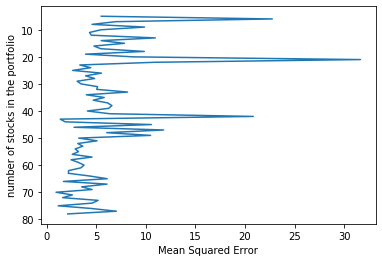

In [13]:
# Plot Efficient Deep Frontier

mse = [e/len(ibb['validate']['lp']) for e in error] # mse = sum of 2 norm difference/ # of test dates
plt.gca().invert_yaxis()
plt.plot(mse, list(range(5,79,1)))
plt.xlabel('Mean Squared Error')
plt.ylabel('number of stocks in the portfolio') 